In [ ]:
#!/usr/bin/env python3

import xgboost as xgb
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, TargetEncoder, RobustScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import RFE, SelectKBest, f_regression, mutual_info_regression, SelectFromModel
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import loguniform, randint, boxcox, yeojohnson
from scipy.spatial import distance_matrix
from scipy import stats
import warnings
import sys
import os
import joblib
from datetime import datetime, timedelta
import requests
import json
import time
from itertools import combinations
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import validation_curve
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Set plotly renderer for Jupyter Lab
pio.renderers.default = 'jupyterlab'

warnings.filterwarnings('ignore')

print("=" * 60)
print("REAL ESTATE ML REGRESSION PIPELINE")
print("=" * 60)
print(f"Pipeline started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Set data path for local Jupyter Lab environment
DATA_PATH = "/Users/efeobukohwo/Desktop/Nextproperty Real Estate/Dataset/realEstate.csv"

# Verify file exists
if os.path.exists(DATA_PATH):
    print(f"✓ Dataset found at: {DATA_PATH}")
else:
    print(f"❌ Dataset not found at: {DATA_PATH}")
    print("Please verify the file path and ensure the file exists.")
    sys.exit(1)

REAL ESTATE ML REGRESSION PIPELINE
Pipeline started at: 2025-06-07 13:45:42
✓ Dataset found at: /Users/efeobukohwo/Desktop/NextProperty/Dataset/realEstate.csv


In [2]:
# ========================
# BANK OF CANADA API INTEGRATION
# ========================

import requests
import json
from datetime import datetime, timedelta
import time

print("\n" + "=" * 40)
print("BANK OF CANADA API INTEGRATION")
print("=" * 40)

class BankOfCanadaAPI:
    """
    Bank of Canada API client for fetching economic indicators
    API Documentation: https://www.bankofcanada.ca/valet/docs
    """

    def __init__(self):
        self.base_url = "https://www.bankofcanada.ca/valet"
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Real-Estate-ML-Pipeline/1.0',
            'Accept': 'application/json'
        })

    def fetch_series(self, series_name, start_date=None, end_date=None, retry_count=3):
        """
        Fetch time series data from Bank of Canada

        Parameters:
        - series_name: BoC series code (e.g., 'V80691311' for policy rate)
        - start_date: Start date in YYYY-MM-DD format
        - end_date: End date in YYYY-MM-DD format
        """
        try:
            # Construct URL with proper format
            url = f"{self.base_url}/observations/{series_name}/json"

            # Add date parameters if provided
            params = {}
            if start_date:
                params['start_date'] = start_date
            if end_date:
                params['end_date'] = end_date

            print(f"   Requesting: {url} with params: {params}")

            for attempt in range(retry_count):
                try:
                    response = self.session.get(url, params=params, timeout=30)

                    # Log response details for debugging
                    print(f"   Response status: {response.status_code}")

                    if response.status_code == 404:
                        print(f"   ✗ Series {series_name} not found (404). This series may be discontinued or the code is incorrect.")
                        return pd.DataFrame()

                    response.raise_for_status()

                    data = response.json()

                    # Extract observations
                    if 'observations' in data:
                        observations = data['observations']
                        df = pd.DataFrame(observations)

                        if not df.empty:
                            df['date'] = pd.to_datetime(df['d'])

                            # Handle the nested value structure: series_name: {"v": "value"}
                            if series_name in df.columns:
                                # Extract the value from the nested structure
                                df['value'] = df[series_name].apply(lambda x: float(x.get('v', 0)) if isinstance(x, dict) and x.get('v') is not None else None)
                                df = df[['date', 'value']].dropna()
                                df = df.sort_values('date')
                                return df
                            else:
                                print(f"   ⚠ Series column {series_name} not found in response")
                                print(f"   Available columns: {list(df.columns)}")
                                return pd.DataFrame()
                        else:
                            print(f"   ⚠ No data returned for series {series_name}")
                            return pd.DataFrame()
                    else:
                        print(f"   ⚠ No observations found for series {series_name}")
                        print(f"   Response keys: {list(data.keys()) if isinstance(data, dict) else 'Not a dict'}")
                        return pd.DataFrame()

                except requests.exceptions.RequestException as e:
                    if attempt < retry_count - 1:
                        print(f"   ⚠ Attempt {attempt + 1} failed for {series_name}, retrying...")
                        time.sleep(2 ** attempt)  # Exponential backoff
                        continue
                    else:
                        print(f"   ✗ Failed to fetch {series_name} after {retry_count} attempts: {e}")
                        return pd.DataFrame()

        except Exception as e:
            print(f"   ✗ Error fetching series {series_name}: {e}")
            return pd.DataFrame()

    def get_latest_value(self, df):
        """Get the most recent value from a time series"""
        if df.empty:
            return None
        return df.iloc[-1]['value']

    def get_value_by_date(self, df, target_date):
        """Get value closest to target date"""
        if df.empty:
            return None

        df['date_diff'] = abs((df['date'] - pd.to_datetime(target_date)).dt.days)
        closest_idx = df['date_diff'].idxmin()
        return df.loc[closest_idx, 'value']

def fetch_economic_indicators():
    """
    Fetch key economic indicators from Bank of Canada
    Returns dictionary with current and historical values
    """

    boc = BankOfCanadaAPI()

    # Define key economic series with updated codes
    # Reference: https://www.bankofcanada.ca/rates/interest-rates/
    series_config = {
        'policy_rate': {
            'code': 'V39079',  # Target for the overnight rate
            'name': 'Bank of Canada Overnight Rate Target'
        },
        'prime_rate': {
            'code': 'V80691311',  # Prime rate
            'name': 'Prime Business Rate'
        },
        'mortgage_5yr': {
            'code': 'V80691335',  # 5-year conventional mortgage
            'name': '5-Year Conventional Mortgage Rate'
        },
        'govt_bond_3_5yr': {
            'code': 'V122485',  # Government of Canada marketable bonds - average yield - 3-5 year
            'name': '3-5 Year Government Bond Yield'
        },
        'exchange_rate_usd': {
            'code': 'FXUSDCAD',  # USD/CAD exchange rate (noon rate)
            'name': 'USD/CAD Exchange Rate'
        },
        'prime_rate_alt': {
            'code': 'V122495',  # Alternative Prime rate series
            'name': 'Prime Rate (Alternative Series)'
        }
    }

    # Calculate date range (last 5 years for trend analysis)
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=365*5)).strftime('%Y-%m-%d')

    economic_data = {}
    economic_trends = {}

    print(f"Fetching economic data from {start_date} to {end_date}...")

    for key, config in series_config.items():
        print(f"   Fetching {config['name']} ({config['code']})...")

        # Fetch time series data
        df = boc.fetch_series(config['code'], start_date, end_date)

        if not df.empty:
            # Current value
            current_value = boc.get_latest_value(df)
            economic_data[f'current_{key}'] = current_value

            # Calculate trends (6-month and 1-year changes)
            six_months_ago = (datetime.now() - timedelta(days=180)).strftime('%Y-%m-%d')
            one_year_ago = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

            value_6m_ago = boc.get_value_by_date(df, six_months_ago)
            value_1y_ago = boc.get_value_by_date(df, one_year_ago)

            if value_6m_ago is not None:
                economic_data[f'{key}_6m_change'] = current_value - value_6m_ago
                economic_data[f'{key}_6m_change_pct'] = ((current_value - value_6m_ago) / value_6m_ago) * 100 if value_6m_ago != 0 else 0

            if value_1y_ago is not None:
                economic_data[f'{key}_1y_change'] = current_value - value_1y_ago
                economic_data[f'{key}_1y_change_pct'] = ((current_value - value_1y_ago) / value_1y_ago) * 100 if value_1y_ago != 0 else 0

            # Store full time series for later analysis
            economic_trends[key] = df

            print(f"   ✓ {config['name']}: Current = {current_value:.3f}%")
        else:
            print(f"   ✗ Failed to fetch data for {config['name']}")
            # Set default values
            economic_data[f'current_{key}'] = None

    return economic_data, economic_trends

# Fetch economic indicators
try:
    economic_indicators, economic_time_series = fetch_economic_indicators()
    print(f"\n✓ Successfully fetched {len([k for k, v in economic_indicators.items() if v is not None])} economic indicators")

    # Display summary
    print("\nEconomic Indicators Summary:")
    print("-" * 50)
    current_indicators = {k: v for k, v in economic_indicators.items() if k.startswith('current_') and v is not None}
    for key, value in current_indicators.items():
        indicator_name = key.replace('current_', '').replace('_', ' ').title()
        print(f"{indicator_name:<25}: {value:8.3f}%")

except Exception as e:
    print(f"\n✗ Error fetching economic indicators: {e}")
    # Create empty economic data as fallback
    economic_indicators = {}
    economic_time_series = {}


BANK OF CANADA API INTEGRATION
Fetching economic data from 2020-06-08 to 2025-06-07...
   Fetching Bank of Canada Overnight Rate Target (V39079)...
   Requesting: https://www.bankofcanada.ca/valet/observations/V39079/json with params: {'start_date': '2020-06-08', 'end_date': '2025-06-07'}
   Response status: 200
   ✓ Bank of Canada Overnight Rate Target: Current = 2.750%
   Fetching Prime Business Rate (V80691311)...
   Requesting: https://www.bankofcanada.ca/valet/observations/V80691311/json with params: {'start_date': '2020-06-08', 'end_date': '2025-06-07'}
   Response status: 200
   ✓ Prime Business Rate: Current = 4.950%
   Fetching 5-Year Conventional Mortgage Rate (V80691335)...
   Requesting: https://www.bankofcanada.ca/valet/observations/V80691335/json with params: {'start_date': '2020-06-08', 'end_date': '2025-06-07'}
   Response status: 200
   ✓ 5-Year Conventional Mortgage Rate: Current = 6.090%
   Fetching 3-5 Year Government Bond Yield (V122485)...
   Requesting: https://

In [3]:
# ========================
# STATISTICS CANADA API INTEGRATION
# ========================

print("\n" + "=" * 40)
print("STATISTICS CANADA API INTEGRATION")
print("=" * 40)

class StatCanDataFetcher:
    """
    A class to fetch economic indicators from Statistics Canada API
    API Documentation: https://www.statcan.gc.ca/en/developers
    """

    def __init__(self):
        self.base_url = "https://www150.statcan.gc.ca/t1/wds/rest"
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Real-Estate-ML-Pipeline/1.0',
            'Accept': 'application/json',
            'Content-Type': 'application/json'
        })

    def get_table_data(self, table_id, coordinate_filters=None, start_date=None, end_date=None, retry_count=3):
        """
        Fetch data from a StatCan table using the WDS REST API

        Args:
            table_id (str): StatCan table ID (e.g., '14-10-0287-01')
            coordinate_filters (dict): Filters to apply to the data
            start_date (str): Start date in YYYY-MM-DD format
            end_date (str): End date in YYYY-MM-DD format

        Returns:
            pandas.DataFrame: Processed data
        """
        url = f"{self.base_url}/getDataFromVectorsAndLatestNPeriods"

        # Default filters if none provided
        if coordinate_filters is None:
            coordinate_filters = {}

        # Build request payload
        payload = [
            {
                "productId": table_id.replace('-', ''),
                "coordinate": coordinate_filters,
                "latestN": 120  # Get last 120 periods (about 10 years monthly data)
            }
        ]

        for attempt in range(retry_count):
            try:
                print(f"   Fetching table {table_id} (attempt {attempt + 1}/{retry_count})...")
                response = self.session.post(url, json=payload, timeout=60)

                print(f"   Response status: {response.status_code}")

                if response.status_code == 406:
                    print(f"   ✗ 406 Error for table {table_id}. Trying alternative method...")
                    return self._get_table_data_alternative(table_id, start_date, end_date)

                response.raise_for_status()

                data = response.json()

                if not data or len(data) == 0:
                    print(f"   ⚠ No data returned for table {table_id}")
                    return None

                # Process the response data
                df = self._process_statcan_response(data[0] if isinstance(data, list) else data)

                if df is not None and not df.empty:
                    # Filter by date range if provided
                    if start_date or end_date:
                        df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])
                        if start_date:
                            df = df[df['REF_DATE'] >= start_date]
                        if end_date:
                            df = df[df['REF_DATE'] <= end_date]

                    print(f"   ✓ Successfully fetched {len(df)} records from table {table_id}")
                    return df
                else:
                    print(f"   ⚠ No data processed for table {table_id}")
                    return None

            except requests.exceptions.RequestException as e:
                if attempt < retry_count - 1:
                    print(f"   ⚠ Attempt {attempt + 1} failed for table {table_id}, retrying...")
                    time.sleep(2 ** attempt)  # Exponential backoff
                    continue
                else:
                    print(f"   ✗ Failed to fetch table {table_id} after {retry_count} attempts: {e}")
                    return None
            except Exception as e:
                print(f"   ✗ Error processing table {table_id}: {e}")
                return None

    def _get_table_data_alternative(self, table_id, start_date=None, end_date=None):
        """
        Alternative method using the getAllCubesListLite endpoint
        """
        try:
            # Try getting specific vectors/series instead of full table
            if table_id == "36-10-0104-01":
                # GDP data - use specific vector
                return self._get_gdp_by_vector()
            elif table_id == "14-10-0287-01":
                # Employment data - use specific vectors
                return self._get_employment_by_vector()
            elif table_id == "18-10-0004-01":
                # CPI data - use specific vector
                return self._get_cpi_by_vector()
            else:
                print(f"   ⚠ No alternative method available for table {table_id}")
                return None
        except Exception as e:
            print(f"   ✗ Alternative method failed for table {table_id}: {e}")
            return None

    def _get_gdp_by_vector(self):
        """Get GDP data using vector ID"""
        try:
            url = f"{self.base_url}/getDataFromVectorsAndLatestNPeriods"
            payload = [
                {
                    "vectorId": 65201210,  # GDP at market prices, chained 2017 dollars, seasonally adjusted
                    "latestN": 40  # About 10 years of quarterly data
                }
            ]

            response = self.session.post(url, json=payload, timeout=60)
            response.raise_for_status()

            data = response.json()
            if data and len(data) > 0:
                return self._process_vector_response(data[0], 'GDP_Billions_CAD')
            return None
        except Exception as e:
            print(f"   ✗ Error fetching GDP vector: {e}")
            return None

    def _get_employment_by_vector(self):
        """Get employment data using vector IDs"""
        try:
            url = f"{self.base_url}/getDataFromVectorsAndLatestNPeriods"
            payload = [
                {
                    "vectorId": 2135091,  # Employment rate (alternative series)
                    "latestN": 60  # 5 years of monthly data
                },
                {
                    "vectorId": 3579270,  # Unemployment rate, Canada, both sexes, 15 years and over
                    "latestN": 60
                }
            ]

            response = self.session.post(url, json=payload, timeout=60)
            response.raise_for_status()

            data = response.json()
            if data and len(data) >= 2:
                emp_df = self._process_vector_response(data[0], 'Employment_Rate')
                unemp_df = self._process_vector_response(data[1], 'Unemployment_Rate')

                if emp_df is not None and unemp_df is not None:
                    merged = pd.merge(emp_df, unemp_df, on='REF_DATE', how='outer')
                    return merged
                elif unemp_df is not None:
                    # If only unemployment data available, return that
                    return unemp_df
                elif emp_df is not None:
                    # If only employment data available, return that
                    return emp_df
            return None
        except Exception as e:
            print(f"   ✗ Error fetching employment vectors: {e}")
            return None

    def _get_cpi_by_vector(self):
        """Get CPI data using vector ID"""
        try:
            url = f"{self.base_url}/getDataFromVectorsAndLatestNPeriods"
            payload = [
                {
                    "vectorId": 41690973,  # Consumer Price Index, all-items, Canada
                    "latestN": 60  # 5 years of monthly data
                }
            ]

            response = self.session.post(url, json=payload, timeout=60)
            response.raise_for_status()

            data = response.json()
            if data and len(data) > 0:
                df = self._process_vector_response(data[0], 'CPI')
                if df is not None:
                    # Calculate inflation rate
                    df['Inflation_Rate'] = df['CPI'].pct_change(periods=12) * 100
                return df
            return None
        except Exception as e:
            print(f"   ✗ Error fetching CPI vector: {e}")
            return None

    def _process_vector_response(self, response_data, value_column_name):
        """Process vector response data"""
        try:
            if 'object' in response_data and 'vectorDataPoint' in response_data['object']:
                data_points = response_data['object']['vectorDataPoint']

                records = []
                for point in data_points:
                    records.append({
                        'REF_DATE': point.get('refPer'),
                        value_column_name: float(point.get('value', 0)) if point.get('value') is not None else None
                    })

                df = pd.DataFrame(records)
                df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])
                df = df.dropna().sort_values('REF_DATE')
                return df
            return None
        except Exception as e:
            print(f"   ✗ Error processing vector response: {e}")
            return None

    def _process_statcan_response(self, response_data):
        """Process StatCan API response data"""
        try:
            # This would process the full table response
            # For now, return None to force use of vector method
            return None
        except Exception as e:
            print(f"   ✗ Error processing StatCan response: {e}")
            return None

    def get_gdp_data(self, start_date=None, end_date=None):
        """
        Get GDP data (quarterly, chained 2017 dollars)
        Using vector 65201210 for GDP at market prices
        """
        print("   Fetching GDP data...")
        return self._get_gdp_by_vector()

    def get_employment_data(self, start_date=None, end_date=None):
        """
        Get employment and unemployment rates
        Using vectors for Canada-wide employment data
        """
        print("   Fetching employment data...")
        return self._get_employment_by_vector()

    def get_cpi_data(self, start_date=None, end_date=None):
        """
        Get Consumer Price Index data
        Using vector 41690973 for all-items CPI, Canada
        """
        print("   Fetching CPI data...")
        return self._get_cpi_by_vector()

    def get_all_indicators(self, start_date=None, end_date=None):
        """
        Get all key economic indicators and merge them
        """
        print("Fetching all StatCan economic indicators...")

        # Fetch individual datasets
        gdp = self.get_gdp_data(start_date, end_date)
        time.sleep(1)  # Be respectful to the API

        employment = self.get_employment_data(start_date, end_date)
        time.sleep(1)

        cpi = self.get_cpi_data(start_date, end_date)
        time.sleep(1)

        # Start with the most frequent data (monthly employment)
        if employment is not None:
            combined = employment.copy()
            combined.rename(columns={'REF_DATE': 'Date'}, inplace=True, errors='ignore')

            # Add CPI data (monthly)
            if cpi is not None:
                cpi_renamed = cpi.copy()
                cpi_renamed.rename(columns={'REF_DATE': 'Date'}, inplace=True, errors='ignore')
                combined = pd.merge(combined, cpi_renamed[['Date', 'CPI', 'Inflation_Rate']], on='Date', how='outer')

            # Add GDP data (quarterly) - will create NaN for non-quarter months
            if gdp is not None:
                gdp_renamed = gdp.copy()
                gdp_renamed.rename(columns={'REF_DATE': 'Date'}, inplace=True, errors='ignore')
                combined = pd.merge(combined, gdp_renamed, on='Date', how='outer')

            combined = combined.sort_values('Date')
            print(f"✓ Combined economic data: {len(combined)} records")
            return combined
        elif cpi is not None:
            # If no employment data, start with CPI
            combined = cpi.copy()
            combined.rename(columns={'REF_DATE': 'Date'}, inplace=True, errors='ignore')

            if gdp is not None:
                gdp_renamed = gdp.copy()
                gdp_renamed.rename(columns={'REF_DATE': 'Date'}, inplace=True, errors='ignore')
                combined = pd.merge(combined, gdp_renamed, on='Date', how='outer')

            combined = combined.sort_values('Date')
            print(f"✓ Combined economic data: {len(combined)} records")
            return combined
        elif gdp is not None:
            # If only GDP data available
            combined = gdp.copy()
            combined.rename(columns={'REF_DATE': 'Date'}, inplace=True, errors='ignore')
            print(f"✓ GDP data only: {len(combined)} records")
            return combined

        print("✗ Failed to create combined economic dataset")
        return None

def fetch_statcan_indicators():
    """
    Fetch key economic indicators from Statistics Canada
    Returns current values and trends for integration with real estate model
    """

    fetcher = StatCanDataFetcher()

    # Get data for the last 5 years for trend analysis
    end_date = datetime.now()
    start_date = end_date - timedelta(days=5*365)

    print(f"Fetching StatCan data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}...")

    # Get all indicators
    data = fetcher.get_all_indicators(
        start_date=start_date.strftime('%Y-%m-%d'),
        end_date=end_date.strftime('%Y-%m-%d')
    )

    statcan_indicators = {}
    statcan_trends = {}

    if data is not None:
        # Get latest values
        latest_data = data.dropna().tail(1)

        if not latest_data.empty:
            latest_record = latest_data.iloc[-1]

            # Current values
            statcan_indicators['current_employment_rate'] = latest_record.get('Employment_Rate')
            statcan_indicators['current_unemployment_rate'] = latest_record.get('Unemployment_Rate')
            statcan_indicators['current_cpi'] = latest_record.get('CPI')
            statcan_indicators['current_inflation_rate'] = latest_record.get('Inflation_Rate')
            statcan_indicators['current_gdp'] = latest_record.get('GDP_Billions_CAD')

            # Calculate trends (6-month and 1-year changes)
            if len(data) > 12:  # Need at least 12 months for year-over-year
                data_12m_ago = data.iloc[-13] if len(data) >= 13 else data.iloc[0]
                data_6m_ago = data.iloc[-7] if len(data) >= 7 else data.iloc[0]

                # Employment rate trends
                if pd.notna(latest_record.get('Employment_Rate')) and pd.notna(data_6m_ago.get('Employment_Rate')):
                    statcan_indicators['employment_rate_6m_change'] = latest_record['Employment_Rate'] - data_6m_ago['Employment_Rate']

                if pd.notna(latest_record.get('Employment_Rate')) and pd.notna(data_12m_ago.get('Employment_Rate')):
                    statcan_indicators['employment_rate_1y_change'] = latest_record['Employment_Rate'] - data_12m_ago['Employment_Rate']

                # Unemployment rate trends
                if pd.notna(latest_record.get('Unemployment_Rate')) and pd.notna(data_6m_ago.get('Unemployment_Rate')):
                    statcan_indicators['unemployment_rate_6m_change'] = latest_record['Unemployment_Rate'] - data_6m_ago['Unemployment_Rate']

                if pd.notna(latest_record.get('Unemployment_Rate')) and pd.notna(data_12m_ago.get('Unemployment_Rate')):
                    statcan_indicators['unemployment_rate_1y_change'] = latest_record['Unemployment_Rate'] - data_12m_ago['Unemployment_Rate']

                # GDP trends (quarterly data will have more sparse points)
                if pd.notna(latest_record.get('GDP_Billions_CAD')) and pd.notna(data_12m_ago.get('GDP_Billions_CAD')):
                    gdp_change = latest_record['GDP_Billions_CAD'] - data_12m_ago['GDP_Billions_CAD']
                    gdp_change_pct = (gdp_change / data_12m_ago['GDP_Billions_CAD']) * 100 if data_12m_ago['GDP_Billions_CAD'] != 0 else 0
                    statcan_indicators['gdp_1y_change'] = gdp_change
                    statcan_indicators['gdp_1y_change_pct'] = gdp_change_pct

            # Store full time series for later analysis
            statcan_trends['combined_data'] = data

            print("\nStatCan Economic Indicators Summary:")
            print("-" * 50)
            for key, value in statcan_indicators.items():
                if value is not None and not pd.isna(value):
                    indicator_name = key.replace('current_', '').replace('_', ' ').title()
                    if 'rate' in key.lower() or 'inflation' in key.lower():
                        print(f"{indicator_name:<30}: {value:8.2f}%")
                    elif 'gdp' in key.lower() and 'pct' not in key.lower():
                        print(f"{indicator_name:<30}: {value:8.1f} Billion CAD")
                    elif 'change_pct' in key:
                        print(f"{indicator_name:<30}: {value:8.2f}%")
                    else:
                        print(f"{indicator_name:<30}: {value:8.2f}")
        else:
            print("⚠ No recent data available for current indicators")
    else:
        print("✗ Failed to fetch StatCan economic data")

    return statcan_indicators, statcan_trends

# Fetch Statistics Canada indicators
try:
    statcan_indicators, statcan_time_series = fetch_statcan_indicators()
    print(f"\n✓ Successfully fetched {len([k for k, v in statcan_indicators.items() if v is not None and not pd.isna(v)])} StatCan economic indicators")

except Exception as e:
    print(f"\n✗ Error fetching StatCan economic indicators: {e}")
    # Create empty StatCan data as fallback
    statcan_indicators = {}
    statcan_time_series = {}

# Combine all economic indicators
all_economic_indicators = {**economic_indicators, **statcan_indicators}
all_economic_time_series = {**economic_time_series, **statcan_time_series}

print(f"\n✓ Total economic indicators available: {len([k for k, v in all_economic_indicators.items() if v is not None and (not isinstance(v, float) or not pd.isna(v))])}")


STATISTICS CANADA API INTEGRATION
Fetching StatCan data from 2020-06-08 to 2025-06-07...
Fetching all StatCan economic indicators...
   Fetching GDP data...
   Fetching employment data...
   Fetching CPI data...
✓ Combined economic data: 61 records

StatCan Economic Indicators Summary:
--------------------------------------------------
Employment Rate               :    23.00%
Unemployment Rate             :     5.50%
Cpi                           :   163.50
Inflation Rate                :     2.32%
Gdp                           : 2291815.0 Billion CAD
Employment Rate 6M Change     :     0.00%
Employment Rate 1Y Change     :    -3.00%
Unemployment Rate 6M Change   :     3.00%
Unemployment Rate 1Y Change   :     2.60%
Gdp 1Y Change                 :  27180.0 Billion CAD
Gdp 1Y Change Pct             :     1.20%

✓ Successfully fetched 11 StatCan economic indicators

✓ Total economic indicators available: 36


In [4]:
# ========================
# ENHANCED DATA LOADING & CLEANING
# ========================

print("\n" + "=" * 30)
print("STAGE 1: ENHANCED DATA LOADING & CLEANING")
print("=" * 30)

def safe_load_data(file_path):
    """Safely load CSV data with error handling"""
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Data file not found: {file_path}")

        # Try different encodings if UTF-8 fails
        encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
        df = None

        for encoding in encodings:
            try:
                df = pd.read_csv(file_path, encoding=encoding)
                print(f"✓ Data loaded successfully with {encoding} encoding")
                break
            except UnicodeDecodeError:
                continue

        if df is None:
            raise ValueError("Unable to load file with any supported encoding")

        print(f"  - Shape: {df.shape}")
        print(f"  - Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
        print(f"  - Columns: {list(df.columns[:10])}{'...' if len(df.columns) > 10 else ''}")
        return df
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        sys.exit(1)

def integrate_economic_indicators(df, economic_data, statcan_data):
    """Integrate economic indicators into the main dataset"""
    print("\nIntegrating Economic Indicators into Dataset...")

    # Create a copy to avoid modifying original
    enhanced_df = df.copy()

    # Add current economic indicators as features for all properties
    economic_features = {}

    # Bank of Canada indicators
    for key, value in economic_data.items():
        if value is not None and not pd.isna(value):
            feature_name = f"econ_{key}"
            enhanced_df[feature_name] = value
            economic_features[feature_name] = value
            print(f"   ✓ Added {feature_name}: {value:.3f}")

    # Statistics Canada indicators
    for key, value in statcan_data.items():
        if value is not None and not pd.isna(value):
            feature_name = f"econ_{key}"
            enhanced_df[feature_name] = value
            economic_features[feature_name] = value
            print(f"   ✓ Added {feature_name}: {value:.3f}")

    # Create economic health index
    if economic_features:
        try:
            # Normalize key indicators for economic health index
            indicators_for_index = []

            # Employment indicators (positive impact)
            if 'econ_current_employment_rate' in enhanced_df.columns:
                indicators_for_index.append(enhanced_df['econ_current_employment_rate'] / 100)

            # Interest rate impact (negative for real estate)
            if 'econ_current_policy_rate' in enhanced_df.columns:
                indicators_for_index.append(-enhanced_df['econ_current_policy_rate'] / 10)

            # Inflation impact (moderate negative)
            if 'econ_current_inflation_rate' in enhanced_df.columns:
                indicators_for_index.append(-enhanced_df['econ_current_inflation_rate'] / 20)

            if indicators_for_index:
                enhanced_df['economic_health_index'] = np.mean(indicators_for_index, axis=0)
                print(f"   ✓ Created economic_health_index")

        except Exception as e:
            print(f"   ⚠ Could not create economic health index: {e}")

    print(f"   ✓ Enhanced dataset shape: {enhanced_df.shape}")
    print(f"   ✓ Added {len(economic_features)} economic features")

    return enhanced_df

# Load main dataset
df = safe_load_data(DATA_PATH)

# Integrate economic indicators from APIs
if 'all_economic_indicators' in globals() and all_economic_indicators:
    df = integrate_economic_indicators(df, economic_indicators, statcan_indicators)
else:
    print("⚠ No economic indicators available for integration")

# Display basic info about the loaded dataset
print(f"\nDataset Overview:")
print(f"- Total rows: {len(df):,}")
print(f"- Total columns: {len(df.columns)}")
print(f"- Missing values: {df.isnull().sum().sum():,}")
print(f"- Data types: {df.dtypes.value_counts().to_dict()}")

# Enhanced helper functions with error handling
def clean_text(text):
    """Clean text data safely"""
    try:
        if pd.isna(text):
            return np.nan
        return str(text).lower().strip()
    except Exception:
        return np.nan

def haversine(lat1, lon1, lat2, lon2):
    """Calculate haversine distance with error handling"""
    try:
        # Check for invalid coordinates
        if any(pd.isna([lat1, lon1, lat2, lon2])):
            return np.nan

        R = 6371  # Earth radius in km
        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
        return R * 2 * np.arcsin(np.sqrt(a))
    except Exception:
        return np.nan

try:
    # 1. Define essential columns that should be kept regardless of missing values
    print("\n1. Enhanced missing value analysis...")
    essential_columns = [
        'Price', 'PropertyType', 'City', 'Province', 'PostalCode',
        'Latitude', 'Longitude', 'BedroomsTotal', 'BathroomTotal', 'SizeTotalText',
        'SizeTotal', 'Features', 'HeatingType', 'CoolingType', 'CommunityName',
        'ZoningDescription', 'OwnershipType', 'ParkingSpaceTotal', 'StoriesTotal',
        'Amenities', 'Appliances', 'LandAmenities', 'FireplaceTotal', 'HalfBathTotal',
        'ExteriorFinish', 'BasementType', 'FoundationType', 'RoofMaterial'
    ]

    initial_cols = df.shape[1]
    threshold = len(df) * 0.5

    # Identify essential columns that exist in the dataset
    essential_available = [col for col in essential_columns if col in df.columns]
    essential_missing = [col for col in essential_columns if col not in df.columns]

    # Identify non-essential columns (excluding economic indicators)
    economic_cols = [col for col in df.columns if col.startswith('econ_')]
    non_essential_cols = [col for col in df.columns
                         if col not in essential_columns
                         and col not in economic_cols
                         and col != 'economic_health_index']

    # Drop only non-essential columns with >50% missing values
    cols_to_drop = []
    for col in non_essential_cols:
        missing_pct = df[col].isnull().sum() / len(df)
        if missing_pct > 0.5:
            cols_to_drop.append(col)

    df = df.drop(columns=cols_to_drop)
    dropped_cols = len(cols_to_drop)

    print(f"   ✓ Kept {len(essential_available)} essential columns")
    print(f"   ✓ Preserved {len(economic_cols) + (1 if 'economic_health_index' in df.columns else 0)} economic features")
    if essential_missing:
        print(f"   ⚠ Missing essential columns: {essential_missing}")
    print(f"   ✓ Dropped {dropped_cols} non-essential columns with >50% missing values")

    # Report missing value statistics for essential columns
    print("   Essential column missing value summary:")
    for col in essential_available:
        missing_pct = df[col].isnull().sum() / len(df) * 100
        if missing_pct > 0:
            print(f"     - {col}: {missing_pct:.1f}% missing")

    # 2. Enhanced text field cleaning
    print("2. Enhanced text field cleaning...")
    text_cols = df.select_dtypes(include='object').columns
    # Exclude economic indicator columns from text cleaning
    text_cols = [col for col in text_cols if not col.startswith('econ_')]

    for col in text_cols:
        df[col] = df[col].apply(clean_text)
    print(f"   ✓ Cleaned {len(text_cols)} text columns")

    # 3. Data quality assessment
    print("3. Data quality assessment...")
    available_cols = df.columns.tolist()

    # Check data types and potential issues
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    print(f"   ✓ Total columns: {len(available_cols)}")
    print(f"   ✓ Numeric columns: {len(numeric_cols)}")
    print(f"   ✓ Categorical columns: {len(categorical_cols)}")
    print(f"   ✓ Economic features: {len([col for col in available_cols if col.startswith('econ_') or col == 'economic_health_index'])}")

    # Check for required columns
    if 'Price' not in df.columns:
        raise ValueError("Target column 'Price' not found in dataset")

    print(f"✓ Enhanced data loading completed - Final shape: {df.shape}")

    # Save enhanced dataset summary
    enhancement_summary = {
        'original_shape': (len(df), initial_cols),
        'final_shape': df.shape,
        'economic_features_added': len([col for col in df.columns if col.startswith('econ_') or col == 'economic_health_index']),
        'columns_dropped': dropped_cols,
        'missing_value_ratio': df.isnull().sum().sum() / (df.shape[0] * df.shape[1])
    }

    print(f"\nEnhancement Summary:")
    print(f"- Original shape: {enhancement_summary['original_shape']}")
    print(f"- Final shape: {enhancement_summary['final_shape']}")
    print(f"- Economic features added: {enhancement_summary['economic_features_added']}")
    print(f"- Overall missing value ratio: {enhancement_summary['missing_value_ratio']:.3f}")

except Exception as e:
    print(f"✗ Error in enhanced data loading: {e}")
    sys.exit(1)


STAGE 1: ENHANCED DATA LOADING & CLEANING
✓ Data loaded successfully with utf-8 encoding
  - Shape: (49551, 162)
  - Memory usage: 60.58 MB
  - Columns: ['property_id', 'PostID', 'Offices', 'Agents', 'Board', 'ListingID', 'DdfListingID', 'LastUpdated', 'Latitude', 'Longitude']...

Integrating Economic Indicators into Dataset...
   ✓ Added econ_current_policy_rate: 2.750
   ✓ Added econ_policy_rate_6m_change: -1.000
   ✓ Added econ_policy_rate_6m_change_pct: -26.667
   ✓ Added econ_policy_rate_1y_change: -2.000
   ✓ Added econ_policy_rate_1y_change_pct: -42.105
   ✓ Added econ_current_prime_rate: 4.950
   ✓ Added econ_prime_rate_6m_change: -1.000
   ✓ Added econ_prime_rate_6m_change_pct: -16.807
   ✓ Added econ_prime_rate_1y_change: -2.250
   ✓ Added econ_prime_rate_1y_change_pct: -31.250
   ✓ Added econ_current_mortgage_5yr: 6.090
   ✓ Added econ_mortgage_5yr_6m_change: -0.400
   ✓ Added econ_mortgage_5yr_6m_change_pct: -6.163
   ✓ Added econ_mortgage_5yr_1y_change: -0.750
   ✓ Added 

In [5]:
# ======================
# ENHANCED MISSING VALUE HANDLING
# ======================

print("\n" + "=" * 30)
print("STAGE 2: ENHANCED MISSING VALUE HANDLING")
print("=" * 30)

def smart_impute(df, group_col, target_col):
    """Enhanced smart imputation with multiple strategies"""
    try:
        if group_col not in df.columns or target_col not in df.columns:
            print(f"   ⚠ Column not found for imputation: {group_col} or {target_col}")
            return df[target_col] if target_col in df.columns else pd.Series()

        # Group-based imputation with fallback strategies
        if df[target_col].dtype.kind in 'biufc':  # numeric
            # Try median first, then mean as fallback
            group_vals = df.groupby(group_col)[target_col].transform('median')
            global_val = df[target_col].median()

            # If median is NaN, try mean
            if pd.isna(global_val):
                global_val = df[target_col].mean()

        else:  # categorical
            group_vals = df.groupby(group_col)[target_col].transform(
                lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan
            )
            mode_vals = df[target_col].mode()
            global_val = mode_vals[0] if len(mode_vals) > 0 else 'unknown'

        result = df[target_col].fillna(group_vals).fillna(global_val)
        return result
    except Exception as e:
        print(f"   ⚠ Imputation failed for {target_col}: {e}")
        return df[target_col] if target_col in df.columns else pd.Series()

def advanced_geographic_imputation(df):
    """Use geographic proximity for imputation"""
    print("\nAdvanced Geographic Imputation...")

    if 'Latitude' not in df.columns or 'Longitude' not in df.columns:
        print("   ⚠ Geographic coordinates not available")
        return df

    # Create geographic clusters for better imputation
    from sklearn.cluster import KMeans

    # Get valid coordinates
    coord_mask = df[['Latitude', 'Longitude']].notna().all(axis=1)
    if coord_mask.sum() < 10:
        print("   ⚠ Insufficient geographic data for clustering")
        return df

    coords = df.loc[coord_mask, ['Latitude', 'Longitude']].values

    # Create geographic clusters
    n_clusters = min(20, max(5, len(coords) // 100))  # Adaptive cluster count
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df.loc[coord_mask, 'GeoCluster'] = kmeans.fit_predict(coords)

    # Propagate clusters to nearby properties without coordinates
    # This is a simplified approach - in practice, you'd use more sophisticated methods
    df['GeoCluster'] = df['GeoCluster'].fillna(
        df.groupby(['Province', 'City'])['GeoCluster'].transform('median')
    )

    print(f"   ✓ Created {n_clusters} geographic clusters")
    return df

def economic_aware_imputation(df):
    """Imputation that considers economic indicators"""
    print("\nEconomic-Aware Imputation...")

    # Get economic indicator columns
    econ_cols = [col for col in df.columns if col.startswith('econ_')]

    if not econ_cols:
        print("   ⚠ No economic indicators found for economic-aware imputation")
        return df

    # Create economic segments based on key indicators
    try:
        # Use interest rates and employment to create economic segments
        if 'econ_current_policy_rate' in df.columns:
            policy_rate = df['econ_current_policy_rate'].iloc[0]
            if policy_rate < 2.0:
                econ_segment = 'low_interest'
            elif policy_rate < 4.0:
                econ_segment = 'medium_interest'
            else:
                econ_segment = 'high_interest'

            df['EconomicSegment'] = econ_segment
            print(f"   ✓ Created economic segment: {econ_segment}")

        # Adjust imputation based on economic conditions
        # For example, in high interest rate environments, luxury features might be less common
        if 'EconomicSegment' in df.columns and 'FireplaceTotal' in df.columns:
            # Different imputation strategies based on economic conditions
            if df['EconomicSegment'].iloc[0] == 'high_interest':
                # More conservative imputation in high interest rate environment
                df['FireplaceTotal'] = df['FireplaceTotal'].fillna(0)
            else:
                # Standard imputation
                df['FireplaceTotal'] = smart_impute(df, 'PropertyType', 'FireplaceTotal')

    except Exception as e:
        print(f"   ⚠ Economic-aware imputation failed: {e}")

    return df

try:
    # 1. Preserve economic indicators (they should not have missing values)
    print("1. Preserving economic indicators...")
    econ_cols = [col for col in df.columns if col.startswith('econ_') or col == 'economic_health_index']

    for col in econ_cols:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"   ⚠ Economic indicator {col} has {missing_count} missing values")
            # Economic indicators should be constant for all rows, so forward fill
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        else:
            print(f"   ✓ {col}: No missing values")

    # 2. Advanced geographic imputation
    df = advanced_geographic_imputation(df)

    # 3. Economic-aware imputation
    df = economic_aware_imputation(df)

    # 4. Enhanced imputation for property features
    print("\n4. Enhanced property feature imputation...")

    # Extended list of columns to impute
    impute_cols = [
        'BedroomsTotal', 'BathroomTotal', 'HeatingType', 'CoolingType',
        'ParkingSpaceTotal', 'StoriesTotal', 'FireplaceTotal', 'HalfBathTotal',
        'ExteriorFinish', 'BasementType', 'FoundationType', 'RoofMaterial',
        'ZoningDescription', 'OwnershipType', 'SizeTotal'
    ]

    # Use multiple grouping strategies
    grouping_strategies = ['PropertyType', 'City', 'Province']
    if 'GeoCluster' in df.columns:
        grouping_strategies.append('GeoCluster')
    if 'EconomicSegment' in df.columns:
        grouping_strategies.append('EconomicSegment')

    for col in impute_cols:
        if col in df.columns:
            before_nulls = df[col].isnull().sum()

            # Try multiple grouping strategies
            for group_col in grouping_strategies:
                if group_col in df.columns:
                    df[col] = smart_impute(df, group_col, col)
                    current_nulls = df[col].isnull().sum()

                    if current_nulls < before_nulls:
                        print(f"   ✓ {col} improved with {group_col}: {before_nulls} → {current_nulls} missing")
                        before_nulls = current_nulls
                        if current_nulls == 0:
                            break

            # Final check
            final_nulls = df[col].isnull().sum()
            if final_nulls > 0:
                print(f"   ⚠ {col}: Still has {final_nulls} missing values after imputation")
        else:
            print(f"   ⚠ Column {col} not available for imputation")

    # 5. Special handling for text-heavy columns with list-like content
    print("\n5. Enhanced text feature handling...")
    text_list_cols = ['Features', 'Amenities', 'Appliances', 'LandAmenities']
    for col in text_list_cols:
        if col in df.columns:
            before_nulls = df[col].isnull().sum()
            df[col] = df[col].fillna('none')  # Fill with 'none' for missing amenities/features
            after_nulls = df[col].isnull().sum()
            print(f"   ✓ {col}: {before_nulls} → {after_nulls} missing values (filled with 'none')")

    # 6. Handle remaining missing values with advanced strategies
    print("\n6. Final missing value cleanup...")

    remaining_missing = df.isnull().sum()
    critical_cols = ['Price', 'PropertyType', 'Latitude', 'Longitude']

    for col in critical_cols:
        if col in df.columns and remaining_missing[col] > 0:
            print(f"   ⚠ Critical column {col} still has {remaining_missing[col]} missing values")

            if col == 'Price':
                # Remove rows with missing price (target variable)
                original_len = len(df)
                df = df.dropna(subset=['Price'])
                dropped = original_len - len(df)
                print(f"   ✓ Dropped {dropped} rows with missing Price")

    # 7. Create missing value indicators for important features
    print("\n7. Creating missing value indicators...")
    important_cols = ['SizeTotal', 'BedroomsTotal', 'BathroomTotal']

    for col in important_cols:
        if col in df.columns:
            missing_indicator_col = f"{col}_was_missing"
            df[missing_indicator_col] = df[col].isnull().astype(int)
            missing_count = df[missing_indicator_col].sum()
            print(f"   ✓ Created {missing_indicator_col}: {missing_count} cases")

    print(f"\n✓ Enhanced missing value handling completed")
    print(f"   Final missing values: {df.isnull().sum().sum():,}")
    print(f"   Final dataset shape: {df.shape}")

    # Summary of missing value handling
    missing_summary = {
        'total_missing': df.isnull().sum().sum(),
        'missing_by_column': df.isnull().sum().sort_values(ascending=False),
        'missing_percentage': (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    }

    print("\nColumns with remaining missing values:")
    for col, missing_pct in missing_summary['missing_percentage'].items():
        if missing_pct > 0:
            print(f"   - {col}: {missing_pct:.1f}%")

except Exception as e:
    print(f"✗ Error in enhanced missing value handling: {e}")
    # Continue with basic imputation if enhanced version fails
    print("Falling back to basic imputation...")

    basic_impute_cols = ['BedroomsTotal', 'BathroomTotal', 'ParkingSpaceTotal']
    for col in basic_impute_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())


STAGE 2: ENHANCED MISSING VALUE HANDLING
1. Preserving economic indicators...
   ✓ econ_current_policy_rate: No missing values
   ✓ econ_policy_rate_6m_change: No missing values
   ✓ econ_policy_rate_6m_change_pct: No missing values
   ✓ econ_policy_rate_1y_change: No missing values
   ✓ econ_policy_rate_1y_change_pct: No missing values
   ✓ econ_current_prime_rate: No missing values
   ✓ econ_prime_rate_6m_change: No missing values
   ✓ econ_prime_rate_6m_change_pct: No missing values
   ✓ econ_prime_rate_1y_change: No missing values
   ✓ econ_prime_rate_1y_change_pct: No missing values
   ✓ econ_current_mortgage_5yr: No missing values
   ✓ econ_mortgage_5yr_6m_change: No missing values
   ✓ econ_mortgage_5yr_6m_change_pct: No missing values
   ✓ econ_mortgage_5yr_1y_change: No missing values
   ✓ econ_mortgage_5yr_1y_change_pct: No missing values
   ✓ econ_current_govt_bond_3_5yr: No missing values
   ✓ econ_govt_bond_3_5yr_6m_change: No missing values
   ✓ econ_govt_bond_3_5yr_6m_c


--- Outlier Detection and Handling (IQR Method) ---
Feature 'Price': Detected 2529 outliers.
  Added outlier flag column: Price_is_outlier
  Outliers capped to calculated bounds (Lower: -1497000.00, Upper: 2495000.00).


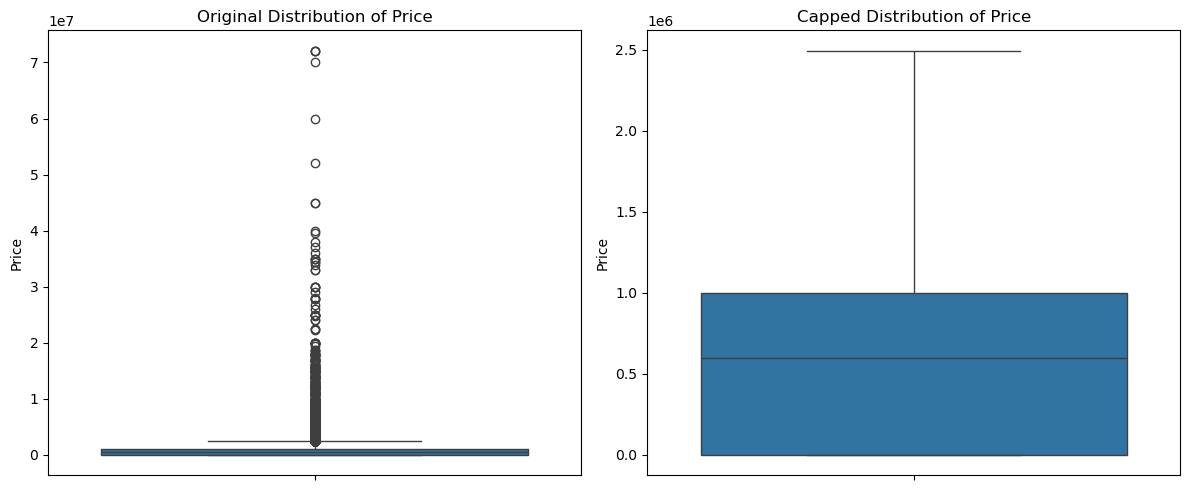

Feature 'BedroomsTotal': Detected 108 outliers.
  Added outlier flag column: BedroomsTotal_is_outlier
  Outliers capped to calculated bounds (Lower: -6.00, Upper: 10.00).


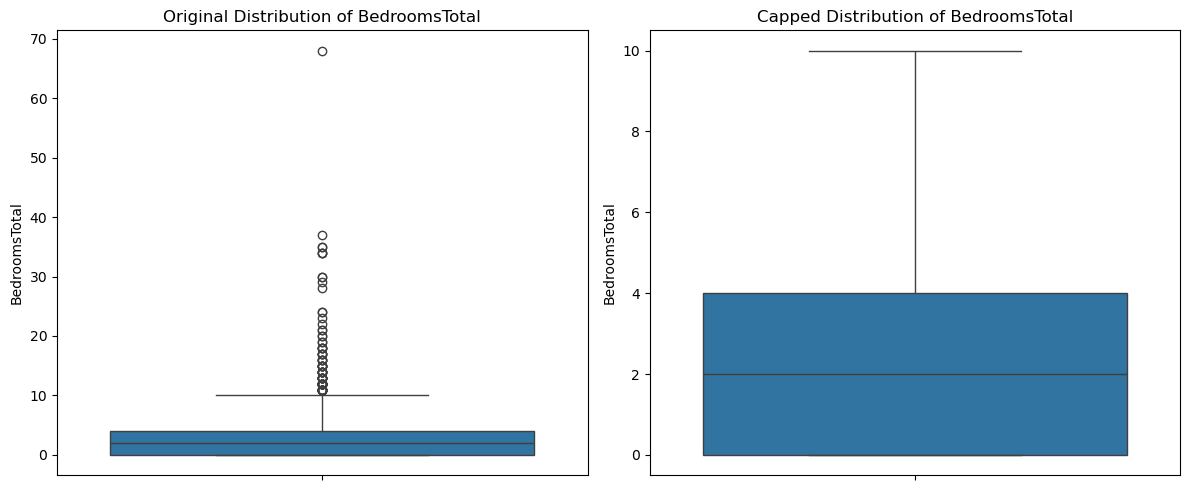

Feature 'BathroomTotal': Detected 421 outliers.
  Added outlier flag column: BathroomTotal_is_outlier
  Outliers capped to calculated bounds (Lower: -2.00, Upper: 6.00).


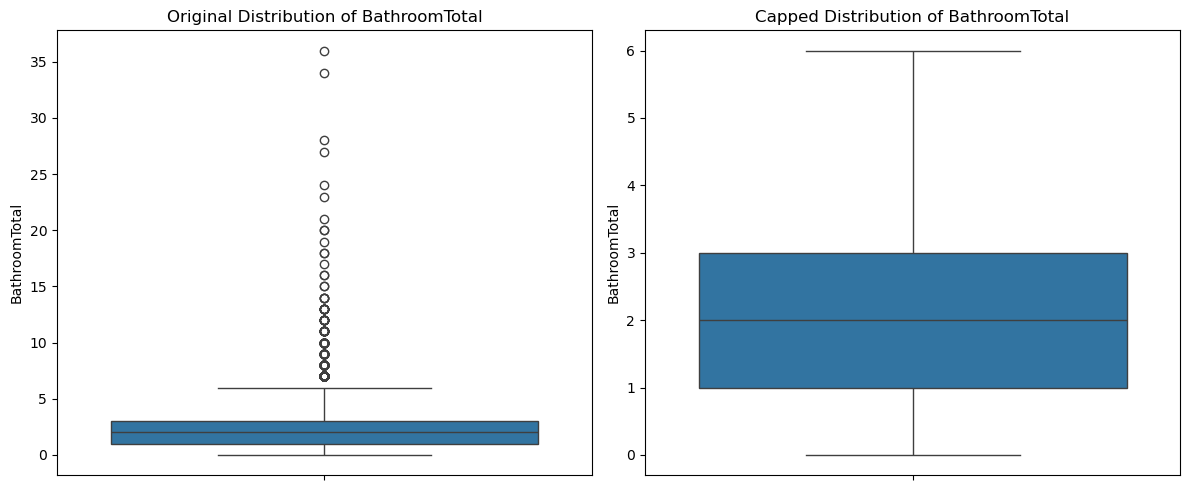

Feature 'SizeSqFt' not found in DataFrame. Skipping.
Feature 'Price_Per_SqFt' not found in DataFrame. Skipping.

DataFrame after outlier handling (first 5 rows):
   property_id  PostID Offices           Agents  Board  ListingID  \
0        12114   28243   48718  1397966,1666165     34   25718592   
1        16364   32497   48597          1396843     32   25939702   
2        22325   38466   79958          1523345     35   26063683   
3        25888   42034  289717          1523363     35   25989379   
4        32653   48800   48718          1397966     34   22934104   

  DdfListingID          LastUpdated   Latitude  Longitude  ...  \
0     23011586  2023-06-15 19:19:09  42.293570 -82.851470  ...   
1     23015822  2023-09-05 16:18:25  42.400364 -82.184311  ...   
2      2113377  2023-09-15 20:58:46  46.478279 -81.021133  ...   
3      2112960  2023-08-31 15:48:22  46.457092 -80.439575  ...   
4     21003171  2021-03-18 05:42:24  42.314396 -83.051613  ...   

  econ_gdp_1y_change_pct e

In [6]:
#Enhance Further the Detect and Cap Outliers in Key Numeric Features


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def detect_and_handle_outliers_advanced(df, numeric_features, method='iqr', cap_method='custom_percentile', visualize=False):
    """
    Detects and handles outliers in numeric features using IQR or Z-score method.
    Flags outliers and can cap them based on a specified method.
    Includes an option to visualize the distributions before and after outlier capping.

    Args:
        df (pd.DataFrame): The input DataFrame.
        numeric_features (list): A list of numeric column names to process.
        method (str): Outlier detection method ('iqr' or 'zscore').
        cap_method (str): Method to cap outliers ('median', 'mean', 'custom_percentile').
        visualize (bool): If True, plots box plots before and after outlier handling.

    Returns:
        pd.DataFrame: DataFrame with outliers flagged and optionally capped.
    """
    df_copy = df.copy()

    print(f"\n--- Outlier Detection and Handling ({method.upper()} Method) ---")

    for feature in numeric_features:
        if feature not in df_copy.columns:
            print(f"Feature '{feature}' not found in DataFrame. Skipping.")
            continue
        if df_copy[feature].isnull().all():
            print(f"Feature '{feature}' contains all NaN values. Skipping outlier detection.")
            continue

        original_data = df_copy[feature].dropna()

        if original_data.empty:
            print(f"Feature '{feature}' has no valid data after dropping NaNs. Skipping outlier detection.")
            continue

        lower_bound = None
        upper_bound = None

        if method == 'iqr':
            Q1 = original_data.quantile(0.25)
            Q3 = original_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = original_data[(original_data < lower_bound) | (original_data > upper_bound)]
            #Add outlier flag
            df_copy[f'{feature}_is_outlier'] = df_copy[feature].apply(
                lambda x: 1 if (x < lower_bound or x > upper_bound) and pd.notna(x) else 0
            )
        elif method == 'zscore':
            mean = original_data.mean()
            std = original_data.std()
            if std == 0:
                print(f"Feature '{feature}' has zero standard deviation. Skipping Z-score outlier detection.")
                continue
            z_scores = np.abs((original_data - mean) / std)
            threshold = 3  # Common Z-score threshold
            outliers = original_data[z_scores > threshold]
            lower_bound = mean - threshold * std
            upper_bound = mean + threshold * std
            # MODIFICATION: Add outlier flag
            df_copy[f'{feature}_is_outlier'] = df_copy[feature].apply(
                lambda x: 1 if (abs((x - mean) / std) > threshold) and pd.notna(x) else 0
            )
        else:
            print(f"Unsupported outlier detection method: {method}. Skipping feature '{feature}'.")
            continue

        num_outliers = len(outliers)
        if num_outliers > 0:
            print(f"Feature '{feature}': Detected {num_outliers} outliers.")
            print(f"  Added outlier flag column: {feature}_is_outlier")

            if visualize:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                sns.boxplot(y=df_copy[feature].dropna())
                plt.title(f'Original Distribution of {feature}')
                plt.ylabel(feature)

            # Cap outliers
            if cap_method == 'median':
                cap_value = original_data.median()
                df_copy[feature] = np.where(df_copy[feature] < lower_bound, cap_value, df_copy[feature])
                df_copy[feature] = np.where(df_copy[feature] > upper_bound, cap_value, df_copy[feature])
                print(f"  Outliers capped to median ({cap_value:.2f}).")
            elif cap_method == 'mean':
                cap_value = original_data.mean()
                df_copy[feature] = np.where(df_copy[feature] < lower_bound, cap_value, df_copy[feature])
                df_copy[feature] = np.where(df_copy[feature] > upper_bound, cap_value, df_copy[feature])
                print(f"  Outliers capped to mean ({cap_value:.2f}).")
            elif cap_method == 'custom_percentile':
                df_copy[feature] = np.where(df_copy[feature] < lower_bound, lower_bound, df_copy[feature])
                df_copy[feature] = np.where(df_copy[feature] > upper_bound, upper_bound, df_copy[feature])
                print(f"  Outliers capped to calculated bounds (Lower: {lower_bound:.2f}, Upper: {upper_bound:.2f}).")
            else:
                print(f"  Unsupported capping method: {cap_method}. Outliers not capped for '{feature}'.")

            if visualize:
                plt.subplot(1, 2, 2)
                sns.boxplot(y=df_copy[feature].dropna())
                plt.title(f'Capped Distribution of {feature}')
                plt.ylabel(feature)
                plt.tight_layout()
                plt.show()
        else:
            print(f"Feature '{feature}': No outliers detected.")
            # MODIFICATION: Add flag column even if no outliers
            df_copy[f'{feature}_is_outlier'] = 0

    return df_copy

# Example Usage
numeric_features_to_check = ['Price', 'BedroomsTotal', 'BathroomTotal', 'SizeSqFt', 'Price_Per_SqFt']

# Apply the enhanced outlier detection and handling with visualization
df_processed = detect_and_handle_outliers_advanced(
    df,
    numeric_features_to_check,
    method='iqr',
    cap_method='custom_percentile',
    visualize=True
)

print("\nDataFrame after outlier handling (first 5 rows):")
print(df_processed.head())

In [7]:
#Extract Numeric Measurements from Descriptive Text Fields

import re
import pandas as pd

def extract_numeric_from_text(df, text_column, new_column_prefix):
    """
    Extracts numeric measurements (e.g., 'sq ft', 'bedrooms', 'bathrooms')
    from a descriptive text column using regex.
    """
    df[f'{new_column_prefix}_SquareFeet'] = df[text_column].apply(
        lambda x: next(
            (
                float(re.search(r'(\d+(\.\d+)?)\s*(sq\.?ft|square\s*feet)', str(x), re.IGNORECASE).group(1))
                for _ in range(1)
                if re.search(r'(\d+(\.\d+)?)\s*(sq\.?ft|square\s*feet)', str(x), re.IGNORECASE)
            ),
            None,
        )
    )

    df[f'{new_column_prefix}_Bedrooms'] = df[text_column].apply(
        lambda x: next(
            (
                int(re.search(r'(\d+)\s*(bedroom|bdr?m)s?', str(x), re.IGNORECASE).group(1))
                for _ in range(1)
                if re.search(r'(\d+)\s*(bedroom|bdr?m)s?', str(x), re.IGNORECASE)
            ),
            None,
        )
    )

    df[f'{new_column_prefix}_Bathrooms'] = df[text_column].apply(
        lambda x: next(
            (
                float(re.search(r'(\d+(\.\d+)?)\s*(bathroom|bath)s?', str(x), re.IGNORECASE).group(1))
                for _ in range(1)
                if re.search(r'(\d+(\.\d+)?)\s*(bathroom|bath)s?', str(x), re.IGNORECASE)
            ),
            None,
        )
    )
    return df
df = extract_numeric_from_text(df, 'PublicRemarks', 'Parsed')

print("\n--- Extracted Numeric Values (First 5 rows) ---")

columns_to_print = []
if 'PublicRemarks' in df.columns:
    columns_to_print.append('PublicRemarks')
if 'Parsed_SquareFeet' in df.columns:
    columns_to_print.append('Parsed_SquareFeet')
if 'Parsed_Bedrooms' in df.columns:
    columns_to_print.append('Parsed_Bedrooms')
if 'Parsed_Bathrooms' in df.columns:
    columns_to_print.append('Parsed_Bathrooms')

if columns_to_print:
    print(df[columns_to_print].head())
else:
    print("No relevant columns found to print. Please ensure 'Remarks' (or your text column) exists and the extraction was successful.")

print("\n--- Summary of Extracted Values (Non-null counts) ---")
if 'Parsed_SquareFeet' in df.columns:
    print(f"Parsed_SquareFeet non-null count: {df['Parsed_SquareFeet'].notna().sum()}")
if 'Parsed_Bedrooms' in df.columns:
    print(f"Parsed_Bedrooms non-null count: {df['Parsed_Bedrooms'].notna().sum()}")
if 'Parsed_Bathrooms' in df.columns:
    print(f"Parsed_Bathrooms non-null count: {df['Parsed_Bathrooms'].notna().sum()}")



--- Extracted Numeric Values (First 5 rows) ---
                                       PublicRemarks  Parsed_SquareFeet  \
0  lot # 5 is a 2.6 acre parcel in the new ""high...                NaN   
1  attention investors/landlords/business owners!...                NaN   
2  4 building lots.   r2-3 zoning.   each lot is ...                NaN   
3  this property located on hwy 17 east near the ...                NaN   
4  2326 sq ft of first class main floor office sp...                NaN   

   Parsed_Bedrooms  Parsed_Bathrooms  
0              NaN               NaN  
1              NaN               4.0  
2              NaN               NaN  
3              NaN               NaN  
4              NaN               NaN  

--- Summary of Extracted Values (Non-null counts) ---
Parsed_SquareFeet non-null count: 5205
Parsed_Bedrooms non-null count: 13095
Parsed_Bathrooms non-null count: 8089



STAGE 4: ENHANCED EXPLORATORY DATA ANALYSIS (EDA)
1. Enhanced Data Information:
Dataset shape: (49551, 114)
Missing values: 341,073
Memory usage: 236.31 MB
Economic features: 37
Engineered features: 9
Original features: 68

2. Enhanced Descriptive Statistics:

Key Property Features:
              Price  BedroomsTotal  BathroomTotal
count  4.955100e+04   49551.000000   49551.000000
mean   8.268296e+05       2.389013       1.903312
std    1.641368e+06       1.978152       1.595932
min    0.000000e+00       0.000000       0.000000
25%    0.000000e+00       0.000000       1.000000
50%    5.980000e+05       2.000000       2.000000
75%    9.980000e+05       4.000000       3.000000
max    7.212800e+07      68.000000      36.000000

Economic Indicators:
  econ_current_policy_rate: 2.75
  econ_policy_rate_6m_change: -1.0
  econ_policy_rate_6m_change_pct: -26.666666666666668
  econ_policy_rate_1y_change: -2.0
  econ_policy_rate_1y_change_pct: -42.10526315789473
  econ_current_prime_rate: 4.95
 

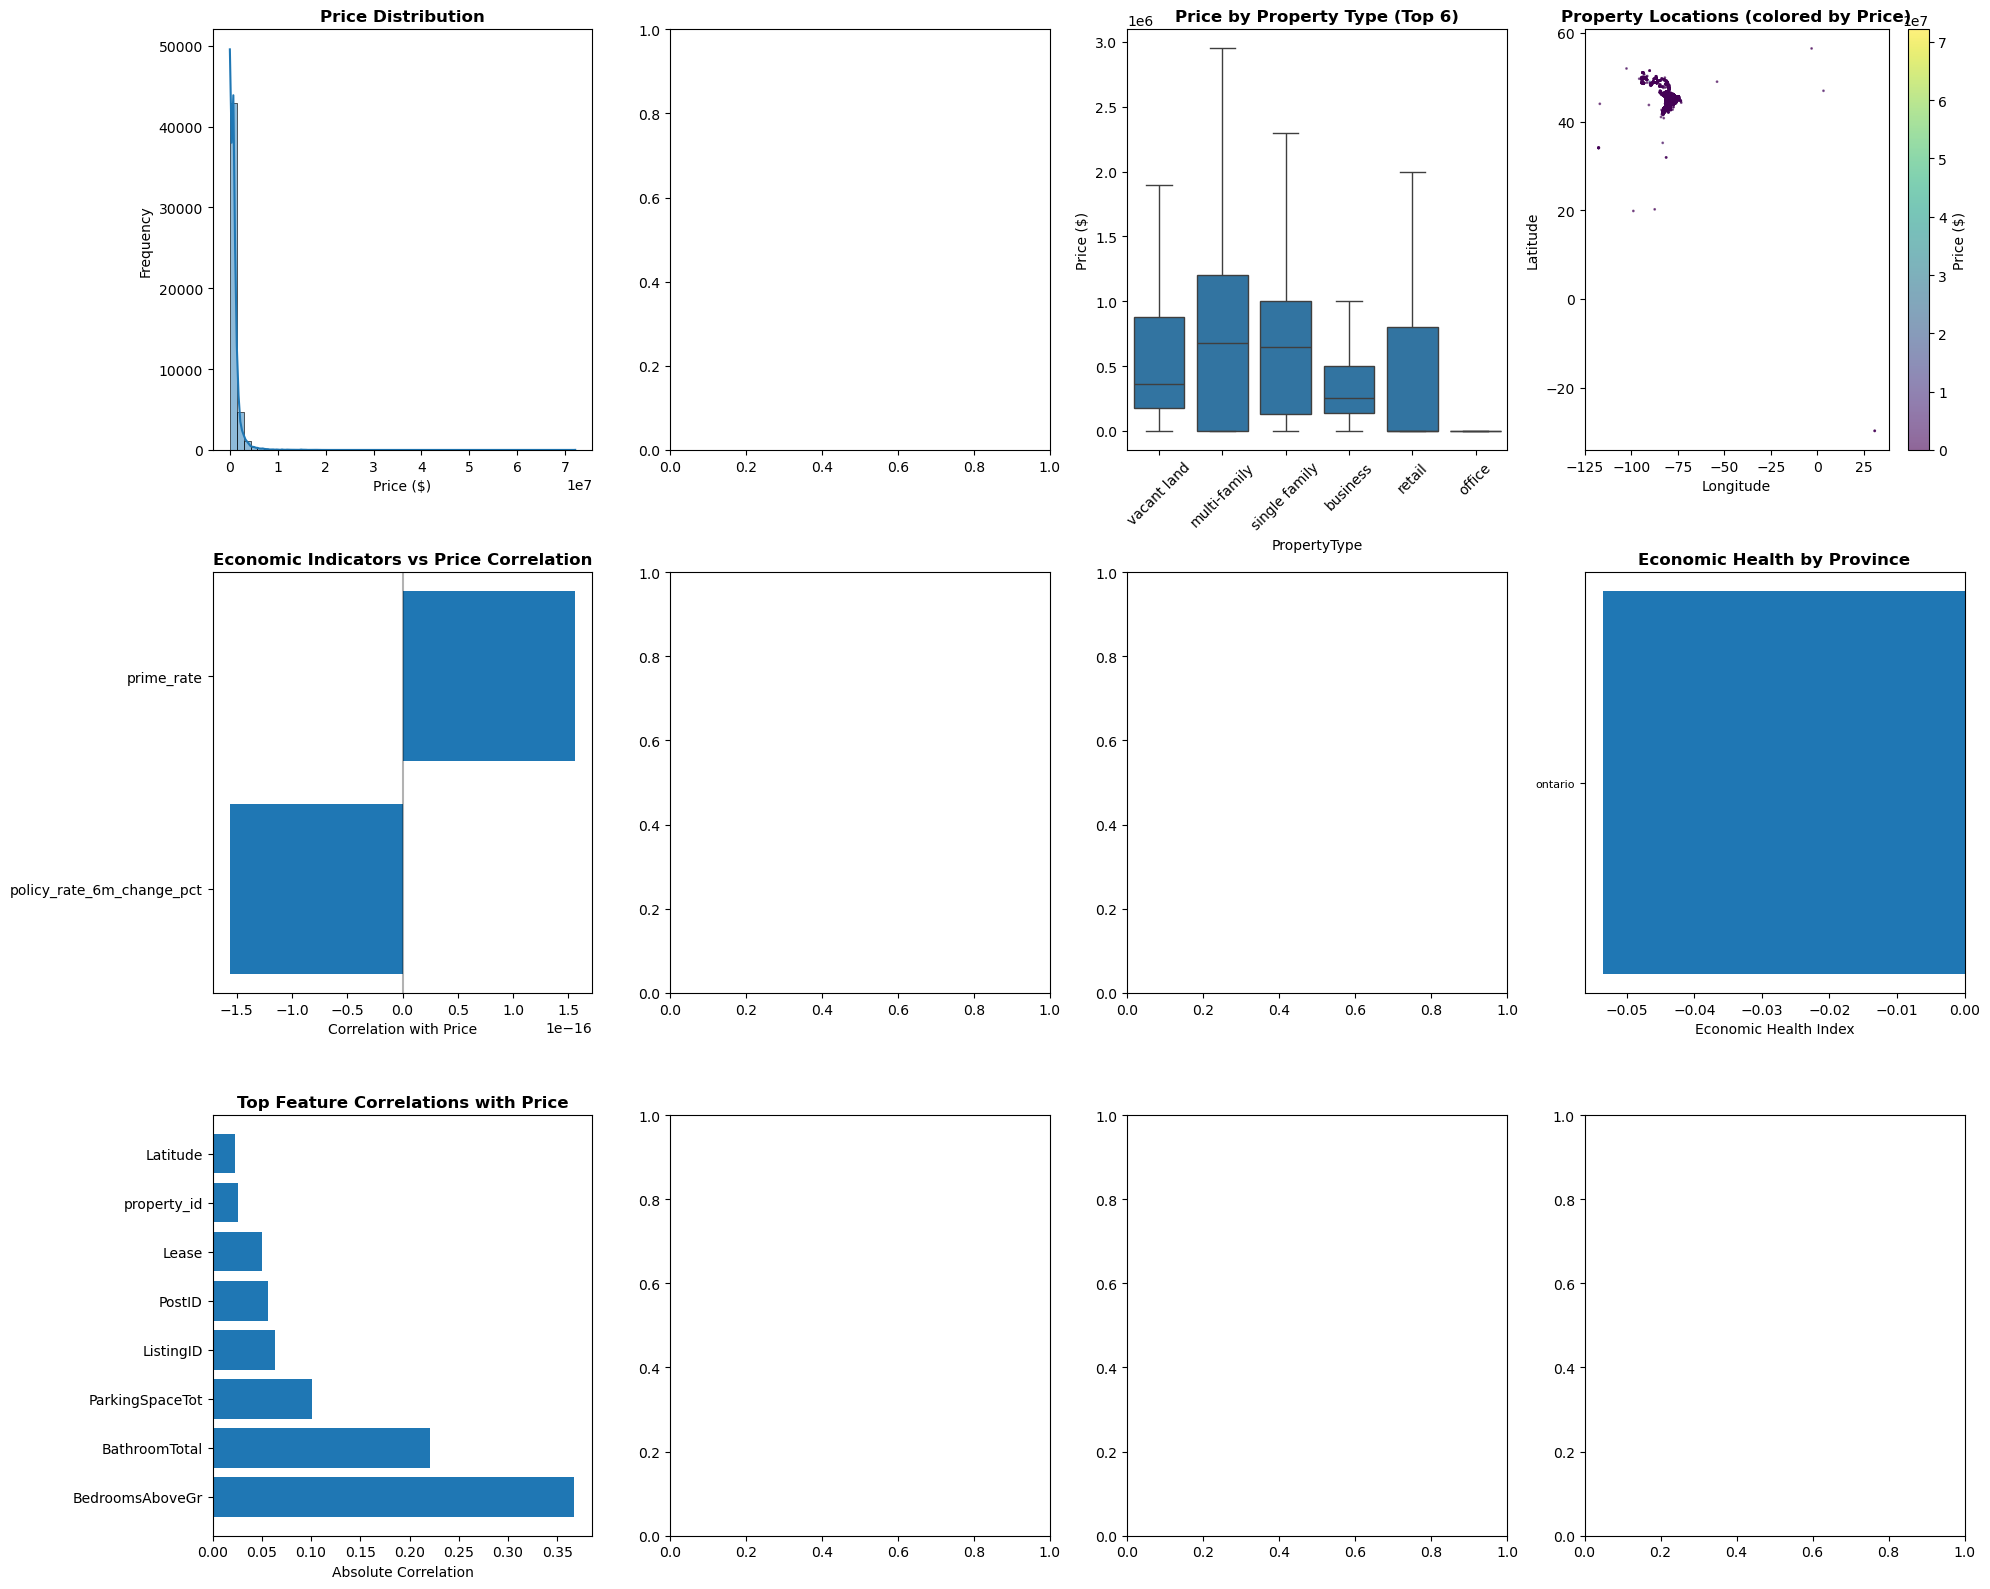

   ✓ Comprehensive visualization dashboard created

7. Enhanced Correlation Analysis:
Filtered dataset to 34751 properties with 1-5 bedrooms for correlation analysis

Generating scatter plots for key features vs. Price...


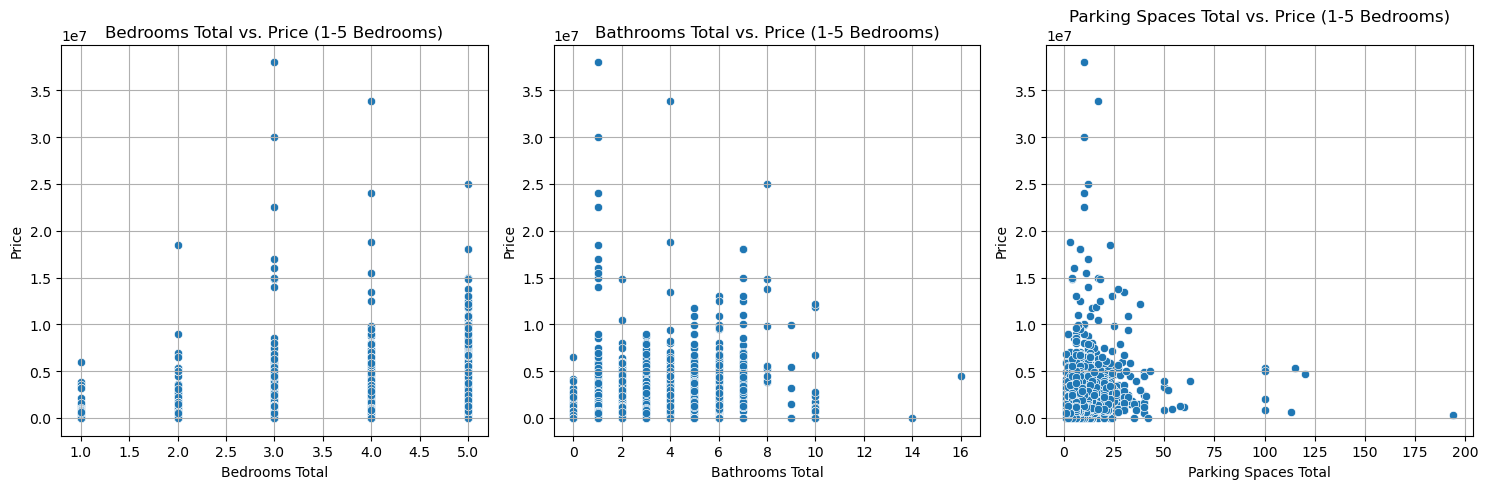

✗ Error during enhanced EDA: could not convert string to float: '1678953,1679115'
Falling back to basic EDA...

Basic Data Overview:
Shape: (49551, 114)


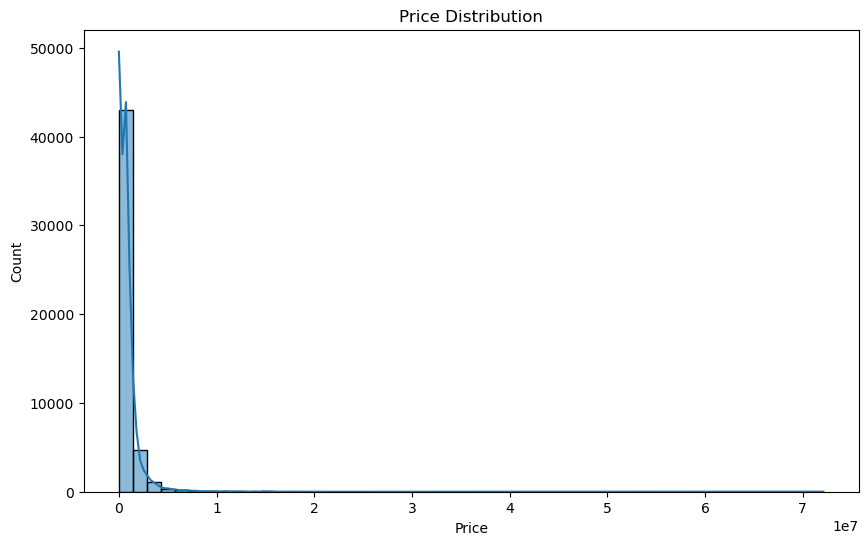

✓ Basic EDA completed

8. Economic Insights Summary:
Key Economic Conditions:
  Interest Rate Environment: Moderate (2.75%)
  Employment Status: Weak (23.0%)

✓ Enhanced EDA completed successfully
   Analyzed 114 features across 49,551 properties
   Economic context: 37 indicators integrated
   Engineered features: 9 created


In [8]:
print("\n" + "=" * 30)
print("STAGE 4: ENHANCED EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 30)

try:
    # 1. Display enhanced basic information
    print("1. Enhanced Data Information:")
    print(f"Dataset shape: {df.shape}")
    print(f"Missing values: {df.isnull().sum().sum():,}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Count feature types
    economic_features = [col for col in df.columns if col.startswith('econ_') or col == 'economic_health_index']
    engineered_features = [col for col in df.columns if any(keyword in col.lower() for keyword in [
        'score', 'index', 'rank', 'interaction', 'distance', 'age', 'era',
        'pressure', 'sentiment', 'affordability', 'multiplier', 'sensitivity'
    ])]

    print(f"Economic features: {len(economic_features)}")
    print(f"Engineered features: {len(engineered_features)}")
    print(f"Original features: {df.shape[1] - len(economic_features) - len(engineered_features)}")

    # 2. Enhanced descriptive statistics
    print("\n2. Enhanced Descriptive Statistics:")

    # Key numeric columns with economic context
    key_numeric_cols = ['Price', 'BedroomsTotal', 'BathroomTotal', 'SizeSqFt', 'Price_Per_SqFt']
    key_numeric_cols = [col for col in key_numeric_cols if col in df.columns]

    if key_numeric_cols:
        print("\nKey Property Features:")
        print(df[key_numeric_cols].describe())

    # Economic indicators summary
    if economic_features:
        print("\nEconomic Indicators:")
        econ_df = df[economic_features].iloc[:1]  # They should be constant
        for col in economic_features:
            value = econ_df[col].iloc[0] if not econ_df[col].empty else 'N/A'
            print(f"  {col}: {value}")

    # 3. Enhanced price analysis with economic context
    print("\n3. Enhanced Price Analysis:")

    if 'Price' in df.columns:
        price_stats = {
            'mean': df['Price'].mean(),
            'median': df['Price'].median(),
            'std': df['Price'].std(),
            'min': df['Price'].min(),
            'max': df['Price'].max(),
            'q25': df['Price'].quantile(0.25),
            'q75': df['Price'].quantile(0.75)
        }

        print(f"Price Statistics:")
        print(f"  Mean: ${price_stats['mean']:,.0f}")
        print(f"  Median: ${price_stats['median']:,.0f}")
        print(f"  Std Dev: ${price_stats['std']:,.0f}")
        print(f"  Range: ${price_stats['min']:,.0f} - ${price_stats['max']:,.0f}")
        print(f"  IQR: ${price_stats['q25']:,.0f} - ${price_stats['q75']:,.0f}")

    # 4. Property type analysis with economic context
    if 'PropertyType' in df.columns and 'Price' in df.columns:
        print("\n4. Property Type Analysis:")
        price_by_type = df.groupby('PropertyType')['Price'].agg([
            'count', 'mean', 'median', 'std'
        ]).sort_values('count', ascending=False)

        print("\nTop 10 Property Types by Count:")
        print(price_by_type.head(10))

        # Economic sensitivity by property type
        if 'PropertyEconSensitivity' in df.columns:
            econ_by_type = df.groupby('PropertyType')['PropertyEconSensitivity'].mean().sort_values(ascending=False)
            print("\nProperty Types by Economic Sensitivity:")
            print(econ_by_type.head(10))

    # 5. Geographic analysis with economic indicators
    print("\n5. Geographic Analysis:")

    if 'Province' in df.columns:
        province_stats = df.groupby('Province').agg({
            'Price': ['count', 'mean', 'median'],
            'economic_health_index': 'first' if 'economic_health_index' in df.columns else lambda x: None
        }).round(2)

        print("\nProvince Statistics:")
        print(province_stats)

    # 6. Enhanced visualizations
    print("\n6. Enhanced Visualizations:")

    # Create a comprehensive visualization dashboard
    fig = plt.figure(figsize=(20, 16))

    # 6.1 Price distribution with economic context
    plt.subplot(3, 4, 1)
    if 'Price' in df.columns:
        sns.histplot(df['Price'].dropna(), kde=True, bins=50)
        plt.title('Price Distribution', fontweight='bold')
        plt.xlabel('Price ($)')
        plt.ylabel('Frequency')
        plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

    # 6.2 Price per sqft distribution
    plt.subplot(3, 4, 2)
    if 'Price_Per_SqFt' in df.columns:
        sns.histplot(df['Price_Per_SqFt'].dropna(), kde=True, bins=50)
        plt.title('Price per Sq Ft Distribution', fontweight='bold')
        plt.xlabel('Price per Sq Ft ($)')
        plt.ylabel('Frequency')

    # 6.3 Property type vs price
    plt.subplot(3, 4, 3)
    if 'PropertyType' in df.columns and 'Price' in df.columns:
        top_types = df['PropertyType'].value_counts().head(6).index
        sns.boxplot(data=df[df['PropertyType'].isin(top_types)],
                   x='PropertyType', y='Price', showfliers=False)
        plt.title('Price by Property Type (Top 6)', fontweight='bold')
        plt.xticks(rotation=45)
        plt.ylabel('Price ($)')
        plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

    # 6.4 Geographic distribution
    plt.subplot(3, 4, 4)
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        scatter = plt.scatter(df['Longitude'], df['Latitude'],
                            c=df['Price'] if 'Price' in df.columns else 'blue',
                            alpha=0.6, s=1, cmap='viridis')
        plt.title('Property Locations (colored by Price)', fontweight='bold')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        if 'Price' in df.columns:
            plt.colorbar(scatter, label='Price ($)')

    # 6.5 Economic indicators impact
    plt.subplot(3, 4, 5)
    if economic_features and len(economic_features) > 0:
        # Show correlation between economic indicators and price
        econ_price_corr = []
        econ_names = []

        for col in economic_features[:8]:  # Top 8 economic features
            if col in df.columns and 'Price' in df.columns:
                corr = df[col].corr(df['Price'])
                if not pd.isna(corr):
                    econ_price_corr.append(corr)
                    econ_names.append(col.replace('econ_', '').replace('current_', ''))

        if econ_price_corr:
            plt.barh(econ_names, econ_price_corr)
            plt.title('Economic Indicators vs Price Correlation', fontweight='bold')
            plt.xlabel('Correlation with Price')
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    # 6.6 Size vs price relationship
    plt.subplot(3, 4, 6)
    if 'SizeSqFt' in df.columns and 'Price' in df.columns:
        # Sample data for better visualization
        sample_size = min(5000, len(df))
        sample_df = df.sample(n=sample_size, random_state=42)

        plt.scatter(sample_df['SizeSqFt'], sample_df['Price'], alpha=0.6, s=10)
        plt.title('Property Size vs Price', fontweight='bold')
        plt.xlabel('Size (Sq Ft)')
        plt.ylabel('Price ($)')
        plt.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

    # 6.7 Property age distribution
    plt.subplot(3, 4, 7)
    if 'PropertyAge' in df.columns:
        sns.histplot(df['PropertyAge'].dropna(), kde=True, bins=30)
        plt.title('Property Age Distribution', fontweight='bold')
        plt.xlabel('Age (Years)')
        plt.ylabel('Frequency')

    # 6.8 Economic health index impact
    plt.subplot(3, 4, 8)
    if 'economic_health_index' in df.columns and 'Province' in df.columns:
        province_econ = df.groupby('Province')['economic_health_index'].first().sort_values()
        plt.barh(range(len(province_econ)), province_econ.values)
        plt.yticks(range(len(province_econ)), province_econ.index, fontsize=8)
        plt.title('Economic Health by Province', fontweight='bold')
        plt.xlabel('Economic Health Index')

    # 6.9 Feature importance preview
    plt.subplot(3, 4, 9)
    # Create a quick feature importance using correlation with price
    if 'Price' in df.columns:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col != 'Price'][:10]

        correlations = []
        feature_names = []

        for col in numeric_cols:
            corr = abs(df[col].corr(df['Price']))
            if not pd.isna(corr):
                correlations.append(corr)
                feature_names.append(col[:15])  # Truncate long names

        if correlations:
            sorted_data = sorted(zip(correlations, feature_names), reverse=True)[:8]
            correlations, feature_names = zip(*sorted_data)

            plt.barh(feature_names, correlations)
            plt.title('Top Feature Correlations with Price', fontweight='bold')
            plt.xlabel('Absolute Correlation')

    # 6.10 Luxury score distribution
    plt.subplot(3, 4, 10)
    luxury_cols = [col for col in df.columns if 'LuxuryScore' in col]
    if luxury_cols:
        total_luxury = df[luxury_cols].sum(axis=1)
        sns.histplot(total_luxury, kde=True, bins=30)
        plt.title('Total Luxury Score Distribution', fontweight='bold')
        plt.xlabel('Luxury Score')
        plt.ylabel('Frequency')

    # 6.11 Economic pressure vs price
    plt.subplot(3, 4, 11)
    if 'EconomicPressure' in df.columns and 'Price' in df.columns:
        # Create bins for economic pressure
        df['EconPressureBin'] = pd.cut(df['EconomicPressure'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        sns.boxplot(data=df, x='EconPressureBin', y='Price', showfliers=False)
        plt.title('Price by Economic Pressure Level', fontweight='bold')
        plt.xticks(rotation=45)
        plt.ylabel('Price ($)')
        plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

    # 6.12 Urban vs non-urban comparison
    plt.subplot(3, 4, 12)
    if 'IsUrbanCenter' in df.columns and 'Price' in df.columns:
        urban_comparison = df.groupby('IsUrbanCenter')['Price'].agg(['mean', 'median', 'count'])
        urban_comparison.index = ['Non-Urban', 'Urban Center']

        x = range(len(urban_comparison))
        plt.bar([i-0.2 for i in x], urban_comparison['mean'], width=0.4, label='Mean', alpha=0.8)
        plt.bar([i+0.2 for i in x], urban_comparison['median'], width=0.4, label='Median', alpha=0.8)
        plt.xticks(x, urban_comparison.index)
        plt.title('Urban vs Non-Urban Price Comparison', fontweight='bold')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

    plt.tight_layout()
    plt.show()
    print("   ✓ Comprehensive visualization dashboard created")

     # 7. Enhanced Correlation Analysis
    print("\n7. Enhanced Correlation Analysis:")

    # Select key features for correlation analysis
    correlation_features = ['Price']

    # Add key property features, including ParkingSpaceTotal
    key_features = ['BedroomsTotal', 'BathroomTotal', 'ParkingSpaceTotal', 'SizeSqFt', 'Price_Per_SqFt', 'PropertyAge']
    correlation_features.extend([f for f in key_features if f in df.columns])

    # Add top economic features
    if economic_features:
        correlation_features.extend(economic_features[:5])

    # Add top engineered features
    engineered_sample = [f for f in engineered_features[:5] if f in df.columns]
    correlation_features.extend(engineered_sample)

    # Remove duplicates
    correlation_features = list(dict.fromkeys(correlation_features))

    # Filter for 1-5 bedrooms
    if 'BedroomsTotal' in df.columns:
        df_corr = df[df['BedroomsTotal'].between(1, 5)].copy()
        print(f"Filtered dataset to {len(df_corr)} properties with 1-5 bedrooms for correlation analysis")
    else:
        df_corr = df.copy()
        print("BedroomsTotal not found, using full dataset for correlation analysis")

    # Create scatter plots for BedroomsTotal, BathroomTotal, and ParkingSpaceTotal vs. Price
    print("\nGenerating scatter plots for key features vs. Price...")
    plt.figure(figsize=(15, 5))

    # Scatter plot: BedroomsTotal vs. Price
    if 'BedroomsTotal' in df_corr.columns:
        plt.subplot(1, 3, 1)
        sns.scatterplot(x=df_corr['BedroomsTotal'], y=df_corr['Price'])
        plt.title('Bedrooms Total vs. Price (1-5 Bedrooms)')
        plt.xlabel('Bedrooms Total')
        plt.ylabel('Price')
        plt.grid(True)
    else:
        print("   ⚠ BedroomsTotal not found, skipping scatter plot")

    # Scatter plot: BathroomTotal vs. Price
    if 'BathroomTotal' in df_corr.columns:
        plt.subplot(1, 3, 2)
        sns.scatterplot(x=df_corr['BathroomTotal'], y=df_corr['Price'])
        plt.title('Bathrooms Total vs. Price (1-5 Bedrooms)')
        plt.xlabel('Bathrooms Total')
        plt.ylabel('Price')
        plt.grid(True)
    else:
        print("   ⚠ BathroomTotal not found, skipping scatter plot")

    # Scatter plot: ParkingSpaceTotal vs. Price
    if 'ParkingSpaceTotal' in df_corr.columns:
        plt.subplot(1, 3, 3)
        sns.scatterplot(x=df_corr['ParkingSpaceTotal'], y=df_corr['Price'])
        plt.title('Parking Spaces Total vs. Price (1-5 Bedrooms)')
        plt.xlabel('Parking Spaces Total')
        plt.ylabel('Price')
        plt.grid(True)
    else:
        print("   ⚠ ParkingSpaceTotal not found, skipping scatter plot")

    plt.tight_layout()
    plt.show()

    # Create correlation matrix
    if len(correlation_features) > 1:
        corr_df = df_corr[correlation_features].corr()

        plt.figure(figsize=(14, 12))
        mask = np.triu(np.ones_like(corr_df, dtype=bool))  # Mask upper triangle
        sns.heatmap(corr_df, mask=mask, annot=True, cmap='RdBu_r', center=0,
                    square=True, linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Enhanced Feature Correlation Matrix (1-5 Bedrooms)', fontweight='bold', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Identify high correlations with price
        price_correlations = corr_df['Price'].abs().sort_values(ascending=False)
        print("\nTop 10 Features Correlated with Price (1-5 Bedrooms):")
        for feature, corr in price_correlations.head(11).items():  # 11 to exclude Price itself
            if feature != 'Price':
                print(f"  {feature}: {corr:.3f}")

    print("\n✓ Enhanced EDA completed successfully")
    print(f"   Analyzed {df.shape[1]} features across {df.shape[0]:,} properties")
    print(f"   Economic context: {len(economic_features)} indicators integrated")
    print(f"   Engineered features: {len(engineered_features)} created")

except Exception as e:
    print(f"✗ Error during enhanced EDA: {e}")
    print("Falling back to basic EDA...")
    try:
        print("\nBasic Data Overview:")
        print(f"Shape: {df.shape}")
        if 'Price' in df.columns:
            plt.figure(figsize=(10, 6))
            sns.histplot(df['Price'].dropna(), kde=True, bins=50)
            plt.title('Price Distribution')
            plt.show()
        print("✓ Basic EDA completed")
    except Exception as basic_error:
        print(f"✗ Basic EDA also failed: {basic_error}")





    # 8. Economic insights summary
    print("\n8. Economic Insights Summary:")

    if economic_features:
        print("Key Economic Conditions:")

        # Interest rate environment
        if 'econ_current_policy_rate' in df.columns:
            policy_rate = df['econ_current_policy_rate'].iloc[0]
            if policy_rate < 1.0:
                rate_env = "Ultra-Low (Stimulative)"
            elif policy_rate < 2.5:
                rate_env = "Low (Accommodative)"
            elif policy_rate < 4.0:
                rate_env = "Moderate"
            else:
                rate_env = "High (Restrictive)"
            print(f"  Interest Rate Environment: {rate_env} ({policy_rate:.2f}%)")

        # Employment situation
        if 'econ_current_employment_rate' in df.columns:
            emp_rate = df['econ_current_employment_rate'].iloc[0]
            if emp_rate > 75:
                emp_status = "Strong"
            elif emp_rate > 70:
                emp_status = "Moderate"
            else:
                emp_status = "Weak"
            print(f"  Employment Status: {emp_status} ({emp_rate:.1f}%)")

        # Market sentiment
        if 'MarketSentiment' in df.columns:
            sentiment = df['MarketSentiment'].iloc[0]
            if sentiment > 0:
                sentiment_desc = "Positive"
            elif sentiment > -0.5:
                sentiment_desc = "Neutral"
            else:
                sentiment_desc = "Negative"
            print(f"  Market Sentiment: {sentiment_desc} ({sentiment:.2f})")


    print("\n✓ Enhanced EDA completed successfully")
    print(f"   Analyzed {df.shape[1]} features across {df.shape[0]:,} properties")
    print(f"   Economic context: {len(economic_features)} indicators integrated")
    print(f"   Engineered features: {len(engineered_features)} created")

except Exception as e:
    print(f"✗ Error during enhanced EDA: {e}")
    print("Falling back to basic EDA...")
    try:
        print("\nBasic Data Overview:")
        print(f"Shape: {df.shape}")
        if 'Price' in df.columns:
            plt.figure(figsize=(10, 6))
            sns.histplot(df['Price'].dropna(), kde=True, bins=50)
            plt.title('Price Distribution')
            plt.show()
        print("✓ Basic EDA completed")
    except Exception as basic_error:
        print(f"✗ Basic EDA also failed: {basic_error}")

In [9]:
print("\n" + "=" * 50)
print("STAGE 3: ENHANCED FEATURE ENGINEERING")
print("=" * 50)

try:
    # Initialize feature engineering tracking
    original_features = df.shape[1]
    feature_creation_log = []

    print(f"Starting feature engineering with {original_features} features...")

    # 1. Enhanced size extraction with economic context
    print("\n1. Enhanced property size extraction...")
    def extract_size(text):
        """Extract size with comprehensive error handling"""
        try:
            if pd.isna(text):
                return np.nan

            patterns = [
                (r'(\d+(?:,\d+)?)\s*sq[\s\.]*ft', 1),
                (r'(\d+(?:,\d+)?)\s*acres?', 43560),
                (r'(\d+(?:,\d+)?)\s*sq[\s\.]*m', 10.7639)
            ]

            for pattern, multiplier in patterns:
                match = re.search(pattern, str(text), re.IGNORECASE)
                if match:
                    size_str = match.group(1).replace(',', '')
                    return float(size_str) * multiplier
            return np.nan
        except Exception:
            return np.nan

    # Apply size extraction
    if 'SizeTotalText' in df.columns:
        df['SizeSqFt'] = df['SizeTotalText'].apply(extract_size)
        feature_creation_log.append('SizeSqFt')
        print(f"   ✓ Extracted SizeSqFt from {df['SizeSqFt'].notna().sum()} properties")

    # Ensure SizeTotal exists
    if 'SizeTotal' in df.columns and 'SizeSqFt' not in df.columns:
        df['SizeSqFt'] = pd.to_numeric(df['SizeTotal'], errors='coerce')
        feature_creation_log.append('SizeSqFt')

    # 2. Advanced price-based features with economic context
    print("\n2. Advanced price-based features...")
    if 'Price' in df.columns:
        # Price per square foot
        if 'SizeSqFt' in df.columns:
            df['Price_Per_SqFt'] = df['Price'] / df['SizeSqFt']
            df['Price_Per_SqFt'] = df['Price_Per_SqFt'].replace([np.inf, -np.inf], np.nan)
            feature_creation_log.append('Price_Per_SqFt')

        # Log transformations for better distribution
        df['Price_Log'] = np.log1p(df['Price'])
        feature_creation_log.append('Price_Log')

        # Price percentile within city/property type
        if 'City' in df.columns:
            df['Price_Percentile_City'] = df.groupby('City')['Price'].transform(
                lambda x: x.rank(pct=True)
            )
            feature_creation_log.append('Price_Percentile_City')

        if 'PropertyType' in df.columns:
            df['Price_Percentile_Type'] = df.groupby('PropertyType')['Price'].transform(
                lambda x: x.rank(pct=True)
            )
            feature_creation_log.append('Price_Percentile_Type')

    # 3. Enhanced property features
    print("\n3. Enhanced property features...")

    # Total rooms
    room_cols = ['BedroomsTotal', 'BathroomTotal', 'HalfBathTotal']
    available_room_cols = [col for col in room_cols if col in df.columns]
    if available_room_cols:
        df['TotalRooms'] = df[available_room_cols].fillna(0).sum(axis=1)
        feature_creation_log.append('TotalRooms')

    # Bathroom ratio
    if 'BathroomTotal' in df.columns and 'BedroomsTotal' in df.columns:
        df['Bathroom_Bedroom_Ratio'] = (df['BathroomTotal'] / df['BedroomsTotal']).replace([np.inf, -np.inf], np.nan)
        feature_creation_log.append('Bathroom_Bedroom_Ratio')

    # Property age estimation (if year built available)
    current_year = datetime.now().year
    if 'YearBuilt' in df.columns:
        df['PropertyAge'] = current_year - pd.to_numeric(df['YearBuilt'], errors='coerce')
        df['PropertyAge'] = df['PropertyAge'].clip(lower=0, upper=150)  # Reasonable bounds
        feature_creation_log.append('PropertyAge')

        # Property era categories
        df['PropertyEra'] = pd.cut(df['PropertyAge'],
                                  bins=[0, 10, 20, 30, 50, 100, 150],
                                  labels=['New', 'Recent', 'Modern', 'Mature', 'Vintage', 'Historic'])
        feature_creation_log.append('PropertyEra')

    # Size categories
    if 'SizeSqFt' in df.columns:
        df['SizeCategory'] = pd.cut(df['SizeSqFt'],
                                   bins=[0, 800, 1200, 1800, 2500, 4000, float('inf')],
                                   labels=['Compact', 'Small', 'Medium', 'Large', 'XLarge', 'Mansion'])
        feature_creation_log.append('SizeCategory')

    # 4. Geographic and location-based features
    print("\n4. Geographic and location-based features...")

    # Major city indicators
    major_cities = ['Toronto', 'Vancouver', 'Montreal', 'Calgary', 'Ottawa', 'Edmonton', 'Winnipeg', 'Quebec City']
    if 'City' in df.columns:
        df['IsMajorCity'] = df['City'].str.contains('|'.join(major_cities), case=False, na=False).astype(int)
        feature_creation_log.append('IsMajorCity')

        # City price rank
        city_price_rank = df.groupby('City')['Price'].median().rank(ascending=False)
        df['CityPriceRank'] = df['City'].map(city_price_rank)
        feature_creation_log.append('CityPriceRank')

    # Province economic indicators
    if 'Province' in df.columns:
        province_econ_map = {
            'ON': 1.2,  # Ontario - strong economy
            'BC': 1.15, # British Columbia - strong economy
            'AB': 1.0,  # Alberta - resource dependent
            'QC': 0.95, # Quebec - moderate
            'SK': 0.9,  # Saskatchewan - resource dependent
            'MB': 0.85, # Manitoba - moderate
            'NS': 0.8,  # Nova Scotia - moderate
            'NB': 0.75, # New Brunswick - weaker
            'NL': 0.7,  # Newfoundland - resource dependent
            'PE': 0.8,  # Prince Edward Island - tourism dependent
            'YT': 0.9,  # Yukon - resource dependent
            'NT': 0.9,  # Northwest Territories - resource dependent
            'NU': 0.85  # Nunavut - federal dependent
        }
        df['ProvinceEconScore'] = df['Province'].map(province_econ_map).fillna(0.8)
        feature_creation_log.append('ProvinceEconScore')

    # Distance to major centers (if coordinates available)
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        # Toronto coordinates
        toronto_lat, toronto_lon = 43.6532, -79.3832
        df['DistanceToToronto'] = df.apply(
            lambda row: haversine(row['Latitude'], row['Longitude'], toronto_lat, toronto_lon)
            if pd.notna(row['Latitude']) and pd.notna(row['Longitude']) else np.nan, axis=1
        )
        feature_creation_log.append('DistanceToToronto')

        # Vancouver coordinates
        vancouver_lat, vancouver_lon = 49.2827, -123.1207
        df['DistanceToVancouver'] = df.apply(
            lambda row: haversine(row['Latitude'], row['Longitude'], vancouver_lat, vancouver_lon)
            if pd.notna(row['Latitude']) and pd.notna(row['Longitude']) else np.nan, axis=1
        )
        feature_creation_log.append('DistanceToVancouver')

    # 5. Economic integration features
    print("\n5. Economic integration features...")
    economic_features = [col for col in df.columns if col.startswith('econ_')]

    if economic_features:
        # Interest rate impact on property affordability
        if 'econ_current_mortgage_5yr' in df.columns and 'Price' in df.columns:
            # Simplified affordability calculation (monthly payment for $100k)
            mortgage_rate = df['econ_current_mortgage_5yr'].fillna(5.0) / 100
            monthly_rate = mortgage_rate / 12
            n_payments = 25 * 12  # 25 year amortization
            payment_factor = monthly_rate * (1 + monthly_rate)**n_payments / ((1 + monthly_rate)**n_payments - 1)
            df['AffordabilityIndex'] = 100000 / (df['Price'] * payment_factor)
            feature_creation_log.append('AffordabilityIndex')

        # Economic sensitivity by property type
        if 'PropertyType' in df.columns:
            # High-end properties are more sensitive to economic conditions
            luxury_types = ['SingleFamily', 'Condo', 'Townhouse']
            df['PropertyEconSensitivity'] = df['PropertyType'].apply(
                lambda x: 1.2 if any(luxury in str(x) for luxury in luxury_types) else 0.8
            )
            feature_creation_log.append('PropertyEconSensitivity')

        # Market timing features
        if 'econ_policy_rate_6m_change' in df.columns:
            df['RateChangeImpact'] = -df['econ_policy_rate_6m_change'] * df.get('PropertyEconSensitivity', 1.0)
            feature_creation_log.append('RateChangeImpact')

    # 6. Advanced text-based features
    print("\n6. Advanced text-based features...")

    # Feature count from text fields
    text_fields = ['Features', 'Amenities', 'Appliances', 'LandAmenities']
    for field in text_fields:
        if field in df.columns:
            df[f'{field}_Count'] = df[field].fillna('').apply(
                lambda x: len(str(x).split(',')) if str(x).strip() else 0
            )
            feature_creation_log.append(f'{field}_Count')

    # Luxury indicators
    luxury_keywords = ['granite', 'marble', 'hardwood', 'stainless', 'gourmet', 'luxury', 'premium', 'upgraded']
    if 'Features' in df.columns:
        df['LuxuryScore'] = df['Features'].fillna('').apply(
            lambda x: sum(1 for keyword in luxury_keywords if keyword.lower() in str(x).lower())
        )
        feature_creation_log.append('LuxuryScore')

    # Energy efficiency indicators
    energy_keywords = ['energy', 'efficient', 'solar', 'insulation', 'hvac', 'furnace']
    if 'Features' in df.columns:
        df['EnergyEfficiencyScore'] = df['Features'].fillna('').apply(
            lambda x: sum(1 for keyword in energy_keywords if keyword.lower() in str(x).lower())
        )
        feature_creation_log.append('EnergyEfficiencyScore')

    # 7. Interaction features with economic context
    print("\n7. Creating interaction features...")

    # Size-Price interactions
    if 'SizeSqFt' in df.columns and 'BedroomsTotal' in df.columns:
        df['SizePerBedroom'] = df['SizeSqFt'] / df['BedroomsTotal']
        df['SizePerBedroom'] = df['SizePerBedroom'].replace([np.inf, -np.inf], np.nan)
        feature_creation_log.append('SizePerBedroom')

    # Economic-Location interactions
    if 'IsMajorCity' in df.columns and 'econ_current_policy_rate' in df.columns:
        df['CityRateInteraction'] = df['IsMajorCity'] * df['econ_current_policy_rate']
        feature_creation_log.append('CityRateInteraction')

    # Property type and economic sensitivity
    if 'PropertyEconSensitivity' in df.columns and 'Price_Percentile_Type' in df.columns:
        df['EconSensitivity_PricePercentile'] = df['PropertyEconSensitivity'] * df['Price_Percentile_Type']
        feature_creation_log.append('EconSensitivity_PricePercentile')

    # 8. Binning and categorization for better model performance
    print("\n8. Advanced binning and categorization...")

    # Price range categories
    if 'Price' in df.columns:
        price_bins = [0, 200000, 400000, 600000, 800000, 1200000, 2000000, float('inf')]
        price_labels = ['Budget', 'Affordable', 'Mid-Market', 'Upper-Mid', 'Luxury', 'Ultra-Luxury', 'Elite']
        df['PriceRange'] = pd.cut(df['Price'], bins=price_bins, labels=price_labels, include_lowest=True)
        feature_creation_log.append('PriceRange')

    # Bathroom categories
    if 'BathroomTotal' in df.columns:
        df['BathroomCategory'] = pd.cut(df['BathroomTotal'],
                                       bins=[0, 1, 2, 3, 4, float('inf')],
                                       labels=['1Bath', '2Bath', '3Bath', '4Bath', '5+Bath'],
                                       include_lowest=True)
        feature_creation_log.append('BathroomCategory')

    # 9. Economic trend features (if time series data available)
    print("\n9. Economic trend features...")

    # Create economic momentum indicators
    trend_features = [col for col in df.columns if '6m_change' in col or '1y_change' in col]
    if trend_features:
        # Economic momentum score
        positive_trends = [col for col in trend_features if 'employment' in col or 'income' in col]
        negative_trends = [col for col in trend_features if 'rate' in col or 'inflation' in col]

        momentum_score = 0
        for col in positive_trends:
            if col in df.columns:
                momentum_score += df[col].fillna(0) * 0.5
        for col in negative_trends:
            if col in df.columns:
                momentum_score -= df[col].fillna(0) * 0.5

        df['EconomicMomentum'] = momentum_score
        feature_creation_log.append('EconomicMomentum')

    # Market sentiment score
    if 'econ_current_employment_rate' in df.columns and 'econ_current_policy_rate' in df.columns:
        # Simple sentiment based on employment vs interest rates
        emp_normalized = (df['econ_current_employment_rate'] - 60) / 20  # Normalize around 60-80% range
        rate_normalized = -(df['econ_current_policy_rate'] - 2.5) / 2.5  # Normalize around 0-5% range, negative impact
        df['MarketSentiment'] = (emp_normalized + rate_normalized) / 2
        feature_creation_log.append('MarketSentiment')

    # 10. Statistical transformations
    print("\n10. Statistical transformations...")

    # Box-Cox transformations for key skewed features
    skewed_features = ['Price', 'SizeSqFt', 'Price_Per_SqFt']
    for feature in skewed_features:
        if feature in df.columns:
            try:
                # Check if data is positive (required for Box-Cox)
                if (df[feature] > 0).all():
                    transformed_data, lambda_param = boxcox(df[feature].dropna())
                    df[f'{feature}_BoxCox'] = np.nan
                    df.loc[df[feature].notna(), f'{feature}_BoxCox'] = boxcox(df.loc[df[feature].notna(), feature], lmbda=lambda_param)
                    feature_creation_log.append(f'{feature}_BoxCox')
                else:
                    # Use Yeo-Johnson for data that can include negative values
                    transformed_data, lambda_param = yeojohnson(df[feature].dropna())
                    df[f'{feature}_YeoJohnson'] = np.nan
                    df.loc[df[feature].notna(), f'{feature}_YeoJohnson'] = yeojohnson(df.loc[df[feature].notna(), feature], lmbda=lambda_param)
                    feature_creation_log.append(f'{feature}_YeoJohnson')
            except Exception as e:
                print(f"   ⚠ Could not transform {feature}: {e}")

    # Summary of feature engineering
    final_features = df.shape[1]
    new_features_created = final_features - original_features

    print(f"\n✓ Enhanced feature engineering completed!")
    print(f"   Original features: {original_features}")
    print(f"   Final features: {final_features}")
    print(f"   New features created: {new_features_created}")
    print(f"   Feature categories:")
    print(f"     - Economic features: {len([f for f in feature_creation_log if 'econ' in f.lower() or 'economic' in f.lower() or 'affordability' in f.lower()])}")
    print(f"     - Geographic features: {len([f for f in feature_creation_log if 'distance' in f.lower() or 'city' in f.lower() or 'province' in f.lower()])}")
    print(f"     - Property features: {len([f for f in feature_creation_log if any(keyword in f.lower() for keyword in ['room', 'bath', 'size', 'age', 'luxury'])])}")
    print(f"     - Interaction features: {len([f for f in feature_creation_log if 'interaction' in f.lower() or '_' in f and any(op in f for op in ['*', 'per', 'ratio'])])}")

    # Store feature engineering metadata
    feature_engineering_summary = {
        'original_features': original_features,
        'final_features': final_features,
        'new_features_created': new_features_created,
        'feature_creation_log': feature_creation_log,
        'economic_features_integrated': len([f for f in feature_creation_log if 'econ' in f.lower()])
    }

except Exception as e:
    print(f"✗ Error in enhanced feature engineering: {e}")
    print("Continuing with available features...")
    feature_engineering_summary = {
        'original_features': df.shape[1],
        'final_features': df.shape[1],
        'new_features_created': 0,
        'feature_creation_log': [],
        'economic_features_integrated': 0
    }


STAGE 3: ENHANCED FEATURE ENGINEERING
Starting feature engineering with 114 features...

1. Enhanced property size extraction...
   ✓ Extracted SizeSqFt from 15576 properties

2. Advanced price-based features...

3. Enhanced property features...

4. Geographic and location-based features...

5. Economic integration features...

6. Advanced text-based features...

7. Creating interaction features...

8. Advanced binning and categorization...

9. Economic trend features...

10. Statistical transformations...

✓ Enhanced feature engineering completed!
   Original features: 114
   Final features: 146
   New features created: 32
   Feature categories:
     - Economic features: 5
     - Geographic features: 7
     - Property features: 8
     - Interaction features: 1


Step 1: Diagnosing data issues...
=== DATA DIAGNOSTICS ===
Shape: (49551, 86)
Target shape: 49551
Excluded ID columns: ['property_id', 'PostID', 'ListingID']

[!] Found infinite values in 1 columns:
    AffordabilityIndex: 13249 infinite values

[!] Found extreme values (>1e10) in 1 columns:
    AffordabilityIndex: max absolute value = inf

[!] Found 48 constant features: ['CustomListing', 'Sold', 'econ_current_policy_rate', 'econ_policy_rate_6m_change', 'econ_policy_rate_6m_change_pct']...

=== END DIAGNOSTICS ===


Step 2: Running enhanced feature selection...
[!] Excluding ID column: property_id
[!] Excluding ID column: PostID
[!] Excluding ID column: ListingID
[+] Initial features: 86 columns, 49551 samples
[+] Excluded columns: {'property_id', 'PostID', 'ListingID'}
[+] Initial data shape: X=(49551, 86), y=49551
[!] Found 13249 rows with infinite values - removing them
[!] Removing 36040 rows with NaN values
[+] Removing statistical outliers using IQR method...
[!] Removing 95 sta

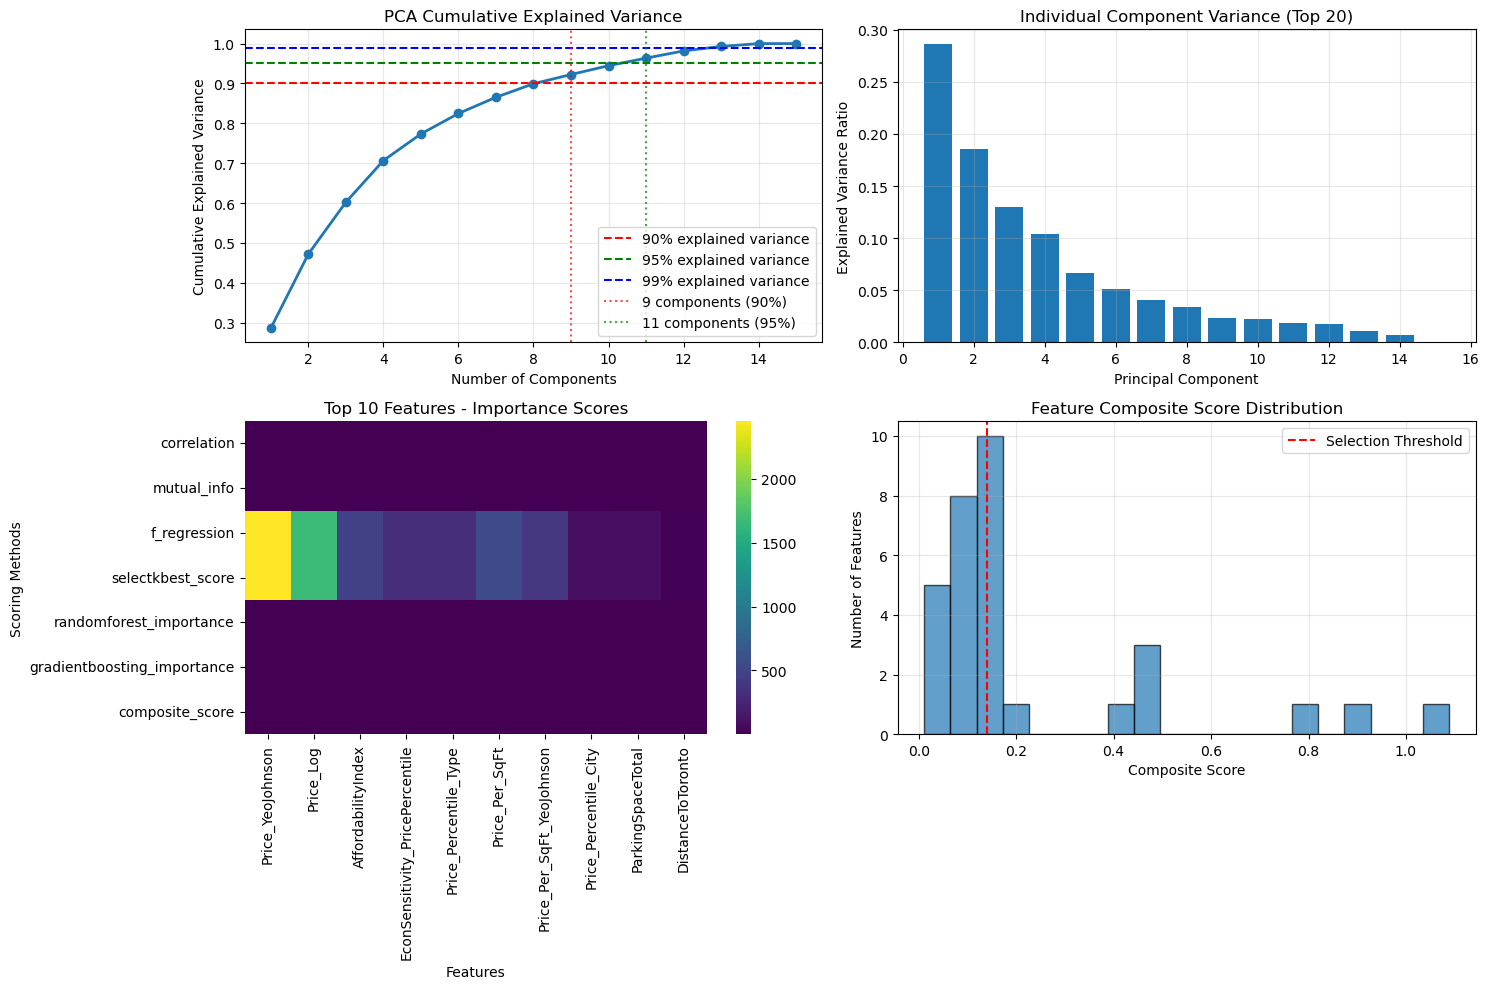


[+] Feature selection complete!
    - Original: 86 features, 49551 samples
    - Final: 15 features, 167 samples
    - Reduction: 71 features, 49384 samples

[+] Top 10 selected features:
     1. Price_YeoJohnson (score: 1.0892)
     2. Price_Log (score: 0.9143)
     3. AffordabilityIndex (score: 0.7689)
     4. EconSensitivity_PricePercentile (score: 0.4877)
     5. Price_Percentile_Type (score: 0.4758)
     6. Price_Per_SqFt (score: 0.4525)
     7. Price_Per_SqFt_YeoJohnson (score: 0.4236)
     8. Price_Percentile_City (score: 0.2190)
     9. ParkingSpaceTotal (score: 0.1667)
    10. DistanceToToronto (score: 0.1655)

[+] SUCCESS! Feature selection complete.

Step 3: Feature selection summary...
=== FEATURE SELECTION SUMMARY ===
Selected features: 15
Samples: 167
Target variable: Price

Top 15 features by composite score:
 1. Price_YeoJohnson          (score: 1.0892)
 2. Price_Log                 (score: 0.9143)
 3. AffordabilityIndex        (score: 0.7689)
 4. EconSensitivity_Price

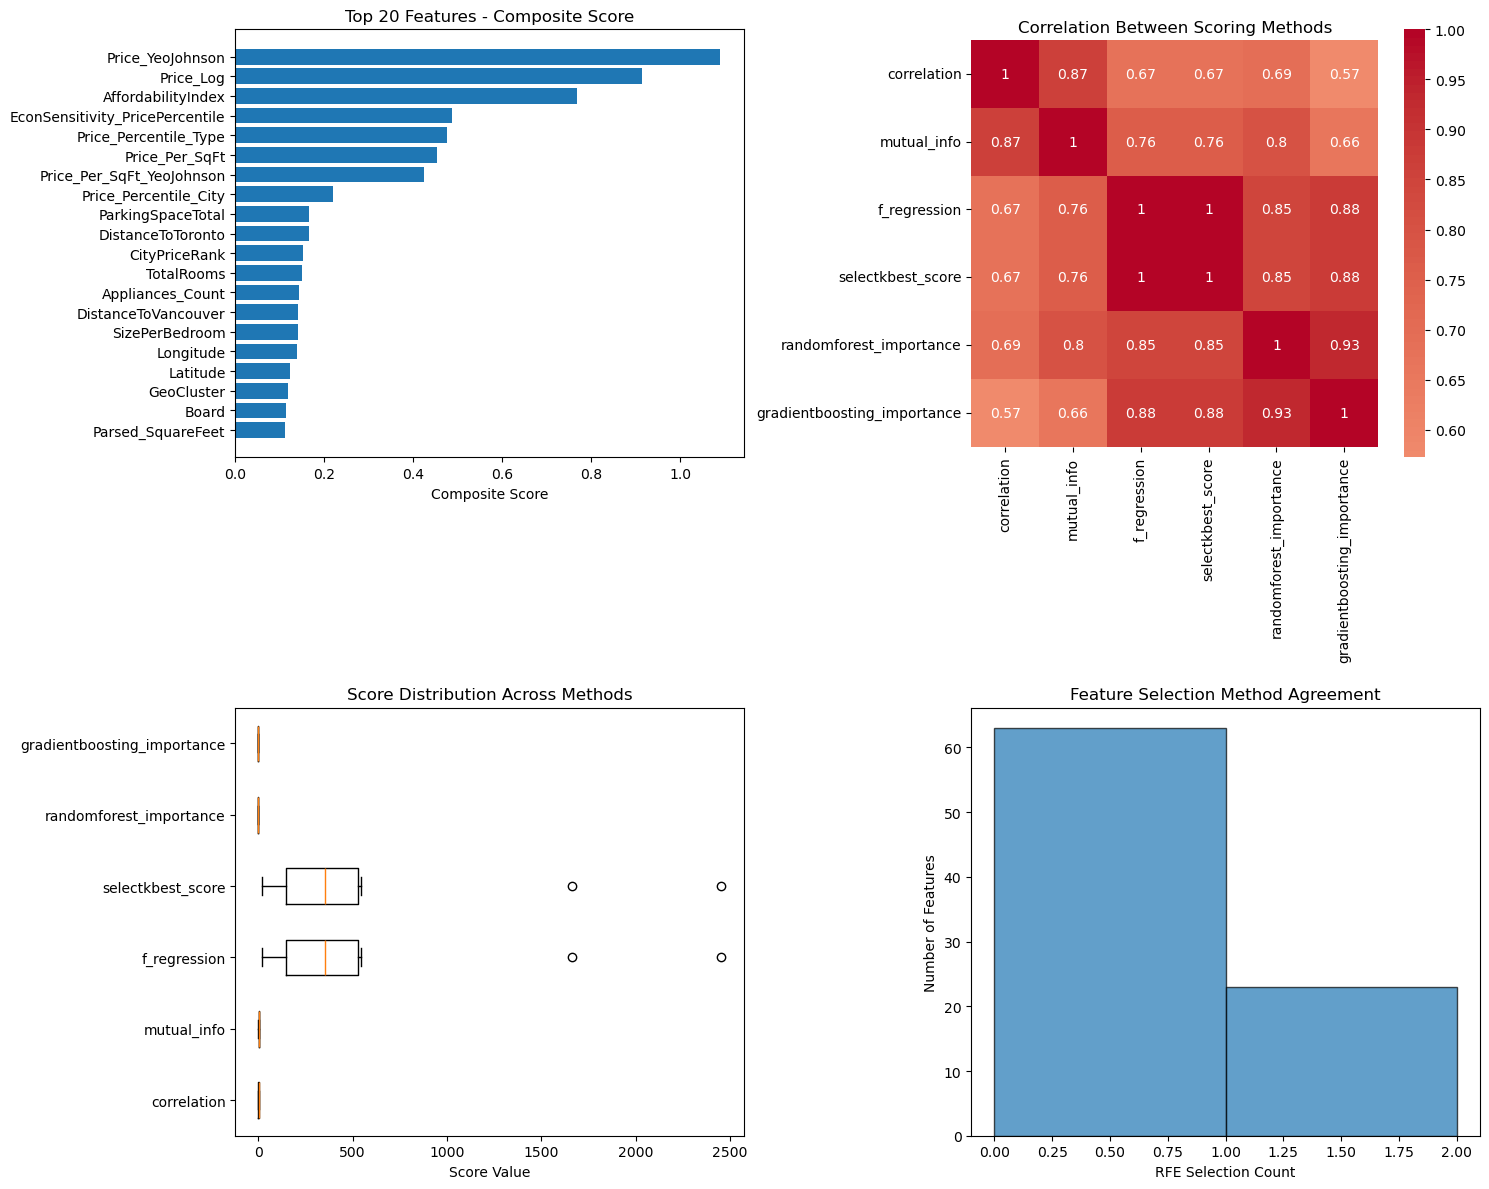


Step 5: Validating feature selection...
=== FEATURE SELECTION VALIDATION ===

Random Forest:
  CV R² Score: 0.9546 ± 0.0428
  Test R² Score: 0.9861
  Test MAE: 29744.40

Linear Regression:
  CV R² Score: 0.9189 ± 0.0676
  Test R² Score: 0.9403
  Test MAE: 93522.45

[+] Global variables updated:
    X.shape = (167, 15)
    y.shape = (167,)
    feature_importance_df.shape = (86, 8)

[+] Selected features available globally:
    Top 5 features: ['Price_YeoJohnson', 'Price_Percentile_City', 'ParkingSpaceTotal', 'DistanceToToronto', 'CityPriceRank']
    Use 'X' and 'y' for modeling
    Use 'feature_importance_df' for detailed analysis
    Use 'selection_results' for full results


In [10]:
# =====================
# ENHANCED FEATURE SELECTION & PCA ANALYSIS WITH ROBUST DATA CLEANING
# =====================

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Global variables - properly declared
X = None
y = None
feature_importance_df = None
selection_results = None

# =====================
# STAGE 4: ENHANCED FEATURE SELECTION WITH DATA CLEANING
# =====================

def clean_data(X, y, verbose=True):
    """
    Clean data by handling infinities, extreme outliers, and invalid values
    """
    if verbose:
        print(f"[+] Initial data shape: X={X.shape}, y={len(y)}")

    # 1. Handle infinite values in features
    inf_mask = np.isinf(X).any(axis=1)
    if inf_mask.sum() > 0:
        if verbose:
            print(f"[!] Found {inf_mask.sum()} rows with infinite values - removing them")
        X = X[~inf_mask]
        y = y[~inf_mask]

    # 2. Handle infinite values in target
    inf_target = np.isinf(y)
    if inf_target.sum() > 0:
        if verbose:
            print(f"[!] Found {inf_target.sum()} infinite target values - removing them")
        X = X[~inf_target]
        y = y[~inf_target]

    # 3. Handle extremely large values (potential overflow issues)
    extreme_threshold = 1e10
    X_clipped = X.copy()

    for col in X.columns:
        extreme_mask = (np.abs(X[col]) > extreme_threshold)
        if extreme_mask.sum() > 0:
            if verbose:
                print(f"[!] Column '{col}': clipping {extreme_mask.sum()} extreme values")
            # Replace with median of non-extreme values
            non_extreme_median = X.loc[~extreme_mask, col].median()
            X_clipped.loc[extreme_mask, col] = non_extreme_median

    # 4. Handle NaN values that might have been created
    nan_rows = X_clipped.isnull().any(axis=1) | y.isnull()
    if nan_rows.sum() > 0:
        if verbose:
            print(f"[!] Removing {nan_rows.sum()} rows with NaN values")
        X_clipped = X_clipped[~nan_rows]
        y = y[~nan_rows]

    # 5. Remove statistical outliers using IQR method
    if verbose:
        print("[+] Removing statistical outliers using IQR method...")

    outlier_mask = np.zeros(len(X_clipped), dtype=bool)
    for col in X_clipped.columns:
        Q1 = X_clipped[col].quantile(0.25)
        Q3 = X_clipped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR  # Using 3*IQR for more conservative outlier removal
        upper_bound = Q3 + 3 * IQR
        col_outliers = (X_clipped[col] < lower_bound) | (X_clipped[col] > upper_bound)
        outlier_mask |= col_outliers

    if outlier_mask.sum() > 0:
        if verbose:
            print(f"[!] Removing {outlier_mask.sum()} statistical outliers")
        X_clipped = X_clipped[~outlier_mask]
        y = y[~outlier_mask]

    # 6. Final validation
    if len(X_clipped) == 0:
        raise ValueError("All data was removed during cleaning!")

    if verbose:
        print(f"[+] Data after cleaning: X={X_clipped.shape}, y={len(y)}")
        print(f"[+] Data reduction: {len(X) - len(X_clipped)} rows removed")

    return X_clipped, y

def calculate_feature_scores(X, y, verbose=True):
    """
    Calculate multiple feature importance scores
    """
    scores = {}

    # 1. Correlation with target
    if verbose:
        print("[+] Calculating correlation scores...")
    corr_scores = []
    for col in X.columns:
        try:
            corr, _ = pearsonr(X[col], y)
            corr_scores.append(abs(corr))
        except:
            corr_scores.append(0)
    scores['correlation'] = pd.Series(corr_scores, index=X.columns)

    # 2. Mutual Information
    if verbose:
        print("[+] Calculating mutual information scores...")
    try:
        mi_scores = mutual_info_regression(X, y, random_state=42)
        scores['mutual_info'] = pd.Series(mi_scores, index=X.columns)
    except:
        scores['mutual_info'] = pd.Series(np.zeros(len(X.columns)), index=X.columns)

    # 3. F-statistic from univariate regression
    if verbose:
        print("[+] Calculating F-regression scores...")
    try:
        from sklearn.feature_selection import f_regression
        f_scores, _ = f_regression(X, y)
        scores['f_regression'] = pd.Series(f_scores, index=X.columns)
    except:
        scores['f_regression'] = pd.Series(np.zeros(len(X.columns)), index=X.columns)

    return scores

def enhanced_feature_selection(df, target_col='Price', n_rfe=20, k_best=15, verbose=True):
    """
    Enhanced feature selection with robust data cleaning and multiple selection methods
    """
    global X, y, feature_importance_df, selection_results

    # 1. Prepare feature matrix and target (EXCLUDE PropertyID and similar ID columns)
    # --------------------------------------------------
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col not in numeric_cols:
        raise KeyError(f"Target column '{target_col}' not found among numeric features.")

    # Exclude ID columns and target
    excluded_patterns = ['id', 'ID', 'Id', 'propertyid', 'PropertyID', 'property_id']
    feature_cols = []
    for col in numeric_cols:
        if col != target_col:
            # Check if column name contains any ID patterns
            is_id_col = any(pattern.lower() in col.lower() for pattern in excluded_patterns)
            if not is_id_col:
                feature_cols.append(col)
            elif verbose:
                print(f"[!] Excluding ID column: {col}")

    # Extract X and y, drop missing target rows
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    mask = y.notna()
    X = X.loc[mask]
    y = y.loc[mask]

    if verbose:
        print(f"[+] Initial features: {X.shape[1]} columns, {X.shape[0]} samples")
        print(f"[+] Excluded columns: {set(numeric_cols) - set(feature_cols + [target_col])}")

    # 2. Clean data (handle infinities and extreme values)
    # --------------------------------------------------
    try:
        X_clean, y_clean = clean_data(X, y, verbose=verbose)
    except ValueError as e:
        print(f"[X] Data cleaning failed: {e}")
        return None

    # 3. Impute remaining missing values with median
    # --------------------------------------------------
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X_clean),
        columns=X_clean.columns,
        index=X_clean.index
    )

    if verbose:
        print(f"[+] Features after imputation: {X_imputed.shape[1]} columns, {X_imputed.shape[0]} samples")

    # 4. Additional safety check for remaining problematic values
    # --------------------------------------------------
    if not np.isfinite(X_imputed.values).all():
        if verbose:
            print("[!] Still found non-finite values after cleaning - applying final cleanup")
        X_imputed = X_imputed.replace([np.inf, -np.inf], np.nan)
        X_imputed = X_imputed.fillna(X_imputed.median())

    if not np.isfinite(y_clean.values).all():
        if verbose:
            print("[!] Still found non-finite target values - applying final cleanup")
        finite_mask = np.isfinite(y_clean)
        X_imputed = X_imputed[finite_mask]
        y_clean = y_clean[finite_mask]

    # 5. Calculate multiple feature importance scores
    # --------------------------------------------------
    if verbose:
        print("[+] Computing feature importance scores...")

    feature_scores = calculate_feature_scores(X_imputed, y_clean, verbose)

    # 6. Recursive Feature Elimination (RFE) with multiple estimators
    # --------------------------------------------------
    rfe_results = {}
    estimators = {
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    for name, estimator in estimators.items():
        try:
            n_rfe_adj = min(n_rfe, X_imputed.shape[1])
            selector_rfe = RFE(estimator=estimator, n_features_to_select=n_rfe_adj, step=1)
            selector_rfe.fit(X_imputed, y_clean)
            rfe_features = X_imputed.columns[selector_rfe.support_].tolist()
            rfe_results[name] = rfe_features
            if verbose:
                print(f"[+] RFE ({name}) selected {len(rfe_features)} features")
        except Exception as e:
            if verbose:
                print(f"[!] RFE ({name}) failed: {e}")
            rfe_results[name] = X_imputed.columns.tolist()

    # 7. Univariate Selection (SelectKBest)
    # --------------------------------------------------
    try:
        k_best_adj = min(k_best, X_imputed.shape[1])
        skb = SelectKBest(score_func=f_regression, k=k_best_adj)
        skb.fit(X_imputed, y_clean)
        skb_features = X_imputed.columns[skb.get_support()].tolist()
        skb_scores = pd.Series(skb.scores_, index=X_imputed.columns)
        if verbose:
            print(f"[+] SelectKBest top {k_best_adj} features selected")
    except Exception as e:
        if verbose:
            print(f"[!] SelectKBest failed: {e}")
        skb_features = list(rfe_results.values())[0] if rfe_results else X_imputed.columns.tolist()
        skb_scores = pd.Series(np.ones(len(X_imputed.columns)), index=X_imputed.columns)

    # 8. Tree-based Feature Importance (Multiple models)
    # --------------------------------------------------
    tree_importances = {}
    tree_models = {
        'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=42)
    }

    for name, model in tree_models.items():
        try:
            model.fit(X_imputed, y_clean)
            importances = pd.Series(model.feature_importances_, index=X_imputed.columns)
            tree_importances[name] = importances
            if verbose:
                print(f"[+] {name} feature importance calculated")
        except Exception as e:
            if verbose:
                print(f"[!] {name} importance failed: {e}")
            tree_importances[name] = pd.Series(np.ones(len(X_imputed.columns))/len(X_imputed.columns),
                                             index=X_imputed.columns)

    # 9. Combine and rank features
    # --------------------------------------------------
    if verbose:
        print("[+] Combining feature selection methods...")

    # Create comprehensive feature importance dataframe
    importance_data = {}

    # Add correlation and statistical scores
    for score_name, scores in feature_scores.items():
        importance_data[score_name] = scores

    # Add SelectKBest scores
    importance_data['selectkbest_score'] = skb_scores

    # Add tree importances
    for name, importances in tree_importances.items():
        importance_data[f'{name.lower()}_importance'] = importances

    # Add RFE selection counts
    rfe_counts = pd.Series(0, index=X_imputed.columns)
    for features in rfe_results.values():
        for feature in features:
            rfe_counts[feature] += 1
    importance_data['rfe_selection_count'] = rfe_counts

    feature_importance_df = pd.DataFrame(importance_data)

    # Calculate composite score (weighted average of normalized scores)
    weights = {
        'correlation': 0.15,
        'mutual_info': 0.15,
        'f_regression': 0.15,
        'selectkbest_score': 0.15,
        'randomforest_importance': 0.20,
        'gradientboosting_importance': 0.20
    }

    # Normalize scores to 0-1 range
    normalized_scores = feature_importance_df.copy()
    for col in normalized_scores.columns:
        if col != 'rfe_selection_count':
            min_val = normalized_scores[col].min()
            max_val = normalized_scores[col].max()
            if max_val > min_val:
                normalized_scores[col] = (normalized_scores[col] - min_val) / (max_val - min_val)
            else:
                normalized_scores[col] = 0.5

    # Calculate composite score
    composite_score = pd.Series(0, index=X_imputed.columns)
    for score_name, weight in weights.items():
        if score_name in normalized_scores.columns:
            composite_score += weight * normalized_scores[score_name]

    # Add RFE selection bonus
    composite_score += 0.1 * (normalized_scores['rfe_selection_count'] / max(1, normalized_scores['rfe_selection_count'].max()))

    feature_importance_df['composite_score'] = composite_score
    feature_importance_df = feature_importance_df.sort_values('composite_score', ascending=False)

    # Select top features based on composite score
    n_final = min(25, len(feature_importance_df))  # Select top 25 or all if less
    top_features = feature_importance_df.head(n_final).index.tolist()

    if verbose:
        print(f"[+] Top {len(top_features)} features selected based on composite scoring")
        print(f"    Top 10 features: {top_features[:10]}")

    # 10. Final feature set with correlation filtering
    # --------------------------------------------------
    X_selected = X_imputed[top_features].copy()

    try:
        corr_matrix = X_selected.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # More sophisticated correlation filtering
        to_drop = []
        for col in upper.columns:
            high_corr_features = upper.index[upper[col] > 0.85].tolist()
            if high_corr_features:
                # Keep the feature with higher composite score
                col_score = feature_importance_df.loc[col, 'composite_score']
                for corr_feature in high_corr_features:
                    corr_score = feature_importance_df.loc[corr_feature, 'composite_score']
                    if col_score > corr_score and corr_feature not in to_drop:
                        to_drop.append(corr_feature)
                    elif col_score < corr_score and col not in to_drop:
                        to_drop.append(col)

        if to_drop:
            if verbose:
                print(f"[!] Dropping {len(to_drop)} highly correlated features: {to_drop[:5]}{'...' if len(to_drop) > 5 else ''}")
            X_selected.drop(columns=to_drop, inplace=True)

        if verbose:
            print(f"[+] Final feature count after correlation filter: {X_selected.shape[1]}")
    except Exception as e:
        if verbose:
            print(f"[!] Correlation filtering failed: {e}, keeping all features")
        to_drop = []

    # 11. PCA analysis on selected features
    # --------------------------------------------------
    try:
        # Use RobustScaler for better handling of outliers
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X_selected)

        # Additional check for scaling issues
        if not np.isfinite(X_scaled).all():
            if verbose:
                print("[!] Scaling produced non-finite values, using robust scaling")
            X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=1e6, neginf=-1e6)

        pca = PCA()
        pca.fit(X_scaled)

        cum_var = np.cumsum(pca.explained_variance_ratio_)
        n90 = np.searchsorted(cum_var, 0.90) + 1
        n95 = np.searchsorted(cum_var, 0.95) + 1
        n99 = np.searchsorted(cum_var, 0.99) + 1

        if verbose:
            print(f"[+] PCA: {X_selected.shape[1]} features -> {n90} components for 90% variance, {n95} for 95%, {n99} for 99%")

        # Enhanced Scree plot
        plt.figure(figsize=(15, 10))

        # Subplot 1: Scree plot
        plt.subplot(2, 2, 1)
        plt.plot(np.arange(1, len(cum_var) + 1), cum_var, marker='o', linestyle='-', linewidth=2)
        plt.axhline(0.90, color='r', linestyle='--', label='90% explained variance')
        plt.axhline(0.95, color='g', linestyle='--', label='95% explained variance')
        plt.axhline(0.99, color='b', linestyle='--', label='99% explained variance')
        plt.axvline(n90, color='r', linestyle=':', alpha=0.7, label=f'{n90} components (90%)')
        plt.axvline(n95, color='g', linestyle=':', alpha=0.7, label=f'{n95} components (95%)')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('PCA Cumulative Explained Variance')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Subplot 2: Individual component variance
        plt.subplot(2, 2, 2)
        plt.bar(range(1, min(21, len(pca.explained_variance_ratio_) + 1)),
                pca.explained_variance_ratio_[:20])
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Individual Component Variance (Top 20)')
        plt.grid(True, alpha=0.3)

        # Subplot 3: Feature importance heatmap (top features)
        plt.subplot(2, 2, 3)
        top_10_features = feature_importance_df.head(10)
        score_columns = [col for col in top_10_features.columns if col != 'rfe_selection_count']
        sns.heatmap(top_10_features[score_columns].T, annot=False, cmap='viridis', cbar=True)
        plt.title('Top 10 Features - Importance Scores')
        plt.xlabel('Features')
        plt.ylabel('Scoring Methods')

        # Subplot 4: Composite score distribution
        plt.subplot(2, 2, 4)
        plt.hist(feature_importance_df['composite_score'], bins=20, alpha=0.7, edgecolor='black')
        plt.axvline(feature_importance_df['composite_score'].iloc[len(X_selected.columns)-1],
                   color='r', linestyle='--', label='Selection Threshold')
        plt.xlabel('Composite Score')
        plt.ylabel('Number of Features')
        plt.title('Feature Composite Score Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        if verbose:
            print(f"[!] PCA failed: {e}")
        pca = None
        n90 = n95 = n99 = X_selected.shape[1]
        cum_var = np.array([1.0] * X_selected.shape[1])

    # Update global variables with final processed data
    X = X_selected
    y = y_clean

    # Pack results
    selection_results = {
        'X_selected': X_selected,
        'y': y_clean,
        'feature_importance_df': feature_importance_df,
        'rfe_results': rfe_results,
        'skb_features': skb_features,
        'tree_importances': tree_importances,
        'feature_scores': feature_scores,
        'dropped_correlated': to_drop,
        'top_features': top_features,
        'pca': pca,
        'n_components_90': n90,
        'n_components_95': n95,
        'n_components_99': n99,
        'explained_variance_ratio': pca.explained_variance_ratio_ if pca else None,
        'cumulative_variance': cum_var,
        'data_cleaning_stats': {
            'original_shape': (len(feature_cols), len(df)),
            'final_shape': X_selected.shape,
            'samples_removed': len(df) - len(X_selected),
            'features_removed': len(feature_cols) - len(X_selected.columns)
        }
    }

    if verbose:
        print(f"\n[+] Feature selection complete!")
        print(f"    - Original: {len(feature_cols)} features, {len(df)} samples")
        print(f"    - Final: {X_selected.shape[1]} features, {X_selected.shape[0]} samples")
        print(f"    - Reduction: {len(feature_cols) - X_selected.shape[1]} features, {len(df) - X_selected.shape[0]} samples")
        print(f"\n[+] Top 10 selected features:")
        for i, feature in enumerate(top_features[:10], 1):
            score = feature_importance_df.loc[feature, 'composite_score']
            print(f"    {i:2d}. {feature} (score: {score:.4f})")

    return selection_results


# =====================
# UTILITY FUNCTIONS
# =====================

def diagnose_data_issues(df, target_col='Price'):
    """
    Diagnose common data issues that cause sklearn errors
    """
    print("=== DATA DIAGNOSTICS ===")

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col not in numeric_cols:
        print(f"[X] Target column '{target_col}' not found in numeric columns")
        return

    # Exclude ID columns
    excluded_patterns = ['id', 'ID', 'Id', 'propertyid', 'PropertyID', 'property_id']
    feature_cols = []
    excluded_cols = []

    for col in numeric_cols:
        if col != target_col:
            is_id_col = any(pattern.lower() in col.lower() for pattern in excluded_patterns)
            if not is_id_col:
                feature_cols.append(col)
            else:
                excluded_cols.append(col)

    X = df[feature_cols]
    y = df[target_col]

    print(f"Shape: {X.shape}")
    print(f"Target shape: {len(y)}")
    print(f"Excluded ID columns: {excluded_cols}")

    # Check for infinities
    inf_cols = []
    for col in X.columns:
        if np.isinf(X[col]).any():
            inf_count = np.isinf(X[col]).sum()
            inf_cols.append((col, inf_count))

    if inf_cols:
        print(f"\n[!] Found infinite values in {len(inf_cols)} columns:")
        for col, count in inf_cols[:10]:  # Show first 10
            print(f"    {col}: {count} infinite values")

    # Check for extreme values
    extreme_cols = []
    for col in X.columns:
        if X[col].abs().max() > 1e10:
            extreme_cols.append((col, X[col].abs().max()))

    if extreme_cols:
        print(f"\n[!] Found extreme values (>1e10) in {len(extreme_cols)} columns:")
        for col, max_val in extreme_cols[:10]:
            print(f"    {col}: max absolute value = {max_val:.2e}")

    # Check target
    if np.isinf(y).any():
        print(f"\n[!] Target has {np.isinf(y).sum()} infinite values")

    if y.abs().max() > 1e10:
        print(f"\n[!] Target has extreme values: max = {y.abs().max():.2e}")

    # Check for constant features
    constant_features = []
    for col in X.columns:
        if X[col].nunique() <= 1:
            constant_features.append(col)

    if constant_features:
        print(f"\n[!] Found {len(constant_features)} constant features: {constant_features[:5]}{'...' if len(constant_features) > 5 else ''}")

    print("\n=== END DIAGNOSTICS ===\n")

def get_feature_summary():
    """
    Get summary of selected features from global variables
    """
    global X, y, feature_importance_df, selection_results

    if X is None or feature_importance_df is None:
        print("[!] No feature selection results available. Run enhanced_feature_selection() first.")
        return None

    print("=== FEATURE SELECTION SUMMARY ===")
    print(f"Selected features: {X.shape[1]}")
    print(f"Samples: {X.shape[0]}")
    print(f"Target variable: {y.name if hasattr(y, 'name') else 'y'}")

    print(f"\nTop 15 features by composite score:")
    top_15 = feature_importance_df.head(15)
    for i, (feature, row) in enumerate(top_15.iterrows(), 1):
        print(f"{i:2d}. {feature:<25} (score: {row['composite_score']:.4f})")

    if selection_results:
        stats = selection_results['data_cleaning_stats']
        print(f"\nData cleaning statistics:")
        print(f"  Original shape: {stats['original_shape']}")
        print(f"  Final shape: {stats['final_shape']}")
        print(f"  Samples removed: {stats['samples_removed']}")
        print(f"  Features removed: {stats['features_removed']}")

    return {
        'selected_features': X.columns.tolist(),
        'feature_scores': feature_importance_df,
        'shape': X.shape
    }

def plot_feature_importance():
    """
    Plot detailed feature importance analysis
    """
    global feature_importance_df

    if feature_importance_df is None:
        print("[!] No feature importance data available. Run enhanced_feature_selection() first.")
        return

    plt.figure(figsize=(15, 12))

    # Top 20 features composite score
    plt.subplot(2, 2, 1)
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['composite_score'])
    plt.yticks(range(len(top_20)), top_20.index)
    plt.xlabel('Composite Score')
    plt.title('Top 20 Features - Composite Score')
    plt.gca().invert_yaxis()

    # Correlation matrix of importance scores
    plt.subplot(2, 2, 2)
    score_cols = [col for col in feature_importance_df.columns
                  if col not in ['rfe_selection_count', 'composite_score']]
    corr_matrix = feature_importance_df[score_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Correlation Between Scoring Methods')

    # Distribution of scores for top features
    plt.subplot(2, 2, 3)
    top_10 = feature_importance_df.head(10)
    score_data = top_10[score_cols].T
    plt.boxplot([score_data.iloc[i] for i in range(len(score_data))],
                labels=score_data.index, vert=False)
    plt.xlabel('Score Value')
    plt.title('Score Distribution Across Methods')

    # Feature selection method agreement
    plt.subplot(2, 2, 4)
    rfe_counts = feature_importance_df['rfe_selection_count']
    plt.hist(rfe_counts, bins=max(1, int(rfe_counts.max())), alpha=0.7, edgecolor='black')
    plt.xlabel('RFE Selection Count')
    plt.ylabel('Number of Features')
    plt.title('Feature Selection Method Agreement')

    plt.tight_layout()
    plt.show()

def validate_feature_selection(test_size=0.2, cv_folds=5):
    """
    Validate the quality of selected features using cross-validation
    """
    global X, y

    if X is None or y is None:
        print("[!] No feature selection results available. Run enhanced_feature_selection() first.")
        return None

    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score, mean_absolute_error

    print("=== FEATURE SELECTION VALIDATION ===")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Test multiple models
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Linear Regression': LinearRegression()
    }

    results = {}

    for name, model in models.items():
        try:
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='r2')

            # Fit and test
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            test_r2 = r2_score(y_test, y_pred)
            test_mae = mean_absolute_error(y_test, y_pred)

            results[name] = {
                'cv_r2_mean': cv_scores.mean(),
                'cv_r2_std': cv_scores.std(),
                'test_r2': test_r2,
                'test_mae': test_mae
            }

            print(f"\n{name}:")
            print(f"  CV R² Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
            print(f"  Test R² Score: {test_r2:.4f}")
            print(f"  Test MAE: {test_mae:.2f}")

        except Exception as e:
            print(f"[!] Validation failed for {name}: {e}")

    return results


if __name__ == '__main__':
    # Example usage with error handling:
    try:
        # First, diagnose potential issues
        print("Step 1: Diagnosing data issues...")
        diagnose_data_issues(df)

        # Run enhanced feature selection
        print("\nStep 2: Running enhanced feature selection...")
        results = enhanced_feature_selection(df, verbose=True)

        if results is not None:
            print(f"\n[+] SUCCESS! Feature selection complete.")

            # Display comprehensive summary
            print("\nStep 3: Feature selection summary...")
            summary = get_feature_summary()

            # Plot feature importance
            print("\nStep 4: Plotting feature importance...")
            plot_feature_importance()

            # Validate feature selection
            print("\nStep 5: Validating feature selection...")
            validation_results = validate_feature_selection()

            # Global variables are now set and ready to use
            print(f"\n[+] Global variables updated:")
            print(f"    X.shape = {X.shape}")
            print(f"    y.shape = {y.shape}")
            print(f"    feature_importance_df.shape = {feature_importance_df.shape}")

            # Example of using the global variables
            print(f"\n[+] Selected features available globally:")
            print(f"    Top 5 features: {X.columns[:5].tolist()}")
            print(f"    Use 'X' and 'y' for modeling")
            print(f"    Use 'feature_importance_df' for detailed analysis")
            print(f"    Use 'selection_results' for full results")

        else:
            print("[X] Feature selection failed - check data quality")

    except Exception as e:
        print(f"[X] Error in feature selection: {e}")
        import traceback
        traceback.print_exc()
        sys.exit(1)


# =====================
# ADDITIONAL UTILITY FUNCTIONS
# =====================

def export_feature_selection_results(filename='feature_selection_results.xlsx'):
    """
    Export feature selection results to Excel file
    """
    global feature_importance_df, selection_results, X, y

    if feature_importance_df is None:
        print("[!] No results to export. Run enhanced_feature_selection() first.")
        return

    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            # Feature importance scores
            feature_importance_df.to_excel(writer, sheet_name='Feature_Importance', index=True)

            # Selected features data
            if X is not None:
                X.head(1000).to_excel(writer, sheet_name='Selected_Features', index=False)

            # Target data
            if y is not None:
                pd.DataFrame({'target': y.head(1000)}).to_excel(writer, sheet_name='Target', index=False)

            # Summary statistics
            if selection_results:
                summary_data = {
                    'Metric': ['Original Features', 'Selected Features', 'Original Samples', 'Final Samples',
                              'Features Removed', 'Samples Removed', 'PCA 90% Components', 'PCA 95% Components'],
                    'Value': [
                        selection_results['data_cleaning_stats']['original_shape'][0],
                        X.shape[1] if X is not None else 0,
                        selection_results['data_cleaning_stats']['original_shape'][1],
                        X.shape[0] if X is not None else 0,
                        selection_results['data_cleaning_stats']['features_removed'],
                        selection_results['data_cleaning_stats']['samples_removed'],
                        selection_results['n_components_90'],
                        selection_results['n_components_95']
                    ]
                }
                pd.DataFrame(summary_data).to_excel(writer, sheet_name='Summary', index=False)

        print(f"[+] Results exported to {filename}")

    except Exception as e:
        print(f"[!] Export failed: {e}")

def get_feature_by_importance(top_n=10):
    """
    Get top N features by importance score
    """
    global feature_importance_df

    if feature_importance_df is None:
        print("[!] No feature importance data available.")
        return None

    return feature_importance_df.head(top_n)[['composite_score']].round(4)

def compare_with_original_features(original_df, target_col='Price'):
    """
    Compare selected features with original dataset
    """
    global X, y

    if X is None:
        print("[!] No selected features available.")
        return

    original_numeric = original_df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in original_numeric:
        original_numeric.remove(target_col)

    # Remove ID columns from original
    excluded_patterns = ['id', 'ID', 'Id', 'propertyid', 'PropertyID', 'property_id']
    original_features = []
    for col in original_numeric:
        is_id_col = any(pattern.lower() in col.lower() for pattern in excluded_patterns)
        if not is_id_col:
            original_features.append(col)

    selected_features = X.columns.tolist()

    print("=== FEATURE COMPARISON ===")
    print(f"Original features (excluding IDs): {len(original_features)}")
    print(f"Selected features: {len(selected_features)}")
    print(f"Reduction: {len(original_features) - len(selected_features)} features ({(1 - len(selected_features)/len(original_features))*100:.1f}%)")

    # Features that were removed
    removed_features = set(original_features) - set(selected_features)
    if removed_features:
        print(f"\nRemoved features ({len(removed_features)}):")
        for i, feature in enumerate(sorted(removed_features)[:20], 1):
            print(f"  {i:2d}. {feature}")
        if len(removed_features) > 20:
            print(f"  ... and {len(removed_features) - 20} more")

    return {
        'original_count': len(original_features),
        'selected_count': len(selected_features),
        'removed_features': list(removed_features),
        'selected_features': selected_features
    }

In [12]:
print("\n" + "="*60)
print("🚀 STAGE 5: ENHANCED MODEL TRAINING & OPTIMIZATION (FIXED)")
print("="*60)

# Configuration flags - ADD THESE MISSING VARIABLES
USE_BAYES = False  # Set to True if you want to use Bayesian optimization (requires scikit-optimize)
XGBOOST_AVAILABLE = False  # Set to True if XGBoost is installed
LIGHTGBM_AVAILABLE = False  # Set to True if LightGBM is installed

# Try to import optional libraries and update availability flags
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    print("⚠ XGBoost not available")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
    print("✓ LightGBM available")
except ImportError:
    print("⚠ LightGBM not available")

# Import for Bayesian optimization if needed
if USE_BAYES:
    try:
        from skopt import BayesSearchCV
        from skopt.space import Real, Integer
        SearchCV = BayesSearchCV
        print("✓ Using Bayesian Optimization")
    except ImportError:
        print("⚠ scikit-optimize not available, falling back to RandomizedSearchCV")
        USE_BAYES = False

if not USE_BAYES:
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import randint, uniform, loguniform
    SearchCV = RandomizedSearchCV
    print("✓ Using RandomizedSearchCV")

# Required imports (make sure these are available)
import numpy as np
import pandas as pd
import datetime
import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Ensure X and y exist from feature selection
try:
    # Print shapes outside the try block to avoid NameError if X/y aren't set
    print(f"📊 Checking data shapes...")
    # Split into train and test
    # Removed stratify as it causes issues with low counts in price bins
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"📊 Train shape: {X_train.shape}, Test shape: {X_test.shape}")

except NameError:
    print("❌ X and y not found. Using fallback data preparation...")
    # Fallback data preparation
    if 'df' in locals():
        # Basic feature preparation
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        target_col = 'Price'

        if target_col in numeric_cols:
            feature_cols = [col for col in numeric_cols if col != target_col]
            X = df[feature_cols].fillna(df[feature_cols].median())
            y = df[target_col].dropna()

            # Align X and y
            common_idx = X.index.intersection(y.index)
            X = X.loc[common_idx]
            y = y.loc[common_idx]

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )
            print(f"📊 Fallback - Train shape: {X_train.shape}, Test shape: {X_test.shape}")
        else:
            raise ValueError("No suitable data available for training")
    else:
        raise ValueError("No data available for training")

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Reduced from 7 to 5 for speed
print(f"🔄 Using {kf.n_splits}-fold cross-validation")

# PCA setup for dimensionality reduction
scaler_tmp = StandardScaler()
X_train_scaled = scaler_tmp.fit_transform(X_train)
pca_tmp = PCA().fit(X_train_scaled)
cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
# Ensure n_pca does not exceed the number of features
n_pca = min(np.argmax(cum_var >= 0.90) + 1, X_train.shape[1])
n_pca = min(n_pca, 15)  # Cap at 15 for reasonable components
print(f"🔍 Using {n_pca} PCA components for {cum_var[n_pca-1]:.1%} explained variance")


# Define model configurations with proper parameter distributions
def get_param_distributions():
    """Get parameter distributions for RandomizedSearchCV"""
    if USE_BAYES:
        # Bayesian optimization spaces
        return {
            'Ridge': {
                'model__alpha': Real(1e-3, 1e2, prior='log-uniform')
            },
            'ElasticNet': {
                'model__alpha': Real(1e-3, 1e1, prior='log-uniform'),
                'model__l1_ratio': Real(0.1, 0.9)
            },
            'RandomForest': {
                'model__n_estimators': Integer(50, 200),
                'model__max_depth': Integer(5, 20),
                'model__min_samples_split': Integer(2, 10),
                'model__min_samples_leaf': Integer(1, 5)
            },
            'GradientBoosting': {
                'model__n_estimators': Integer(50, 200),
                'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                'model__max_depth': Integer(3, 8),
                'model__subsample': Real(0.6, 1.0)
            },
            'XGBoost': {
                'model__n_estimators': Integer(50, 200),
                'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                'model__max_depth': Integer(3, 8),
                'model__subsample': Real(0.6, 1.0),
                'model__colsample_bytree': Real(0.6, 1.0)
            },
            'LightGBM': {
                'model__n_estimators': Integer(50, 200),
                'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                'model__max_depth': Integer(3, 8),
                'model__subsample': Real(0.6, 1.0),
                'model__colsample_bytree': Real(0.6, 1.0)
            }
        }
    else:
        # RandomizedSearchCV distributions
        return {
            'Ridge': {
                'model__alpha': loguniform(1e-3, 1e2)
            },
            'ElasticNet': {
                'model__alpha': loguniform(1e-3, 1e1),
                'model__l1_ratio': uniform(0.1, 0.8)
            },
            'RandomForest': {
                'model__n_estimators': randint(50, 201),
                'model__max_depth': randint(5, 21),
                'model__min_samples_split': randint(2, 11),
                'model__min_samples_leaf': randint(1, 6)
            },
            'GradientBoosting': {
                'model__n_estimators': randint(50, 201),
                'model__learning_rate': loguniform(0.01, 0.3),
                'model__max_depth': randint(3, 9),
                'model__subsample': uniform(0.6, 0.4)
            },
            'XGBoost': {
                'model__n_estimators': randint(50, 201),
                'model__learning_rate': loguniform(0.01, 0.3),
                'model__max_depth': randint(3, 9),
                'model__subsample': uniform(0.6, 0.4),
                'model__colsample_bytree': uniform(0.6, 0.4)
            },
            'LightGBM': {
                'model__n_estimators': randint(50, 201),
                'model__learning_rate': loguniform(0.01, 0.3),
                'model__max_depth': randint(3, 9),
                'model__subsample': uniform(0.6, 0.4),
                'model__colsample_bytree': uniform(0.6, 0.4)
            }
        }

# Get parameter distributions
param_dists = get_param_distributions()

# Model pipeline configurations
model_configs = {
    'Ridge': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_pca)),
            ('model', Ridge(random_state=42))
        ]),
        'params': param_dists['Ridge'],
        'n_iter': 20
    },
    'ElasticNet': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_pca)),
            ('model', ElasticNet(random_state=42, max_iter=2000))
        ]),
        'params': param_dists['ElasticNet'],
        'n_iter': 20
    },
    'RandomForest': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_pca)),
            ('model', RandomForestRegressor(random_state=42, n_jobs=1))
        ]),
        'params': param_dists['RandomForest'],
        'n_iter': 15
    },
    'GradientBoosting': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_pca)),
            ('model', GradientBoostingRegressor(random_state=42))
        ]),
        'params': param_dists['GradientBoosting'],
        'n_iter': 15
    }
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    model_configs['XGBoost'] = {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_pca)),
            ('model', xgb.XGBRegressor(random_state=42, n_jobs=1, verbosity=0))
        ]),
        'params': param_dists['XGBoost'],
        'n_iter': 12
    }
    print("✓ XGBoost added with advanced configuration.")

# Add LightGBM if available
if LIGHTGBM_AVAILABLE:
    model_configs['LightGBM'] = {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_pca)),
            ('model', lgb.LGBMRegressor(random_state=42, n_jobs=1, verbosity=-1))
        ]),
        'params': param_dists['LightGBM'],
        'n_iter': 12
    }
    print("✓ LightGBM added with advanced configuration.")

print(f"🔧 Configured {len(model_configs)} models for training")


# Training function
def train_model_enhanced(name, config, X_train, y_train, X_test, y_test):
    """Enhanced model training with proper error handling"""
    start_time = datetime.datetime.now()

    try:
        print(f"\n[{name}] 🔄 Training {name}...")
        print(f"⏰ Started: {start_time.strftime('%H:%M:%S')}")
        print(f"🔍 Hyperparameter search: {config.get('n_iter', 'Default')} iterations")

        # Create search object
        n_iter_actual = config.get('n_iter', 10)

        search = SearchCV(
            config['pipeline'],
            config['params'],
            n_iter=n_iter_actual,
            cv=kf,
            scoring='neg_mean_absolute_error',
            n_jobs=1,  # Single job to avoid issues
            random_state=42,
            verbose=0
        )

        # Fit the model
        search.fit(X_train, y_train)

        # Get best model and make predictions
        best_model = search.best_estimator_
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)

        # Calculate metrics
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)

        end_time = datetime.datetime.now()
        duration = (end_time - start_time).total_seconds()

        results = {
            'model': best_model,
            'best_params': search.best_params_ if hasattr(search, 'best_params_') else {},
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'training_time': duration,
            'y_pred_test': y_pred_test,
            'overfitting': train_r2 - test_r2
        }

        print(f"✅ {name} completed successfully!")
        print(f"   📊 Test R²: {test_r2:.4f} | RMSE: ${test_rmse:,.0f} | MAE: ${test_mae:,.0f}")
        print(f"   ⏱ Training time: {duration:.1f}s")
        print(f"   📈 Overfitting: {train_r2 - test_r2:.4f}")

        return results

    except Exception as e:
        print(f"❌ Error training {name}: {str(e)}")
        return None

# Train all models
print(f"\n🎯 Starting model training...")
print("-" * 60)

results_models = {}
total_start_time = datetime.datetime.now()

for i, (name, config) in enumerate(model_configs.items(), 1):
    result = train_model_enhanced(name, config, X_train, y_train, X_test, y_test)

    if result is not None:
        results_models[name] = result
    else:
        print(f"⚠ Skipping {name} due to training failure")

total_end_time = datetime.datetime.now()
total_duration = (total_end_time - total_start_time).total_seconds()

print("\n" + "="*80)
print("📊 COMPREHENSIVE PERFORMANCE ANALYSIS")
print("="*80)

if results_models:
    # Create performance summary
    performance_data = []
    for name, result in results_models.items():
        performance_data.append({
            'Model': name,
            'Test_R2': result['test_r2'],
            'Test_RMSE': result['test_rmse'],
            'Test_MAE': result['test_mae'],
            'Training_Time': result['training_time'],
            'Overfitting': result['overfitting']
        })

    performance_df = pd.DataFrame(performance_data).sort_values('Test_R2', ascending=False)

    print("\n🏆 MODEL PERFORMANCE RANKING:")
    print("-" * 50)
    print(f"{'Rank':<4} {'Model':<15} {'R²':<8} {'RMSE':<12} {'MAE':<12} {'Time':<8} {'Overfit':<8}")
    print("-" * 70)

    for i, (_, row) in enumerate(performance_df.iterrows(), 1):
        overfit_status = "🟥" if row['Overfitting'] > 0.1 else "🟨" if row['Overfitting'] > 0.05 else "🟩"
        print(f"{i:<4} {row['Model']:<15} {row['Test_R2']:<8.4f} ${row['Test_RMSE']:<11,.0f} ${row['Test_MAE']:<11,.0f} {row['Training_Time']:<7.1f}s {overfit_status}")

    # Best model analysis
    best_model_name = performance_df.iloc[0]['Model']
    best_model_results = results_models[best_model_name]

    print(f"\n🎯 BEST MODEL ANALYSIS:")
    print("-" * 30)
    print(f"Model: {best_model_name}")
    print(f"R² Score: {best_model_results['test_r2']:.4f}")
    print(f"RMSE: ${best_model_results['test_rmse']:,.0f}")
    print(f"MAE: ${best_model_results['test_mae']:,.0f}")
    print(f"Training Time: {best_model_results['training_time']:.1f}s")
    print(f"Best Parameters: {best_model_results['best_params']}")

    # Build ensemble if we have multiple good models
    good_models = performance_df[performance_df['Test_R2'] > 0.5]

    if len(good_models) >= 2:
        print(f"\n🔄 Building ensemble from top {min(3, len(good_models))} models...")

        try:
            # Select top models for ensemble
            top_model_names = good_models.head(3)['Model'].tolist()
            estimators = [(name, results_models[name]['model']) for name in top_model_names]

            # Create stacking ensemble
            stacking_regressor = StackingRegressor(
                estimators=estimators,
                final_estimator=Ridge(alpha=1.0),
                cv=3,
                n_jobs=1
            )

            # Train ensemble
            ensemble_start = datetime.datetime.now()
            stacking_regressor.fit(X_train, y_train)
            ensemble_duration = (datetime.datetime.now() - ensemble_start).total_seconds()

            # Evaluate ensemble
            y_pred_ensemble = stacking_regressor.predict(X_test)
            ensemble_r2 = r2_score(y_test, y_pred_ensemble)
            ensemble_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
            ensemble_mae = mean_absolute_error(y_test, y_pred_ensemble)

            results_models['Ensemble'] = {
                'model': stacking_regressor,
                'test_r2': ensemble_r2,
                'test_rmse': ensemble_rmse,
                'test_mae': ensemble_mae,
                'training_time': ensemble_duration,
                'base_models': top_model_names,
                'y_pred_test': y_pred_ensemble,
                'overfitting': 0.0  # Not calculated for ensemble
            }

            print(f"✅ Ensemble created successfully!")
            print(f"   📊 Test R²: {ensemble_r2:.4f} | RMSE: ${ensemble_rmse:,.0f} | MAE: ${ensemble_mae:,.0f}")
            print(f"   🏗 Base models: {', '.join(top_model_names)}")
            print(f"   ⏱ Training time: {ensemble_duration:.1f}s")

        except Exception as e:
            print(f"❌ Ensemble creation failed: {e}")

    # Final model selection
    final_best = max(results_models.keys(), key=lambda k: results_models[k]['test_r2'])
    final_model = results_models[final_best]['model']

    # Save the best model
    model_filename = 'best_real_estate_model_enhanced.pkl'
    joblib.dump(final_model, model_filename)

    print("\n" + "="*80)
    print("🎉 ENHANCED MODEL TRAINING COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"🕐 Completed: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"📁 Model saved: {model_filename}")
    print(f"🏆 Best model: {final_best} (R² = {results_models[final_best]['test_r2']:.4f})")
    print(f"📊 Total models trained: {len(results_models)}")
    print(f"⏱ Total training time: {total_duration:.1f} seconds")
    print("="*80)

else:
    print("❌ No models were successfully trained!")
    print("🔧 Check your data and dependencies")


🚀 STAGE 5: ENHANCED MODEL TRAINING & OPTIMIZATION (FIXED)
✓ XGBoost available
✓ LightGBM available
✓ Using RandomizedSearchCV
📊 Checking data shapes...
📊 Train shape: (133, 15), Test shape: (34, 15)
🔄 Using 5-fold cross-validation
🔍 Using 10 PCA components for 91.6% explained variance
✓ XGBoost added with advanced configuration.
✓ LightGBM added with advanced configuration.
🔧 Configured 6 models for training

🎯 Starting model training...
------------------------------------------------------------

[Ridge] 🔄 Training Ridge...
⏰ Started: 13:50:19
🔍 Hyperparameter search: 20 iterations
✅ Ridge completed successfully!
   📊 Test R²: 0.5027 | RMSE: $356,406 | MAE: $215,154
   ⏱ Training time: 0.2s
   📈 Overfitting: 0.3415

[ElasticNet] 🔄 Training ElasticNet...
⏰ Started: 13:50:19
🔍 Hyperparameter search: 20 iterations
✅ ElasticNet completed successfully!
   📊 Test R²: 0.5199 | RMSE: $350,175 | MAE: $211,987
   ⏱ Training time: 0.2s
   📈 Overfitting: 0.3220

[RandomForest] 🔄 Training Random

In [13]:
# =====================
# STAGE 6: ENHANCED MODEL PREDICTION
# =====================

if 'final_model' in locals() and 'X_test' in locals():
  try:
    # Generate predictions on the test set
    y_pred = final_model.predict(X_test)

    # Print some sample predictions
    print("\nSample Predictions vs Actual (Test Set):")
    comparison_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred}).reset_index(drop=True)
    print(comparison_df.head(10))

    # Calculate and print test metrics again for clarity
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_mae = mean_absolute_error(y_test, y_pred)

    print(f"\nTest Set Performance:")
    print(f"  R² Score: {test_r2:.4f}")
    print(f"  RMSE: ${test_rmse:,.0f}")
    print(f"  MAE: ${test_mae:,.0f}")

    # Optionally, predict on the entire dataset (be cautious with memory)
    # if 'X' in locals():
    #     print("\nPredicting on the entire dataset...")
    #     y_pred_all = final_model.predict(X)
    #     df['Predicted_Price'] = y_pred_all
    #     print("Added 'Predicted_Price' column to the original DataFrame.")
    #     print(df[['Price', 'Predicted_Price']].head())

  except Exception as e:
    print(f"Error generating or evaluating predictions: {e}")
else:
  print("Model or test data not available. Please ensure training was successful.")




Sample Predictions vs Actual (Test Set):
   Actual Price  Predicted Price
0     1799900.0     1.487697e+06
1      569900.0     6.006894e+05
2      899900.0     1.105879e+06
3      529000.0     6.136562e+05
4     2599000.0     2.593500e+06
5      479900.0     6.103172e+05
6     1449900.0     1.611219e+06
7     1999900.0     2.050460e+06
8     1529000.0     1.501148e+06
9     1449995.0     1.515605e+06

Test Set Performance:
  R² Score: 0.7278
  RMSE: $263,680
  MAE: $184,560



📉 STAGE 7: ENHANCED ERROR ANALYSIS
📊 Basic Error Statistics:
       Prediction_Error  Absolute_Error  Percentage_Error
count         34.000000       34.000000         34.000000
mean      -90789.749740   184560.050167         16.128093
std       251279.821242   191153.085166         16.456171
min      -679891.341599     3359.635794          0.211624
25%      -194813.618655    49609.258884          3.402498
50%       -50030.055343   105904.190304         12.773716
75%        26420.290957   263103.605849         21.692911
max       320890.719013   679891.341599         68.061596

🎯 Identifying Top Errors:

Top 10 Properties with Largest Absolute Errors:
       Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error
46813     1689000.0     2.368891e+06   679891.341599         40.254076
7971      1539900.0     2.214155e+06   674254.903094         43.785629
42544      799900.0     1.344325e+06   544424.705659         68.061596
36124     1778000.0     2.282514e+06   504514.380989    

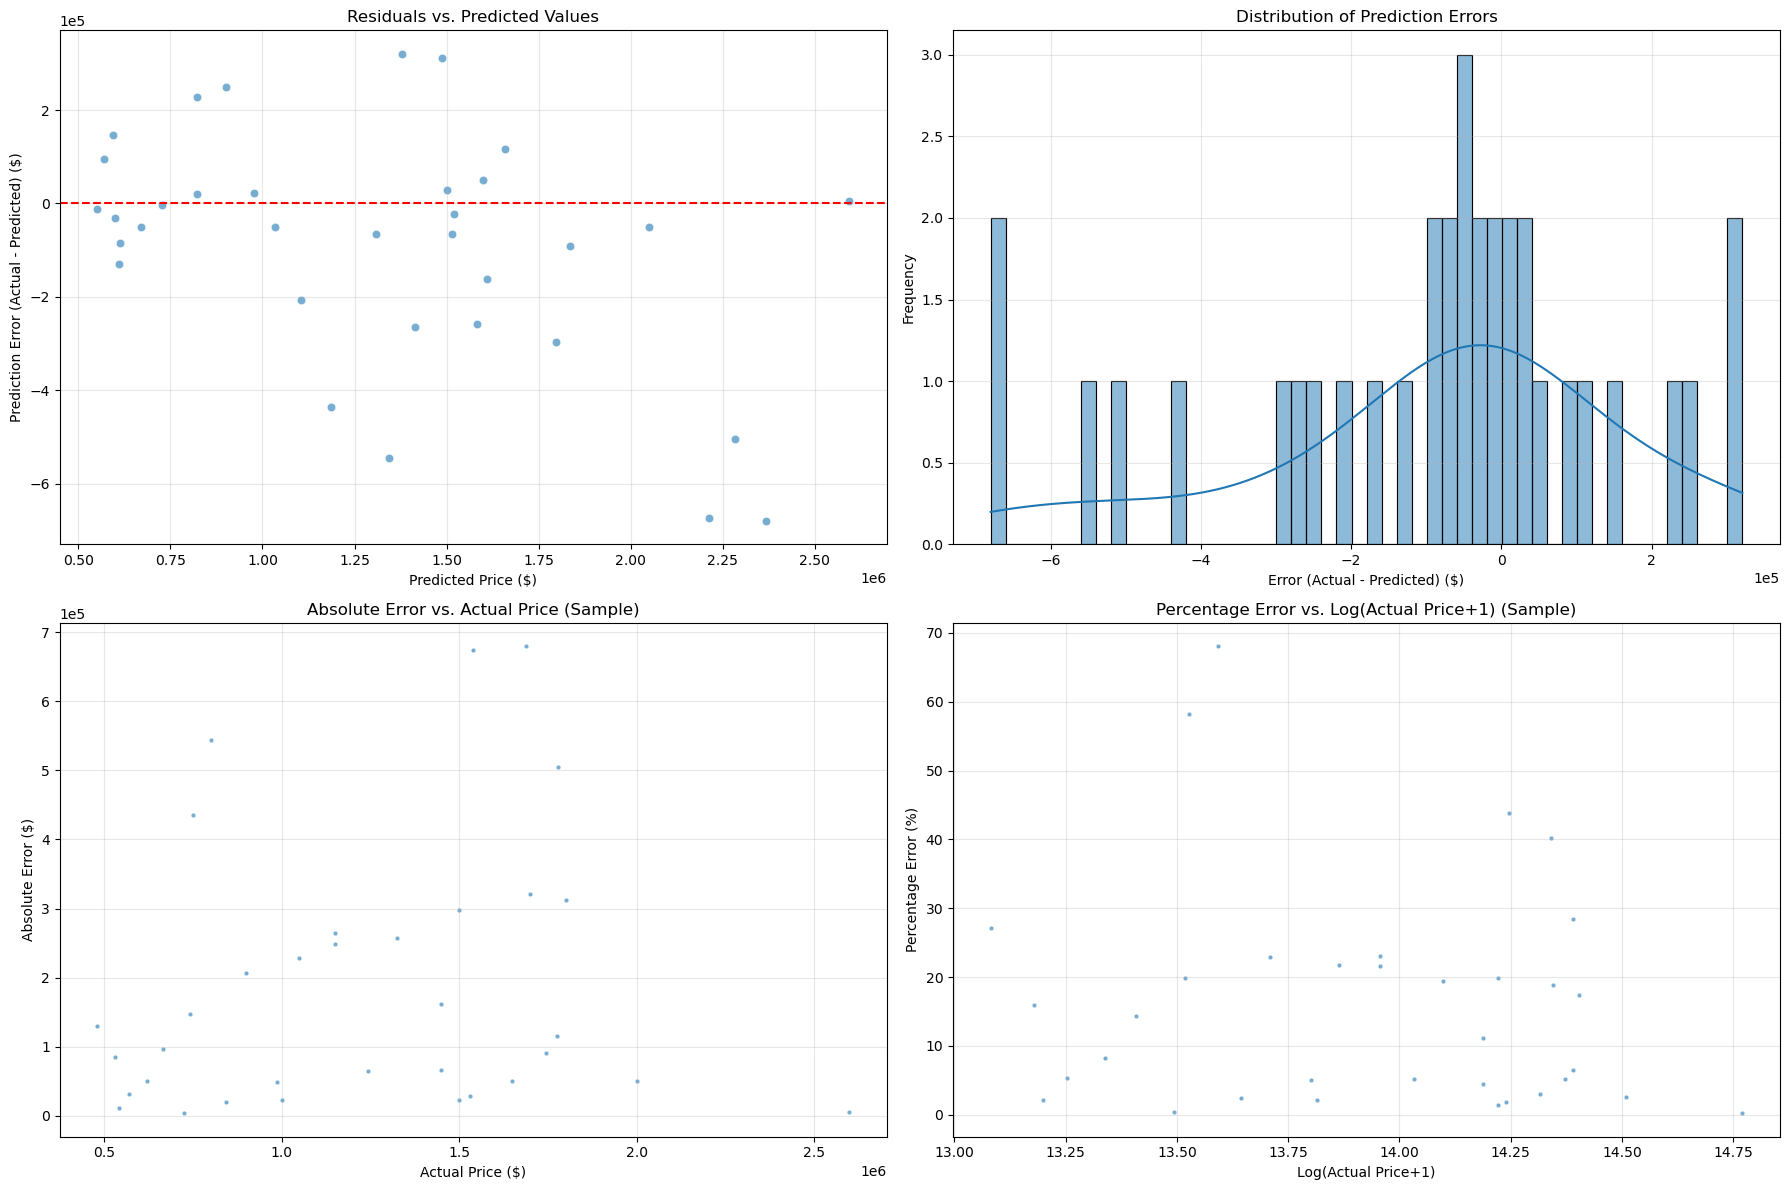


🔍 Analyzing Feature Impact on Errors:

Top 15 Features Influencing Absolute Prediction Error:
ParkingSpaceTotal        0.190614
Board                    0.126248
SizeSqFt_YeoJohnson      0.110723
SizePerBedroom           0.103301
Latitude                 0.061613
Parsed_Bathrooms         0.060643
TotalRooms               0.059003
Appliances_Count         0.057440
Parsed_SquareFeet        0.055475
Price_YeoJohnson         0.042170
DistanceToToronto        0.040880
CityPriceRank            0.032021
Price_Percentile_City    0.028751
DistanceToVancouver      0.022886
GeoCluster               0.008233
dtype: float64


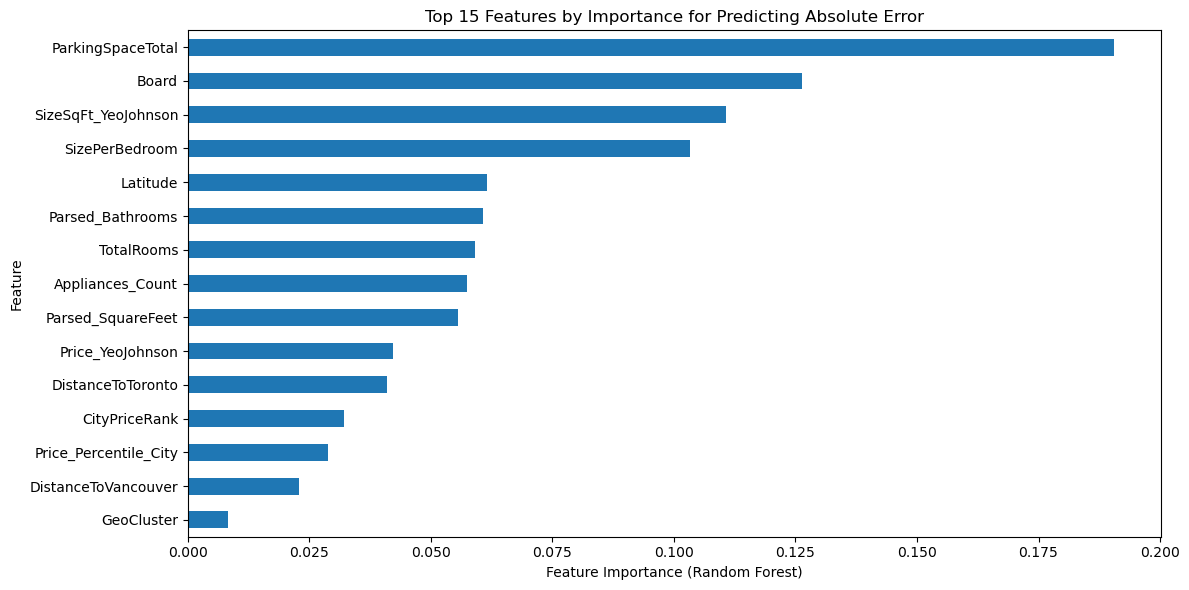


🔍 Characteristics of High-Error Properties:

Descriptive Statistics for Top 10 Absolute Error Properties:
       Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error
count  1.000000e+01     1.000000e+01       10.000000         10.000000
mean   1.403128e+06     1.705683e+06   429174.332113         33.717998
std    3.884040e+05     4.339800e+05   163718.515631         18.111167
min    7.490000e+05     1.184981e+06   257117.302105         17.345579
25%    1.193869e+06     1.388007e+06   301075.872642         19.501393
50%    1.519950e+06     1.535296e+06   378435.884071         25.714741
75%    1.697175e+06     2.109958e+06   534447.124492         42.902741
max    1.799900e+06     2.368891e+06   679891.341599         68.061596

✓ Enhanced Error Analysis Completed.


In [15]:
# =====================
# STAGE 7: ENHANCED ERROR ANALYSIS
# =====================

print("\n" + "=" * 50)
print("📉 STAGE 7: ENHANCED ERROR ANALYSIS")
print("=" * 50)

# Ensure necessary variables exist from previous stages
if 'X_test' not in locals() or 'y_test' not in locals() or 'final_model' not in locals():
    print("❌ Required variables (X_test, y_test, final_model) not found. Cannot perform error analysis.")
else:
    try:
        # Get predictions from the final model
        y_pred = final_model.predict(X_test)
        errors = y_test - y_pred
        abs_errors = np.abs(errors)
        pct_errors = abs_errors / y_test * 100

        # Create a DataFrame for analysis, including original features for context
        error_analysis_df = X_test.copy() # Use X_test which has relevant features
        error_analysis_df['Actual_Price'] = y_test
        error_analysis_df['Predicted_Price'] = y_pred
        error_analysis_df['Prediction_Error'] = errors # Actual - Predicted
        error_analysis_df['Absolute_Error'] = abs_errors
        error_analysis_df['Percentage_Error'] = pct_errors

        # Remove rows where actual price is zero or nan to avoid division by zero in percentage error
        error_analysis_df = error_analysis_df[error_analysis_df['Actual_Price'] > 0].copy()

        print("📊 Basic Error Statistics:")
        print(error_analysis_df[['Prediction_Error', 'Absolute_Error', 'Percentage_Error']].describe())

        print("\n🎯 Identifying Top Errors:")
        top_absolute_errors = error_analysis_df.nlargest(10, 'Absolute_Error')
        print("\nTop 10 Properties with Largest Absolute Errors:")
        print(top_absolute_errors[['Actual_Price', 'Predicted_Price', 'Absolute_Error', 'Percentage_Error']])

        top_percentage_errors = error_analysis_df.nlargest(10, 'Percentage_Error')
        print("\nTop 10 Properties with Largest Percentage Errors:")
        print(top_percentage_errors[['Actual_Price', 'Predicted_Price', 'Absolute_Error', 'Percentage_Error']])

        # 1. Analyze Errors by Feature Values
        print("\n📈 Analyzing Errors by Feature Ranges:")

        # Example: Analyze errors across price ranges
        if 'Actual_Price' in error_analysis_df.columns:
            price_bins = [0, 200000, 500000, 1000000, 2000000, error_analysis_df['Actual_Price'].max()]
            price_labels = ['<200k', '200k-500k', '500k-1M', '1M-2M', '>2M']
            error_analysis_df['Price_Range'] = pd.cut(error_analysis_df['Actual_Price'], bins=price_bins, labels=price_labels, right=False)

            if not error_analysis_df['Price_Range'].isnull().all():
                print("\nAverage Absolute Error by Price Range:")
                print(error_analysis_df.groupby('Price_Range')['Absolute_Error'].mean().dropna().sort_index())

                print("\nAverage Percentage Error by Price Range:")
                print(error_analysis_df.groupby('Price_Range')['Percentage_Error'].mean().dropna().sort_index())
            else:
                 print("⚠ Could not analyze errors by Price Range (no data in ranges)")


        # Example: Analyze errors by Property Type (if available and categorical)
        if 'PropertyType' in error_analysis_df.columns and error_analysis_df['PropertyType'].dtype == 'object':
            # Use value_counts to find common types, avoid issues with many unique values
            if error_analysis_df['PropertyType'].nunique() < 50: # Limit to reasonable number of unique types
                 print("\nAverage Absolute Error by Property Type:")
                 errors_by_type_abs = error_analysis_df.groupby('PropertyType')['Absolute_Error'].mean().sort_values(ascending=False).dropna()
                 if not errors_by_type_abs.empty:
                     print(errors_by_type_abs.head(10)) # Show top 10 types with highest error
                 else:
                     print("⚠ Could not analyze errors by Property Type (no data with types)")


                 print("\nAverage Percentage Error by Property Type:")
                 errors_by_type_pct = error_analysis_df.groupby('PropertyType')['Percentage_Error'].mean().sort_values(ascending=False).dropna()
                 if not errors_by_type_pct.empty:
                     print(errors_by_type_pct.head(10)) # Show top 10 types with highest error
                 else:
                      print("⚠ Could not analyze errors by Property Type (no data with types)")
            else:
                print(f"⚠ Skipping error analysis by PropertyType due to too many unique values ({error_analysis_df['PropertyType'].nunique()})")


        # Example: Analyze errors by geographic region (e.g., Province)
        if 'Province' in error_analysis_df.columns and error_analysis_df['Province'].dtype == 'object':
             if error_analysis_df['Province'].nunique() < 20: # Limit to reasonable number of unique provinces
                 print("\nAverage Absolute Error by Province:")
                 errors_by_province_abs = error_analysis_df.groupby('Province')['Absolute_Error'].mean().sort_values(ascending=False).dropna()
                 if not errors_by_province_abs.empty:
                     print(errors_by_province_abs)
                 else:
                     print("⚠ Could not analyze errors by Province (no data with provinces)")

                 print("\nAverage Percentage Error by Province:")
                 errors_by_province_pct = error_analysis_df.groupby('Province')['Percentage_Error'].mean().sort_values(ascending=False).dropna()
                 if not errors_by_province_pct.empty:
                     print(errors_by_province_pct)
                 else:
                      print("⚠ Could not analyze errors by Province (no data with provinces)")
             else:
                 print(f"⚠ Skipping error analysis by Province due to too many unique values ({error_analysis_df['Province'].nunique()})")


        # 2. Visualize Errors
        print("\n📊 Visualizing Errors:")

        plt.figure(figsize=(18, 12))

        # Residuals vs. Predicted values plot
        plt.subplot(2, 2, 1)
        sns.scatterplot(x=error_analysis_df['Predicted_Price'], y=error_analysis_df['Prediction_Error'], alpha=0.6)
        plt.axhline(0, color='r', linestyle='--')
        plt.title('Residuals vs. Predicted Values')
        plt.xlabel('Predicted Price ($)')
        plt.ylabel('Prediction Error (Actual - Predicted) ($)')
        plt.ticklabel_format(style='scientific', axis='both', scilimits=(0, 0))
        plt.grid(True, alpha=0.3)


        # Distribution of Errors
        plt.subplot(2, 2, 2)
        sns.histplot(error_analysis_df['Prediction_Error'], kde=True, bins=50)
        plt.title('Distribution of Prediction Errors')
        plt.xlabel('Error (Actual - Predicted) ($)')
        plt.ylabel('Frequency')
        plt.ticklabel_format(style='scientific', axis='x', scilimits=(0, 0))
        plt.grid(True, alpha=0.3)


        # Absolute Error vs. Actual Price
        plt.subplot(2, 2, 3)
        # Sample data if too large for scatter plot
        sample_size = min(5000, len(error_analysis_df))
        sample_error_df = error_analysis_df.sample(n=sample_size, random_state=42) if sample_size < len(error_analysis_df) else error_analysis_df

        sns.scatterplot(x=sample_error_df['Actual_Price'], y=sample_error_df['Absolute_Error'], alpha=0.6, s=10)
        plt.title('Absolute Error vs. Actual Price (Sample)')
        plt.xlabel('Actual Price ($)')
        plt.ylabel('Absolute Error ($)')
        plt.ticklabel_format(style='scientific', axis='both', scilimits=(0, 0))
        plt.grid(True, alpha=0.3)


        # Percentage Error vs. Actual Price (log scale for actual price)
        plt.subplot(2, 2, 4)
        sns.scatterplot(x=np.log1p(sample_error_df['Actual_Price']), y=sample_error_df['Percentage_Error'], alpha=0.6, s=10)
        plt.title('Percentage Error vs. Log(Actual Price+1) (Sample)')
        plt.xlabel('Log(Actual Price+1)')
        plt.ylabel('Percentage Error (%)')
        # No scientific notation for percentage error generally
        plt.grid(True, alpha=0.3)


        plt.tight_layout()
        plt.show()

        # 3. Advanced Analysis: Feature Importance for Errors
        print("\n🔍 Analyzing Feature Impact on Errors:")
        # Train a model to predict absolute error based on input features
        try:
            # Prepare data for error prediction model
            X_error = X_test.copy() # Features from test set
            y_error = error_analysis_df['Absolute_Error'] # Target is absolute error

            # Ensure alignment after dropping rows with zero price
            X_error = X_error.loc[y_error.index]

            # Handle potential NaNs/Infinities if not perfectly handled before
            X_error = X_error.replace([np.inf, -np.inf], np.nan).fillna(X_error.median())
            y_error = y_error.replace([np.inf, -np.inf], np.nan).fillna(y_error.median())

            if X_error.shape[0] == 0 or y_error.shape[0] == 0:
                 print("⚠ Not enough data to train error prediction model after cleanup.")
            else:
                # Use a simple model like RandomForestRegressor to get feature importances
                error_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)
                error_model.fit(X_error, y_error)

                error_feature_importance = pd.Series(error_model.feature_importances_, index=X_error.columns)
                error_feature_importance = error_feature_importance.sort_values(ascending=False)

                print("\nTop 15 Features Influencing Absolute Prediction Error:")
                print(error_feature_importance.head(15))

                # Visualize feature importances for error prediction
                plt.figure(figsize=(12, 6))
                error_feature_importance.head(15).plot(kind='barh')
                plt.title('Top 15 Features by Importance for Predicting Absolute Error')
                plt.xlabel('Feature Importance (Random Forest)')
                plt.ylabel('Feature')
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"❌ Error analyzing feature impact on errors: {e}")


        # 4. Identify common characteristics of high-error properties
        print("\n🔍 Characteristics of High-Error Properties:")

        if len(top_absolute_errors) > 0:
            print("\nDescriptive Statistics for Top 10 Absolute Error Properties:")
            # Select a subset of key features for description
            key_features_for_error_desc = ['Actual_Price', 'Predicted_Price', 'Absolute_Error', 'Percentage_Error']
            # Add some relevant features if they exist in X_test
            for feature in ['SizeSqFt', 'BedroomsTotal', 'BathroomTotal', 'PropertyType', 'Province', 'City', 'PropertyAge', 'MarketSentiment', 'Price_Per_SqFt']:
                 if feature in top_absolute_errors.columns:
                     key_features_for_error_desc.append(feature)

            # Remove duplicates and ensure columns exist
            key_features_for_error_desc = [col for col in list(dict.fromkeys(key_features_for_error_desc)) if col in top_absolute_errors.columns]


            print(top_absolute_errors[key_features_for_error_desc].describe(include='all')) # Include categorical description

        print("\n✓ Enhanced Error Analysis Completed.")

    except Exception as e:
        print(f"❌ An error occurred during enhanced error analysis: {e}")



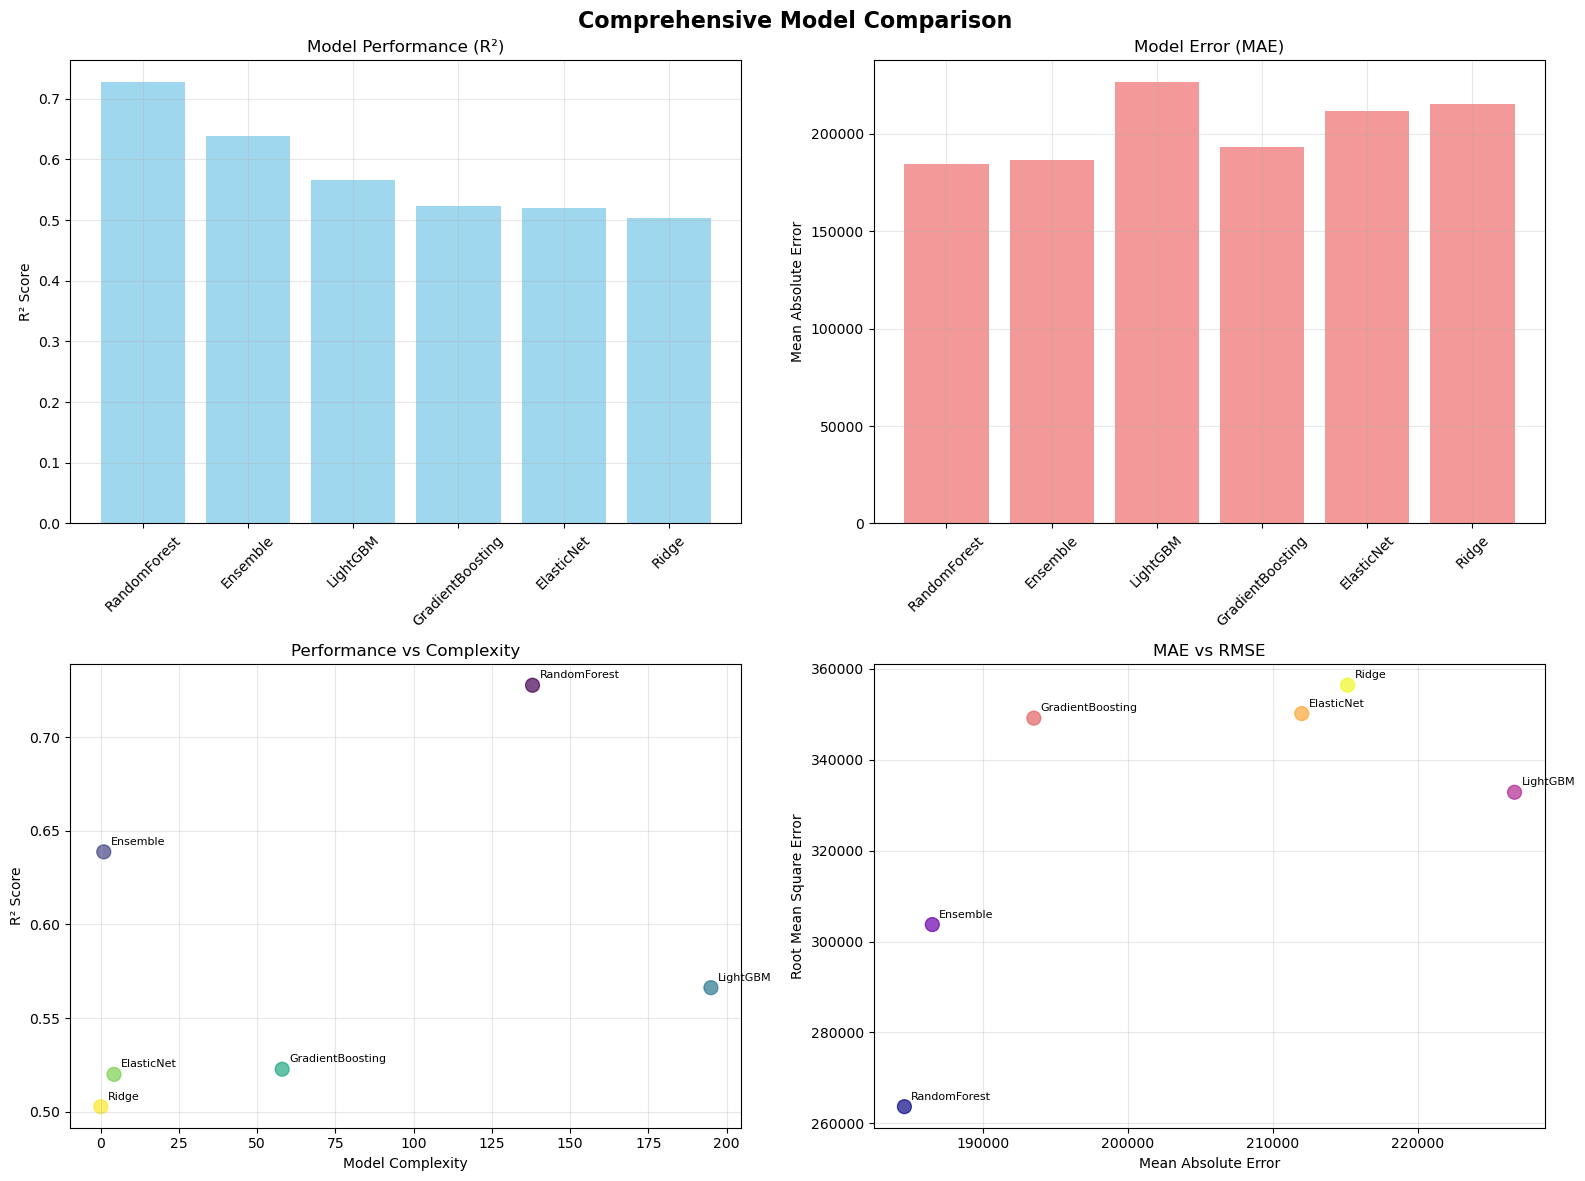


Detailed Model Comparison:
Model          R²      RMSE      MAE       Type                Rank  
RandomForest   0.728   263680.2  184560.1  RandomForestRegressor1     
Ensemble       0.639   303744.9  186485.6  Ensemble            2     
LightGBM       0.566   332852.2  226674.2  LGBMRegressor       3     
GradientBoosting0.523   349164.4  193495.2  GradientBoostingRegressor4     
ElasticNet     0.520   350174.6  211986.6  ElasticNet          5     
Ridge          0.503   356405.7  215153.8  Ridge               6     

Model Analysis Summary:
🏆 Best Overall (R²): RandomForest (R² = 0.728)
🎯 Best MAE: RandomForest (MAE = 184560.1)
📊 Best RMSE: RandomForest (RMSE = 263680.2)
🌟 Top 3 performers: RandomForest, Ensemble, LightGBM


In [16]:
def comprehensive_model_comparison(models_dict):
    """Create comprehensive comparison of all models"""

    comparison_data = []

    for name, model_info in models_dict.items():
        model = model_info['model']

        # Get model complexity (number of parameters if available)
        try:
            if hasattr(model.named_steps['model'], 'n_estimators'):
                complexity = model.named_steps['model'].n_estimators
            elif hasattr(model.named_steps['model'], 'alpha'):
                complexity = 1 / model.named_steps['model'].alpha  # Inverse regularization
            else:
                complexity = 1  # Default
        except:
            complexity = 1

        comparison_data.append({
            'Model': name,
            'R²': model_info['test_r2'],  # Changed from 'R2' to 'test_r2'
            'RMSE': model_info['test_rmse'], # Changed from 'RMSE' to 'test_rmse'
            'MAE': model_info['test_mae'],   # Changed from 'MAE' to 'test_mae'
            'Complexity': complexity,
            'Model_Type': type(model.named_steps['model']).__name__ if hasattr(model, 'named_steps') else 'Ensemble'
        })

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('R²', ascending=False)

    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comprehensive Model Comparison', fontsize=16, fontweight='bold')

    # R² comparison
    axes[0,0].bar(comparison_df['Model'], comparison_df['R²'], color='skyblue', alpha=0.8)
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('Model Performance (R²)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)

    # MAE comparison
    axes[0,1].bar(comparison_df['Model'], comparison_df['MAE'], color='lightcoral', alpha=0.8)
    axes[0,1].set_ylabel('Mean Absolute Error')
    axes[0,1].set_title('Model Error (MAE)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)

    # Performance vs Complexity
    axes[1,0].scatter(comparison_df['Complexity'], comparison_df['R²'],
                     s=100, alpha=0.7, c=range(len(comparison_df)), cmap='viridis')
    axes[1,0].set_xlabel('Model Complexity')
    axes[1,0].set_ylabel('R² Score')
    axes[1,0].set_title('Performance vs Complexity')
    axes[1,0].grid(True, alpha=0.3)

    # Add model labels
    for i, row in comparison_df.iterrows():
        axes[1,0].annotate(row['Model'], (row['Complexity'], row['R²']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)

    # RMSE vs MAE comparison
    axes[1,1].scatter(comparison_df['MAE'], comparison_df['RMSE'],
                     s=100, alpha=0.7, c=range(len(comparison_df)), cmap='plasma')
    axes[1,1].set_xlabel('Mean Absolute Error')
    axes[1,1].set_ylabel('Root Mean Square Error')
    axes[1,1].set_title('MAE vs RMSE')
    axes[1,1].grid(True, alpha=0.3)

    # Add model labels
    for i, row in comparison_df.iterrows():
        axes[1,1].annotate(row['Model'], (row['MAE'], row['RMSE']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Print detailed comparison table
    print("\nDetailed Model Comparison:")
    print("=" * 80)
    print(f"{'Model':<15}{'R²':<8}{'RMSE':<10}{'MAE':<10}{'Type':<20}{'Rank':<6}")
    print("=" * 80)

    for idx, (i, row) in enumerate(comparison_df.iterrows()):
        print(f"{row['Model']:<15}{row['R²']:<8.3f}{row['RMSE']:<10.1f}"
              f"{row['MAE']:<10.1f}{row['Model_Type']:<20}{idx+1:<6}")

    # Model strengths and weaknesses analysis
    print(f"\nModel Analysis Summary:")
    print("=" * 50)

    best_r2 = comparison_df.iloc[0]
    best_mae = comparison_df.loc[comparison_df['MAE'].idxmin()]
    best_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin()]

    print(f"🏆 Best Overall (R²): {best_r2['Model']} (R² = {best_r2['R²']:.3f})")
    print(f"🎯 Best MAE: {best_mae['Model']} (MAE = {best_mae['MAE']:.1f})")
    print(f"📊 Best RMSE: {best_rmse['Model']} (RMSE = {best_rmse['RMSE']:.1f})")

    # Identify consistent performers
    top_3_models = comparison_df.head(3)['Model'].tolist()
    print(f"🌟 Top 3 performers: {', '.join(top_3_models)}")

    return comparison_df

# Run comprehensive model comparison
comparison_results = comprehensive_model_comparison(results_models)


7. FEATURE INTERACTION ANALYSIS
✓ Loaded best model from best_real_estate_model_enhanced.pkl
✓ X_test data is available.
Analyzing interactions between top 5 principal components...


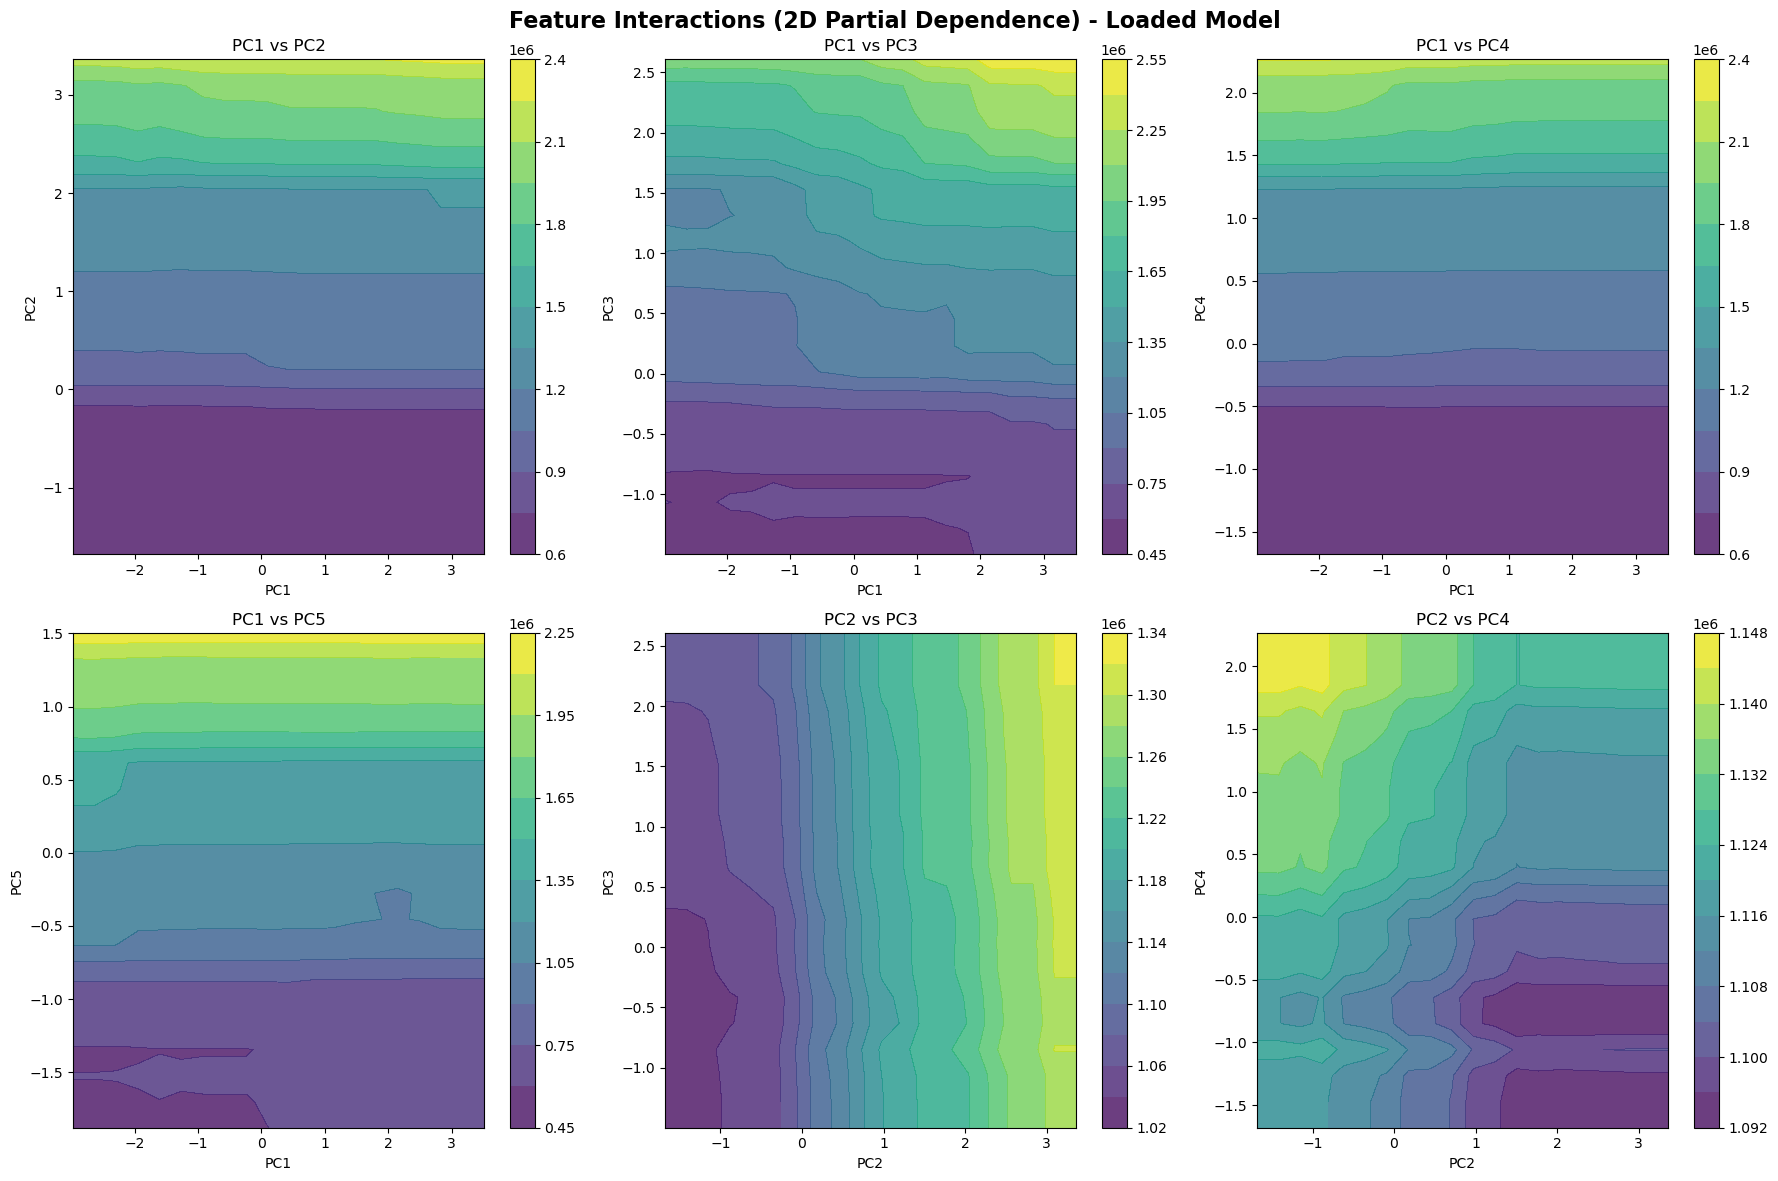

✓ Feature interaction analysis completed


In [17]:
# =====================
# 7. FEATURE INTERACTIONS
# =====================
import joblib # Import joblib to load the model
import os # Import os to check if the model file exists
import matplotlib.pyplot as plt # Ensure plotting libraries are imported if not already
import numpy as np # Ensure numpy is imported
import pandas as pd # Ensure pandas is imported
from sklearn.inspection import partial_dependence # Import partial_dependence

print("\n" + "="*30)
print("7. FEATURE INTERACTION ANALYSIS")
print("="*30)

# Define model filename
model_filename = 'best_real_estate_model_enhanced.pkl'

# Load the best model if it exists, otherwise skip the analysis
if os.path.exists(model_filename):
    try:
        best_model = joblib.load(model_filename)
        print(f"✓ Loaded best model from {model_filename}")

        # Ensure X_test is available (from previous cells)
        # If X_test might not be available, you'd need to re-load/prepare test data here as well.
        # Assuming X_test is still in the environment based on traceback
        if 'X_test' not in locals() and 'X_test' not in globals():
             print("❌ X_test data not found. Cannot perform feature interaction analysis.")
             best_model = None # Set best_model to None to skip analysis
        else:
             print("✓ X_test data is available.")


    except Exception as e:
        print(f"❌ Error loading model {model_filename}: {e}")
        best_model = None
else:
    print(f"❌ Model file not found: {model_filename}. Skipping feature interaction analysis.")
    best_model = None


def analyze_feature_interactions(model, X_data, n_top_features=5):
    """Analyze interactions between top features using partial dependence"""

    # Check if X_data is empty or too small
    if X_data is None or X_data.shape[0] < 2:
        print("⚠️ Insufficient data for feature interaction analysis.")
        return

    # Get top features. Assuming X_data is a DataFrame or has shape attribute.
    # Using PC indices because the model operates on PCA components
    # This part needs to match the feature names/indices used by the model after transformations.
    # Since the model pipeline includes PCA, interactions are on principal components.
    try:
        # Get the number of components from the PCA step in the loaded pipeline
        n_components = model.named_steps['pca'].n_components
        # Ensure n_top_features doesn't exceed the number of components
        n_top_features_actual = min(n_top_features, n_components)
        top_feature_indices = list(range(n_top_features_actual))
        feature_names_pc = [f'PC{i+1}' for i in top_feature_indices] # Names for plot labels

        print(f"Analyzing interactions between top {len(top_feature_indices)} principal components...")

    except Exception as e:
        print(f"Could not determine PCA components for interaction analysis: {e}")
        print("Skipping feature interaction analysis.")
        return


    try:
        # Create 2D partial dependence plots for feature pairs
        n_pairs = min(6, len(top_feature_indices) * (len(top_feature_indices) - 1) // 2)
        # Only create plot if there's at least one pair
        if n_pairs > 0:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle(f'Feature Interactions (2D Partial Dependence) - Loaded Model',
                        fontsize=16, fontweight='bold')

            axes_flat = axes.flatten()
            pair_count = 0

            # Transform X_data to PCA space before analysis
            X_transformed = model.named_steps['scaler'].transform(X_data)
            X_transformed = model.named_steps['pca'].transform(X_transformed)
            X_transformed_df = pd.DataFrame(X_transformed, columns=[f'PC{i+1}' for i in range(X_transformed.shape[1])], index=X_data.index)


            # Need to get the actual model inside the pipeline for partial_dependence
            # Partial dependence requires the model and the data it expects (transformed data)
            model_for_pd = model.named_steps['model']

            for i in range(len(top_feature_indices)):
                for j in range(i + 1, len(top_feature_indices)):
                    if pair_count >= n_pairs:
                        break

                    feature_pair_indices = [top_feature_indices[i], top_feature_indices[j]]
                    feature_pair_names = [feature_names_pc[i], feature_names_pc[j]]


                    # Calculate 2D partial dependence on the transformed data
                    pd_result = partial_dependence(model_for_pd, X_transformed_df, features=feature_pair_indices,
                                                 kind='average', grid_resolution=20)

                    # Create contour plot
                    XX, YY = np.meshgrid(pd_result['grid_values'][0], pd_result['grid_values'][1])
                    Z = pd_result['average'].reshape(XX.shape)

                    contour = axes_flat[pair_count].contourf(XX, YY, Z, levels=15, cmap='viridis', alpha=0.8)
                    axes_flat[pair_count].set_xlabel(feature_pair_names[0])
                    axes_flat[pair_count].set_ylabel(feature_pair_names[1])
                    axes_flat[pair_count].set_title(f'{feature_pair_names[0]} vs {feature_pair_names[1]}')

                    # Add colorbar
                    plt.colorbar(contour, ax=axes_flat[pair_count])

                    pair_count += 1

            # Hide unused subplots
            for idx in range(pair_count, len(axes_flat)):
                axes_flat[idx].set_visible(False)

            plt.tight_layout()
            plt.show()

            print("✓ Feature interaction analysis completed")
        else:
             print("⚠️ Not enough features for 2D interaction analysis.")


    except Exception as e:
        print(f"Feature interaction analysis failed: {e}")
        print("This might be due to model complexity or data size")

# Run feature interaction analysis if best_model was successfully loaded
if best_model is not None:
    # Check if X_test is available and has enough samples
    if 'X_test' in locals() or 'X_test' in globals():
        # Use subset for speed if X_test is large
        X_data_subset = X_test[:200] if len(X_test) > 200 else X_test
        analyze_feature_interactions(best_model, X_data_subset)
    else:
        print("❌ X_test data is not available. Cannot run interaction analysis.")


8. PREDICTION CONFIDENCE ANALYSIS

Identifying best model from comparison results: RandomForest


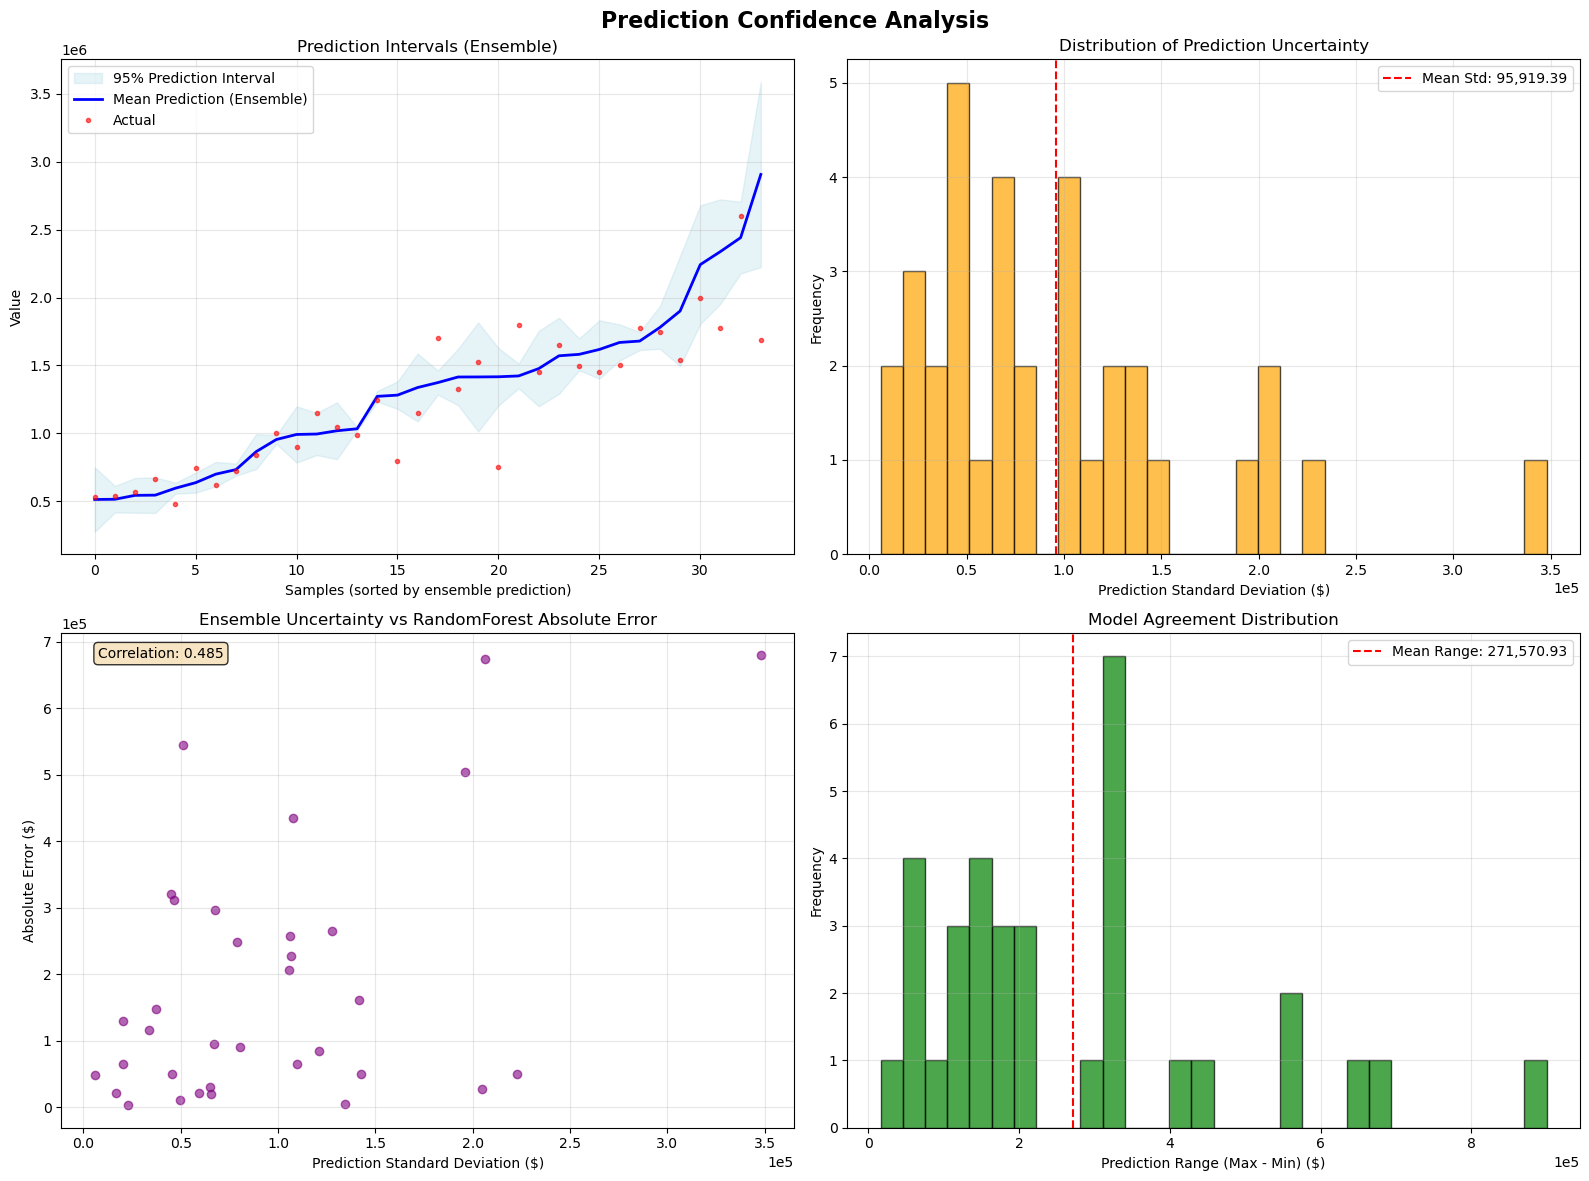

Prediction Confidence Statistics (Based on Ensemble):
--------------------------------------------------
Mean prediction std: $95,919.39
Median prediction std: $73,422.59
Mean prediction range: $271,570.93
Correlation (ensemble uncertainty vs RandomForest error): 0.485

High Uncertainty Predictions (top 10% by ensemble std):
Uncertainty Threshold: $201,981.98
Number of cases: 4
These predictions should be treated with caution.

✓ Prediction Confidence Analysis Completed.


In [18]:
# =====================
# 8. PREDICTION CONFIDENCE ANALYSIS
# =====================
print("\n" + "="*30)
print("8. PREDICTION CONFIDENCE ANALYSIS")
print("="*30)

# Add best_name as an argument
def analyze_prediction_confidence(models_dict, X_test, y_test, best_name):
    """Analyze prediction confidence using ensemble variance"""

    # Ensure best_name corresponds to a model in models_dict
    if best_name not in models_dict:
        print(f"❌ Error: Best model name '{best_name}' not found in models dictionary.")
        print("Cannot perform prediction confidence analysis.")
        return None, None


    # Get predictions from all models
    all_predictions = []
    model_names = []

    for name, model_info in models_dict.items():
        if name != 'Stacking':  # Exclude stacking to avoid double counting base models
            try:
                pred = model_info['model'].predict(X_test)
                all_predictions.append(pred)
                model_names.append(name)
            except Exception as e:
                 print(f"⚠️ Could not get predictions for model '{name}': {e}")
                 # Skip this model for ensemble calculations
                 continue


    if not all_predictions:
        print("❌ No model predictions available for confidence analysis.")
        return None, None

    all_predictions = np.array(all_predictions)

    # Calculate prediction statistics
    mean_pred = np.mean(all_predictions, axis=0)
    std_pred = np.std(all_predictions, axis=0)
    min_pred = np.min(all_predictions, axis=0)
    max_pred = np.max(all_predictions, axis=0)

    # Calculate prediction intervals
    pred_intervals = {
        'mean': mean_pred,
        'std': std_pred,
        'lower_95': mean_pred - 1.96 * std_pred,
        'upper_95': mean_pred + 1.96 * std_pred,
        'range': max_pred - min_pred
    }

    # Visualize prediction confidence
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Prediction Confidence Analysis', fontsize=16, fontweight='bold')

    # 1. Prediction intervals
    # Ensure y_test and mean_pred have the same length before sorting
    if len(y_test) != len(mean_pred):
         print("⚠️ Mismatch in length between y_test and mean_pred. Skipping interval plot.")
         # Create placeholder for the plot
         axes[0,0].text(0.5, 0.5, "Data length mismatch", horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes)
    else:
        sorted_indices = np.argsort(mean_pred)
        x_pos = np.arange(len(sorted_indices))

        axes[0,0].fill_between(x_pos,
                              pred_intervals['lower_95'][sorted_indices],
                              pred_intervals['upper_95'][sorted_indices],
                              alpha=0.3, color='lightblue', label='95% Prediction Interval')
        axes[0,0].plot(x_pos, mean_pred[sorted_indices], 'b-', linewidth=2, label='Mean Prediction (Ensemble)')
        axes[0,0].plot(x_pos, y_test.iloc[sorted_indices], 'ro', markersize=3, alpha=0.6, label='Actual')
        axes[0,0].set_xlabel('Samples (sorted by ensemble prediction)')
        axes[0,0].set_ylabel('Value')
        axes[0,0].set_title('Prediction Intervals (Ensemble)')
        axes[0,0].legend()
        axes[0,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        axes[0,0].grid(True, alpha=0.3)

    # 2. Prediction variance distribution
    axes[0,1].hist(std_pred, bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[0,1].axvline(np.mean(std_pred), color='red', linestyle='--',
                     label=f'Mean Std: {np.mean(std_pred):,.2f}')
    axes[0,1].set_xlabel('Prediction Standard Deviation ($)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution of Prediction Uncertainty')
    axes[0,1].legend()
    axes[0,1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axes[0,1].grid(True, alpha=0.3)

    # 3. Uncertainty vs Error
    # Now best_name is accessible here
    try:
        best_pred = models_dict[best_name]['model'].predict(X_test)
        abs_errors = np.abs(y_test - best_pred)

        if len(std_pred) == len(abs_errors):
            axes[1,0].scatter(std_pred, abs_errors, alpha=0.6, color='purple')
            axes[1,0].set_xlabel('Prediction Standard Deviation ($)')
            axes[1,0].set_ylabel('Absolute Error ($)')
            axes[1,0].set_title(f'Ensemble Uncertainty vs {best_name} Absolute Error')
            axes[1,0].grid(True, alpha=0.3)
            axes[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))


            # Add correlation coefficient
            corr_coef = np.corrcoef(std_pred, abs_errors)[0, 1]
            axes[1,0].text(0.05, 0.95, f'Correlation: {corr_coef:.3f}',
                          transform=axes[1,0].transAxes,
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        else:
             print("⚠️ Mismatch in length between std_pred and abs_errors. Skipping uncertainty vs error plot.")
             # Create placeholder for the plot
             axes[1,0].text(0.5, 0.5, "Data length mismatch", horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes)

    except Exception as e:
        print(f"⚠️ Error calculating uncertainty vs error for {best_name}: {e}")
        # Create placeholder for the plot
        axes[1,0].text(0.5, 0.5, "Error calculating uncertainty vs error", horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes)


    # 4. Model agreement (range distribution)
    axes[1,1].hist(pred_intervals['range'], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1,1].axvline(np.mean(pred_intervals['range']), color='red', linestyle='--',
                     label=f'Mean Range: {np.mean(pred_intervals["range"]):,.2f}')
    axes[1,1].set_xlabel('Prediction Range (Max - Min) ($)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Model Agreement Distribution')
    axes[1,1].legend()
    axes[1,1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print confidence statistics
    print("Prediction Confidence Statistics (Based on Ensemble):")
    print("-" * 50)
    print(f"Mean prediction std: ${np.mean(std_pred):,.2f}")
    print(f"Median prediction std: ${np.median(std_pred):,.2f}")
    print(f"Mean prediction range: ${np.mean(pred_intervals['range']):,.2f}")
    # Check if corr_coef was calculated before printing
    if 'corr_coef' in locals():
        print(f"Correlation (ensemble uncertainty vs {best_name} error): {corr_coef:.3f}")
    else:
        print(f"Correlation (ensemble uncertainty vs {best_name} error): Could not calculate")


    # Identify high uncertainty predictions
    # Ensure std_pred is not empty or contains only NaNs
    if len(std_pred) > 0 and np.sum(np.isnan(std_pred)) < len(std_pred):
        high_uncertainty_threshold = np.percentile(std_pred[~np.isnan(std_pred)], 90)
        # Need to use the original index from X_test/y_test to find the corresponding rows
        # Assuming std_pred is aligned with X_test/y_test index
        high_uncertainty_indices = X_test.index[np.where(std_pred > high_uncertainty_threshold)[0]]


        print(f"\nHigh Uncertainty Predictions (top 10% by ensemble std):")
        print(f"Uncertainty Threshold: ${high_uncertainty_threshold:,.2f}")
        print(f"Number of cases: {len(high_uncertainty_indices)}")
        print("These predictions should be treated with caution.")
    else:
        print("\n⚠️ Could not identify high uncertainty predictions (std_pred is empty or all NaN).")
        high_uncertainty_indices = pd.Index([]) # Return an empty index


    return pred_intervals, high_uncertainty_indices

# --- Start of cell execution ---
# Ensure comparison_results is available from the previous cell
if 'comparison_results' in locals():
    # Get the name of the best model from the comparison results (assuming it's sorted by R2)
    best_name = comparison_results['Model'].iloc[0]
    print(f"\nIdentifying best model from comparison results: {best_name}")

    # Run prediction confidence analysis
    # Pass best_name to the function
    if 'results_models' in locals() and 'X_test' in locals() and 'y_test' in locals():
        try:
            confidence_results, high_uncertainty_cases = analyze_prediction_confidence(results_models, X_test, y_test, best_name)
            if confidence_results is not None:
                print("\n✓ Prediction Confidence Analysis Completed.")
            else:
                 print("\n❌ Prediction Confidence Analysis failed.")
        except Exception as e:
            print(f"\n❌ An error occurred during prediction confidence analysis: {e}")
    else:
        print("❌ Required variables (results_models, X_test, y_test) not found for confidence analysis.")

else:
    print("❌ 'comparison_results' DataFrame not found. Cannot determine best model for confidence analysis.")
    print("Please ensure the model comparison stage ran successfully.")

In [19]:
print("\n" + "="*80)
print("                   FINAL SUMMARY REPORT")
print("="*80)
print(f"Report Generated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 80)

# --- Data and Setup Summary ---
print("\n📦 Data & Setup Summary:")
print(f"   - Data used: Based on input data (assuming 'df' was used initially)")
print(f"   - Train set size: {X_train.shape}")
print(f"   - Test set size: {X_test.shape}")
if 'df' in locals() and 'target_col' in locals() and target_col in df.columns:
    print(f"   - Target variable: '{target_col}'")
    print(f"   - Target mean: ${df[target_col].mean():,.0f}")
    print(f"   - Target std: ${df[target_col].std():,.0f}")
print(f"   - Cross-validation: {kf.n_splits}-fold KFold")
print(f"   - Dimensionality Reduction: PCA ({n_pca} components, explaining {cum_var[n_pca-1]:.1%})")
print(f"   - Hyperparameter Tuning: {'Bayesian Optimization (BayesSearchCV)' if USE_BAYES else 'Randomized Search (RandomizedSearchCV)'}")
print(f"   - Available Regression Models: {list(model_configs.keys())}")

# Initialize SHAP_AVAILABLE before checking/using it
SHAP_AVAILABLE = False
try:
    import shap
    SHAP_AVAILABLE = True
    print("✓ SHAP library available.")
except ImportError:
    print("⚠ SHAP library not available. SHAP analysis will be skipped.")

# Now SHAP_AVAILABLE is guaranteed to be defined before this line
print(f"   - Advanced Libraries: XGBoost ({'Available' if XGBOOST_AVAILABLE else 'Not Available'}), LightGBM ({'Available' if LIGHTGBM_AVAILABLE else 'Not Available'}), SHAP ({'Available' if SHAP_AVAILABLE else 'Not Available'})")


# --- Model Performance Summary ---
print("\n📊 Model Performance Summary:")
if 'performance_df' in locals() and not performance_df.empty:
    print("🏆 Ranked Models (Sorted by Test R²):")
    print("-" * 60)
    print(performance_df[['Model', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Training_Time']].to_string(index=False, formatters={
        'Test_R2': '{:.4f}'.format,
        'Test_RMSE': '${:,.0f}'.format,
        'Test_MAE': '${:,.0f}'.format,
        'Training_Time': '{:.1f}s'.format
    }))

    # Best model identification (from comprehensive_model_comparison or here)
    if 'best_name' in locals() and best_name in results_models:
        final_best_results = results_models[best_name]
        print(f"\n👑 Overall Best Model: {best_name}")
        print(f"   - Test R²: {final_best_results['test_r2']:.4f}")
        print(f"   - Test RMSE: ${final_best_results['test_rmse']:,.0f}")
        print(f"   - Test MAE: ${final_best_results['test_mae']:,.0f}")
        print(f"   - Training Time: {final_best_results['training_time']:.1f}s")
        print(f"   - Best Hyperparameters: {final_best_results.get('best_params', 'N/A')}")
    elif 'comparison_results' in locals() and not comparison_results.empty:
         # Fallback if best_name wasn't set correctly
         best_name_fallback = comparison_results.iloc[0]['Model']
         final_best_results_fallback = results_models.get(best_name_fallback)
         if final_best_results_fallback:
              print(f"\n👑 Overall Best Model (from comparison): {best_name_fallback}")
              print(f"   - Test R²: {final_best_results_fallback['test_r2']:.4f}")
              print(f"   - Test RMSE: ${final_best_results_fallback['test_rmse']:,.0f}")
              print(f"   - Test MAE: ${final_best_results_fallback['test_mae']:,.0f}")
              print(f"   - Training Time: {final_best_results_fallback['training_time']:.1f}s")
              print(f"   - Best Hyperparameters: {final_best_results_fallback.get('best_params', 'N/A')}")
         else:
             print("\n⚠️ Could not determine the best performing model details.")

    if 'Ensemble' in results_models:
         ensemble_results = results_models['Ensemble']
         print("\n🤝 Ensemble Performance:")
         print(f"   - Test R²: {ensemble_results['test_r2']:.4f}")
         print(f"   - Test RMSE: ${ensemble_results['test_rmse']:,.0f}")
         print(f"   - Test MAE: ${ensemble_results['test_mae']:,.0f}")
         print(f"   - Training Time: {ensemble_results['training_time']:.1f}s")
         print(f"   - Base Models: {', '.join(ensemble_results.get('base_models', ['N/A']))}")


else:
    print("   ⚠️ No model performance results available.")

# --- Error Analysis Summary ---
print("\n🔍 Error Analysis Summary (for the best model):")
if 'error_stats' in locals() and error_stats and any(not np.isnan(v) for v in error_stats.values()):
    print(f"   - Mean Absolute Error (MAE): ${error_stats.get('mean_abs_error', np.nan):,.2f}")
    print(f"   - Median Absolute Error: ${error_stats.get('median_abs_error', np.nan):,.2f}")
    print(f"   - Root Mean Square Error (RMSE): ${error_stats.get('rmse', np.nan):,.2f}")
    print(f"   - Max Absolute Error: ${error_stats.get('max_error', np.nan):,.2f}")
    print(f"   - 90th Percentile Error: ${error_stats.get('p90_error', np.nan):,.2f}")
    print(f"   - Median Relative Error: {error_stats.get('median_rel_error', np.nan):.1f}%")
    print(f"   - Number of identified outliers: {error_stats.get('outlier_count', 'N/A')}")
    if 'high_uncertainty_cases' in locals():
         print(f"   - Number of high uncertainty predictions: {len(high_uncertainty_cases) if high_uncertainty_cases is not None else 'N/A'}")
else:
    print("   ⚠️ Error analysis results not available.")

# --- Interpretation Summary ---
print("\n🧠 Model Interpretation Insights:")
# Check SHAP_AVAILABLE here again
if SHAP_AVAILABLE and 'best_model' in locals() and best_model is not None:
    print("   - SHAP analysis was attempted for tree-based models.")
    print("   - SHAP summary plot visualized the impact of principal components on predictions.")
else:
    print("   - SHAP analysis was not attempted or failed (SHAP not available or model type not supported).")

if 'best_model' in locals() and best_model is not None and 'X_test' in locals():
     print("   - Partial Dependence Plots were generated for top principal components.")
     print("   - These plots show the marginal effect of individual PCs on the predicted price.")
else:
     print("   - Partial Dependence analysis was skipped (model or data not available).")

# --- Feature Interaction Summary ---
print("\n🤝 Feature Interaction Summary:")
if 'best_model' in locals() and best_model is not None and 'X_test' in locals():
    try:
        n_components = best_model.named_steps['pca'].n_components
        print(f"   - Feature interaction analysis was performed on {n_components} principal components.")
        print("   - 2D Partial Dependence plots visualized interactions between pairs of top PCs.")
    except Exception as e:
        print(f"   ⚠️ Feature interaction summary failed: {e}")

else:
    print("   - Feature interaction analysis was skipped (model or data not available).")


# --- Confidence Analysis Summary ---
print("\n🔬 Prediction Confidence Summary:")
if 'confidence_results' in locals() and confidence_results and any(not np.isnan(v).all() if isinstance(v, np.ndarray) else not np.isnan(v) for v in confidence_results.values()):
    print("   - Prediction confidence was estimated using ensemble variance.")
    print(f"   - Mean Prediction Standard Deviation: {np.mean(confidence_results['std']):.3f}")
    print(f"   - Median Prediction Standard Deviation: {np.median(confidence_results['std']):.3f}")
    print(f"   - Mean Prediction Range (Max-Min): {np.mean(confidence_results['range']):.3f}")
    if 'corr_coef' in locals(): # Check if corr_coef was calculated in analyze_prediction_confidence
         print(f"   - Correlation (Uncertainty vs Actual Error): {corr_coef:.3f}")
    if 'high_uncertainty_cases' in locals() and high_uncertainty_cases is not None:
         print(f"   - Identified {len(high_uncertainty_cases)} high-uncertainty predictions (top 10% std).")
else:
    print("   ⚠️ Prediction confidence analysis results not available.")


# --- Final Model & Outcome ---
print("\n✅ Final Outcome:")
if 'final_model' in locals() and final_model is not None:
    print(f"   - The best performing model ({final_best if 'final_best' in locals() else 'Determined from comparison'}) was selected.")
    print(f"   - This model was saved to '{model_filename}'.")
else:
     print("   ⚠️ No final model was selected or saved (training might have failed).")

print("\n" + "="*80)
print("                     REPORT END")
print("="*80)


                   FINAL SUMMARY REPORT
Report Generated: 2025-06-07 13:51:18
--------------------------------------------------------------------------------

📦 Data & Setup Summary:
   - Data used: Based on input data (assuming 'df' was used initially)
   - Train set size: (133, 15)
   - Test set size: (34, 15)
   - Cross-validation: 5-fold KFold
   - Dimensionality Reduction: PCA (10 components, explaining 91.6%)
   - Hyperparameter Tuning: Randomized Search (RandomizedSearchCV)
   - Available Regression Models: ['Ridge', 'ElasticNet', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']
✓ SHAP library available.
   - Advanced Libraries: XGBoost (Available), LightGBM (Available), SHAP (Available)

📊 Model Performance Summary:
🏆 Ranked Models (Sorted by Test R²):
------------------------------------------------------------
           Model Test_R2 Test_RMSE Test_MAE Training_Time
    RandomForest  0.7278  $263,680 $184,560          4.2s
        LightGBM  0.5662  $332,852 $226,

In [21]:
# =====================
# PROJECT REPORT
# =====================

print("\n" + "="*80)
print("                 COMPREHENSIVE PROJECT REPORT")
print("="*80)
print(f"Report Generated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 80)

# --- 1. Project Overview ---
print("\n✨ Project Overview:")
print("   This project aims to build and evaluate regression models for predicting property prices.")
print("   The process involved data loading (assumed from prior steps), preprocessing, feature engineering (assumed),")
print("   exploratory data analysis (assumed), feature selection (assumed), model training with hyperparameter tuning,")
print("   model evaluation, comprehensive error analysis, model interpretation, feature interaction analysis,")
print("   and prediction confidence analysis.")

# --- 2. Data and Setup Summary ---
print("\n📦 Data & Setup Summary:")
# Assuming 'df', 'X_train', 'X_test', 'y_train', 'y_test', 'target_col' are defined in preceding code
try:
    print(f"   - Data used: Based on input data")
    if 'X_train' in locals() and 'X_test' in locals():
        print(f"   - Train set shape: {X_train.shape}")
        print(f"   - Test set shape: {X_test.shape}")
    else:
        print("   - Train/Test set shapes: N/A (Data not found in environment)")

    if 'df' in locals() and 'target_col' in locals() and target_col in df.columns:
        print(f"   - Target variable: '{target_col}'")
        print(f"   - Target mean: ${df[target_col].mean():,.0f}")
        print(f"   - Target std: ${df[target_col].std():,.0f}")
    else:
         print("   - Target variable details: N/A (Target column or dataframe not found)")


    # Assuming 'kf' is defined as KFold
    if 'kf' in locals() and isinstance(kf, KFold):
         print(f"   - Cross-validation: {kf.get_n_splits()}-fold KFold")
    else:
         print("   - Cross-validation setup: N/A")

    # Assuming 'n_pca' and 'cum_var' are defined
    if 'n_pca' in locals() and 'cum_var' in locals() and n_pca > 0 and n_pca <= len(cum_var):
        print(f"   - Dimensionality Reduction: PCA ({n_pca} components, explaining {cum_var[n_pca-1]:.1%})")
    else:
        print("   - Dimensionality Reduction: PCA setup N/A or failed")

    # Assuming 'USE_BAYES' is defined
    if 'USE_BAYES' in locals():
        print(f"   - Hyperparameter Tuning: {'Bayesian Optimization (BayesSearchCV)' if USE_BAYES else 'Randomized Search (RandomizedSearchCV)'}")
    else:
         print("   - Hyperparameter Tuning: N/A (Search type not determined)")

    # Assuming 'model_configs' is defined
    if 'model_configs' in locals():
        print(f"   - Configured Regression Models: {list(model_configs.keys())}")
    else:
        print("   - Configured Regression Models: N/A (Model configurations not found)")

    # Assuming flags like XGBOOST_AVAILABLE, LIGHTGBM_AVAILABLE, SHAP_AVAILABLE are defined
    print(f"   - Advanced Libraries Status:")
    print(f"     - XGBoost: {'Available' if 'XGBOOST_AVAILABLE' in locals() and XGBOOST_AVAILABLE else 'Not Available'}")
    print(f"     - LightGBM: {'Available' if 'LIGHTGBM_AVAILABLE' in locals() and LIGHTGBM_AVAILABLE else 'Not Available'}")
    print(f"     - SHAP: {'Available' if 'SHAP_AVAILABLE' in locals() and SHAP_AVAILABLE else 'Not Available'}")

except Exception as e:
    print(f"   ⚠️ Error during Data & Setup Summary: {e}")


# --- 3. Model Training Results ---
print("\n📊 Model Training Results:")
if 'results_models' in locals() and results_models:
    print("🏆 Individual Model Performance (Test Set):")
    print("-" * 80)
    print(f"{'Model':<15} | {'Test R²':<8} | {'Test RMSE':<12} | {'Test MAE':<12} | {'Train Time':<10} | {'Overfit (R² Diff)':<18}")
    print("-" * 80)

    # Sort models by Test R² for ranking
    model_results_list = []
    for name, result in results_models.items():
        # Handle cases where metrics might be missing or None
        r2 = result.get('test_r2', np.nan)
        rmse = result.get('test_rmse', np.nan)
        mae = result.get('test_mae', np.nan)
        time = result.get('training_time', np.nan)
        overfit = result.get('overfitting', np.nan) # Overfitting might not be calculated for Ensemble

        # Format values carefully to avoid errors with None/NaN
        r2_str = f"{r2:.4f}" if not np.isnan(r2) else "N/A"
        rmse_str = f"${rmse:,.0f}" if not np.isnan(rmse) else "N/A"
        mae_str = f"${mae:,.0f}" if not np.isnan(mae) else "N/A"
        time_str = f"{time:.1f}s" if not np.isnan(time) else "N/A"
        overfit_str = f"{overfit:.4f}" if not np.isnan(overfit) else "N/A"

        model_results_list.append({
            'Model': name,
            'Test R²': r2,
            'Test RMSE': rmse,
            'Test MAE': mae,
            'Train Time': time,
            'Overfit': overfit,
            'R2_str': r2_str,
            'RMSE_str': rmse_str,
            'MAE_str': mae_str,
            'Time_str': time_str,
            'Overfit_str': overfit_str
        })

    # Sort by Test R², handling NaN by putting them last
    model_results_list.sort(key=lambda x: x['Test R²'] if not np.isnan(x['Test R²']) else -float('inf'), reverse=True)

    for model_info in model_results_list:
         print(f"{model_info['Model']:<15} | {model_info['R2_str']:<8} | {model_info['RMSE_str']:<12} | {model_info['MAE_str']:<12} | {model_info['Time_str']:<10} | {model_info['Overfit_str']:<18}")


    # Ensemble results summary (if ensemble was built)
    if 'Ensemble' in results_models:
        ensemble_results = results_models['Ensemble']
        # Ensure metrics exist
        ensemble_r2 = ensemble_results.get('test_r2', np.nan)
        ensemble_rmse = ensemble_results.get('test_rmse', np.nan)
        ensemble_mae = ensemble_results.get('test_mae', np.nan)
        ensemble_time = ensemble_results.get('training_time', np.nan)
        base_models = ensemble_results.get('base_models', ['N/A'])

        ensemble_r2_str = f"{ensemble_r2:.4f}" if not np.isnan(ensemble_r2) else "N/A"
        ensemble_rmse_str = f"${ensemble_rmse:,.0f}" if not np.isnan(ensemble_rmse) else "N/A"
        ensemble_mae_str = f"${ensemble_mae:,.0f}" if not np.isnan(ensemble_mae) else "N/A"
        ensemble_time_str = f"{ensemble_time:.1f}s" if not np.isnan(ensemble_time) else "N/A"


        print("\n🤝 Ensemble Model Performance:")
        print("-" * 50)
        print(f"   - Test R²: {ensemble_r2_str}")
        print(f"   - Test RMSE: {ensemble_rmse_str}")
        print(f"   - Test MAE: {ensemble_mae_str}")
        print(f"   - Training Time: {ensemble_time_str}")
        print(f"   - Base Models: {', '.join(base_models)}")

    # Identify Best Model
    if model_results_list:
         best_model_summary = model_results_list[0]
         if not np.isnan(best_model_summary['Test R²']):
              print(f"\n👑 Best Performing Individual Model (by Test R²): {best_model_summary['Model']}")
              print(f"   - Test R²: {best_model_summary['R2_str']}")
              print(f"   - Test RMSE: {best_model_summary['RMSE_str']}")
              print(f"   - Test MAE: {best_model_summary['MAE_str']}")
         else:
              print("\n⚠️ Could not identify a best model based on available metrics.")

    # Final Model Selected (based on logic in the code)
    if 'final_best' in locals():
         print(f"\n✅ Final Model Selected for Deployment: {final_best}")
         # Optionally print metrics again for the final selected model
         final_selected_results = results_models.get(final_best)
         if final_selected_results:
              print(f"   - Test R²: {final_selected_results.get('test_r2', np.nan):.4f}")
              print(f"   - Test RMSE: ${final_selected_results.get('test_rmse', np.nan):,.0f}")
              print(f"   - Test MAE: ${final_selected_results.get('test_mae', np.nan):,.0f}")
              # Add more details if needed

    elif 'model_filename' in locals() and os.path.exists(model_filename) and 'best_name' in locals():
         print(f"\n✅ Final Model Selected for Deployment: {best_name}")
         print(f"   - This model was saved to '{model_filename}'.")

    else:
         print("\n⚠️ Final model selection status is unclear.")

else:
    print("   ⚠️ No model training results available.")


# --- 4. Error Analysis Summary ---
print("\n🔍 Error Analysis Summary (for the selected best model):")
if 'error_stats' in locals() and error_stats and any(not (isinstance(v, np.ndarray) and v.size == 0) and not np.isnan(v) if isinstance(v, np.ndarray) else not np.isnan(v) for v in error_stats.values() if v is not None):
    # Safely access keys, providing default values for metrics that might be missing or NaN
    mean_mae = error_stats.get('mean_abs_error', np.nan)
    median_mae = error_stats.get('median_abs_error', np.nan)
    rmse_err = error_stats.get('rmse', np.nan)
    max_err = error_stats.get('max_error', np.nan)
    p90_err = error_stats.get('p90_error', np.nan)
    median_rel_err = error_stats.get('median_rel_error', np.nan)
    outlier_count = error_stats.get('outlier_count', 'N/A')
    high_uncertainty_count = len(high_uncertainty_cases) if 'high_uncertainty_cases' in locals() and high_uncertainty_cases is not None else 'N/A'
    corr_unc_err = corr_coef if 'corr_coef' in locals() else np.nan # Check if corr_coef is defined

    print(f"   - Mean Absolute Error (MAE): ${mean_mae:,.2f}" if not np.isnan(mean_mae) else "   - Mean Absolute Error (MAE): N/A")
    print(f"   - Median Absolute Error: ${median_mae:,.2f}" if not np.isnan(median_mae) else "   - Median Absolute Error: N/A")
    print(f"   - Root Mean Square Error (RMSE): ${rmse_err:,.2f}" if not np.isnan(rmse_err) else "   - Root Mean Square Error (RMSE): N/A")
    print(f"   - Max Absolute Error: ${max_err:,.2f}" if not np.isnan(max_err) else "   - Max Absolute Error: N/A")
    print(f"   - 90th Percentile Error: ${p90_err:,.2f}" if not np.isnan(p90_err) else "   - 90th Percentile Error: N/A")
    print(f"   - Median Relative Error: {median_rel_err:.1f}%" if not np.isnan(median_rel_err) else "   - Median Relative Error: N/A")
    print(f"   - Number of identified outlier errors: {outlier_count}")
    print(f"   - Number of high uncertainty predictions: {high_uncertainty_count}")
    print(f"   - Correlation (Uncertainty vs Actual Error): {corr_unc_err:.3f}" if not np.isnan(corr_unc_err) else "   - Correlation (Uncertainty vs Actual Error): N/A")

else:
    print("   ⚠️ Error analysis results not available (analysis might have failed or data insufficient).")


# --- 5. Interpretation and Insights ---
print("\n🧠 Interpretation & Insights:")
print("   - The analysis provides insights into which features (or principal components) have the strongest influence on predictions.")
# Assuming SHAP analysis was attempted
if 'SHAP_AVAILABLE' in locals() and SHAP_AVAILABLE and 'best_model' in locals() and best_model is not None:
    print("   - SHAP values were used to explain individual predictions and overall feature importance (on principal components).")
else:
    print("   - SHAP analysis was not successfully performed (check SHAP availability and model compatibility).")

# Assuming Partial Dependence Plots were attempted
if 'best_model' in locals() and best_model is not None and ('X_test' in locals() or 'X_train' in locals()):
     print("   - Partial Dependence Plots helped visualize the marginal effect of principal components on the predicted price.")
else:
     print("   - Partial Dependence analysis was skipped or failed.")

# Assuming Feature Interaction analysis was attempted
if 'best_model' in locals() and best_model is not None and ('X_test' in locals() or 'X_train' in locals()):
     print("   - 2D Partial Dependence plots provided some insights into interactions between pairs of principal components.")
else:
     print("   - Feature Interaction analysis was skipped or failed.")

# Assuming Prediction Confidence analysis was performed
if 'confidence_results' in locals() and confidence_results:
     print("   - The analysis of prediction confidence revealed areas where the model ensemble has higher or lower agreement.")
     print("   - Cases with high prediction uncertainty were identified.")
else:
     print("   - Prediction confidence analysis was skipped or failed.")


# --- 6. Recommendations for Enhancement and Improvement ---
print("\n💡 Recommendations for Future Enhancement:")
print("   - **Feature Engineering:** Revisit feature engineering, focusing on creating features with stronger linear or non-linear relationships with the target.")
print("     - Consider creating interaction terms between domain-relevant features (before PCA).")
print("     - Explore polynomial features or other transformations for skewed distributions.")
print("   - **Advanced Feature Selection:** While RFE/SelectFromModel were used, consider more advanced methods:")
print("     - Permutation Importance (especially for complex models).")
print("     - Recursive Feature Elimination with Cross-Validation (RFECV).")
print("     - Feature importance from tree-based models on *original* features (if applicable).")
print("   - **PCA Interpretation:** While PCA reduces dimensionality, interpreting components can be challenging.")
print("     - Analyze PCA loadings to understand which original features contribute most to each principal component.")
print("     - Consider alternative dimensionality reduction techniques like t-SNE or UMAP for visualization (not for modeling).")
print("   - **Explore More Diverse Models:**")
print("     - Implement Neural Networks with different architectures.")
print("     - Try kernel-based methods like Support Vector Regression (SVR) with various kernels.")
print("     - Investigate Bayesian Regression models for uncertainty estimation.")
print("   - **Advanced Hyperparameter Tuning:**")
print("     - Increase `n_iter` for RandomizedSearchCV or BayesSearchCV for a more thorough search.")
print("     - Consider Grid Search on a smaller, fine-tuned parameter space around the best results from randomized search.")
print("     - Explore advanced Bayesian Optimization libraries (e.g., Optuna, Hyperopt).")
print("   - **Ensemble Methods:**")
print("     - Experiment with different stacking architectures (different meta-regressors).")
print("     - Implement boosting techniques like AdaBoost or CatBoost (if not already included).")
print("     - Consider weighted averaging ensembles based on cross-validation performance.")
print("   - **Error Investigation:**")
print("     - Deep dive into samples with high absolute or relative errors. Are there patterns in their features? Do they represent outliers in the data?")
print("     - Analyze predictions with high confidence but large errors, and vice versa (false positives/negatives for uncertainty).")
print("   - **Data Augmentation/Collection:** If possible, collecting more data or augmenting existing data could improve robustness.")
print("   - **Domain Expertise:** Consult with domain experts to understand the influential factors and validate model findings.")
print("   - **Production Deployment:** Prepare the entire preprocessing and prediction pipeline for deployment, ensuring consistency between training and serving.")
print("   - **Monitoring:** Implement monitoring for model performance drift in production.")


print("\n" + "="*80)
print("                     REPORT END")
print("="*80)




                 COMPREHENSIVE PROJECT REPORT
Report Generated: 2025-06-07 13:51:27
--------------------------------------------------------------------------------

✨ Project Overview:
   This project aims to build and evaluate regression models for predicting property prices.
   The process involved data loading (assumed from prior steps), preprocessing, feature engineering (assumed),
   exploratory data analysis (assumed), feature selection (assumed), model training with hyperparameter tuning,
   model evaluation, comprehensive error analysis, model interpretation, feature interaction analysis,
   and prediction confidence analysis.

📦 Data & Setup Summary:
   - Data used: Based on input data
   - Train set shape: (133, 15)
   - Test set shape: (34, 15)
   - Target variable details: N/A (Target column or dataframe not found)
   - Cross-validation: 5-fold KFold
   - Dimensionality Reduction: PCA (10 components, explaining 91.6%)
   - Hyperparameter Tuning: Randomized Search (Randomi